##### Copyright 2019 The TensorFlow Authors and Geoffrey Fox 2020


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 20000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

# Set Runname
# RunName = 'CovidA21-TFTTestA'  # Use to access old fit
RunName = 'CovidA21-TFT2-TFTRuralityGrouping12'
RunComment = ' TFT Dev on Covid'

from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 27.3 gigabytes of available RAM



# Initial System Code

In [ ]:
startbold = "\033[1m"
resetfonts = "\033[0m"
startred = '\033[31m'

startpurple = '\033[35m'
startyellowbkg = '\033[43m'

!lscpu

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
else:
  print(gpu_info)

from google.colab import drive
drive.mount('/content/drive')

<IPython.core.display.Javascript object>

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

# Transformer model for science data based on original for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Science Data Parameters and Sizes

-------
Here is structure of science time series module. We will need several arrays that will need to be flattened at times. Note Python defaults to row major i.e. final index describes contiguous positions in memory


At highest level data is labeled by Time and Location

*   Ttot is total number of time steps
*   Tseq is length of each sequence in time steps
*   Num_Seq is number of sequences in time: Num_Seq = Ttot-Tseq + 1
*   Nloc is Number of locations. The locations could be a 1D list or have array structure such as an image.
*   Nsample is number of data samples Nloc * Num_Seq




Input data is at each location
*   Nprop time independent properties describing the location
*   Nforcing is number of time dependent forcing features INPUT at each time value


Output (predicted) data at each location and for each time sequence is
*   Npred predicted time dependent values defined at every time step
*   Recorded at Nforecast time values measured wrt final time value of sequence
*   ForecastDay is an array of length Nforecast defining how many days into future prediction is. Typically ForecastDay[0] = 1 and Nforecast is often 1
*   There is also a class of science problems that are more similar to classic Seq2Seq. Here Nforecast = Tseq and ForecastDay = [-Tseq+1 ... 0]
*   We also support Nwishful predictions of events in future such probability of an earthquake of magnitude 6 in next 3 years. These are defined by araays EventType and Timestart, TimeInterval of length Nwishful. EventType is user defined and Timestart, TimeInterval is measured in time steps
*   Any missing output values should be set to NaN and Loss function must ensure that these points are ignored in derivative calculation and value calculation

We have an input module that supports either LSTM or Transformer (multi-head attention) models

Example Problem AICov

*   Ttot = 114
*   Tseq = 9
*   Num_Seq = 106
*   Nloc = 110


*   Nprop = 35
*   Nforcing = 5 including infections, fatalities, plus 3 temporal position variables (last 3 not in current version)
 
 
*   Npred = 2 (predicted infections and fatalities). Could be 5 if predicted temporal position of output)
*   Nforecast= 15
*   ForecastDay = [1, 2, .......14, 15]
*   Nwishful = 0




















## Science Data Arrays

Typical Arrays


[ time, Location ] as Pandas array with label [name of time-dependent variable] as an array or just name of Pandas array

time labels rows indexed by datetime or the difference datetime - start

Non windowed data is stored with propert name as row index and location as column index
[ static property, Location]

Covid Input is
[Sequence number 0..Num_Seq-1 ] [ Location 0..Nloc-1 ] [position in time sequence Tseq]  [ Input Features]

Covid Output is 
[Sequence number Num_Seq ] [ Location Nloc ]  [ Output Features] 

Output Features are [ ipred = 0 ..Npred-1 ] [ iforecast = 0 ..Nforecast-1 ]

Input Features are static fields followed by if present by dynamic system fields (cos-theta sin-theta linear) chosen followed by cases, deaths. In fact this is user chosen as they set static and dynamic system properties to use

We will have various numpy and pandas arrays where we designate label

[Ttot] is all time values 

[Num_Seq]  is all sequences of window size ***Tseq***

We can select time values or sequences [Ttot-reason] [Num_Seq-reason] for a given "reason"

[Num_Seq][Tseq] is all time values in all sequences

[Nloc] is all locations while [Nloc-reason] is subset of locations for given "reason"

[Model1] is initial embedding of each data point

[Model1+TrPosEnc] is initial embedding of each data point with Transformer style positional encoding

[Nforcing] is time dependent input parameters and [Nprop] static properties while [ExPosEnc] are explicit positional (temporal) encoding.

[Nforcing+ExPosEnc+Nprop] are all possible inputs

[Npred] is predicted values with [Npred+ExPosEnc] as predictions plus encodings with actually used [Predvals] = [Npred+ExPosEnc-Selout] 

[Predtimes] = [Forecast time range] are times forecasted with "time range" separately defined



In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tqdm import tnrange, notebook, tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense

import os
import gc
from csv import reader
from csv import writer
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import io as io
import string

import time
import datetime
from datetime import timedelta,date,datetime

!pip install cloudmesh-common -U
from cloudmesh.common.StopWatch import StopWatch



<IPython.core.display.Javascript object>

     |████████████████████████████████| 81 kB 5.6 MB/s 
     |████████████████████████████████| 865 kB 17.0 MB/s 
     |████████████████████████████████| 129 kB 88.4 MB/s 
  Created wheel for python-hostlist: filename=python_hostlist-1.21-py3-none-any.whl size=38942 sha256=39f7969a6df38427e021d9865c72b2f2eb40a762479324679fa4a8001a8fc059
  Stored in directory: /root/.cache/pip/wheels/e8/31/d6/c2ea1dd468ff9d67b94bf63a4fb4590337ac6af531b1d04aae
Successfully built python-hostlist


### Define Basic Control parameters

In [ ]:
def wraptotext(textinput,size=None):
  if size is None:
    size = 120
  textlist = wrap(textinput,size)
  textresult = textlist[0]
  for itext in range(1,len(textlist)):
    textresult += '\n'+textlist[itext]
  return textresult

def timenow():
  now = datetime.now()
  return now.strftime("%m/%d/%Y, %H:%M:%S") + " UTC"

def float32fromstrwithNaN(instr):
  if instr == 'NaN':
    return NaN
  return np.float32(instr)

def printexit(exitmessage):
  print(exitmessage)
  sys.exit()

def strrnd(value):
  return str(round(value,4))

NaN = np.float32("NaN")

ReadJuly2020Covid = False
ReadAugust2020Covid = False
ReadJan2021Covid = False
ReadApril2021Covid = False
ScaleProperties = False
ConvertDynamicPredictedQuantity = False
ConvertDynamicProperties = True
GenerateFutures = False
GenerateSequences = False
PredictionsfromInputs = False
RereadMay2020 = False
UseOLDCovariates = False
Dropearlydata = 0
NIHCovariates = False 
UseFutures = True
Usedaystart = False 
PopulationNorm = False
SymbolicWindows = False
Hydrology = False
Earthquake = False
EarthquakeImagePlots = False
AddSpecialstoSummedplots = False
UseRealDatesonplots = False
Dumpoutkeyplotsaspics = False
OutputNetworkPictures = False
CDSpecial = False
NumpredbasicperTime = 2
NumpredFuturedperTime = 2
NumTimeSeriesCalculated = 0
Dailyunit = 1
TimeIntervalUnitName = 'Day'
InitialDate = datetime(2000,1,1)
NumberofTimeunits = 0
Num_Time =0
FinalDate = datetime(2000,1,1)
GlobalTrainingLoss = 0.0
GlobalValidationLoss = 0.0

# Type of Testing
LocationBasedValidation = False
LocationValidationFraction = 0.0
LocationTrainingfraction = 1.0
RestartLocationBasedValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
Plotsplitsize = -1 # if > 1 split time in plots

GarbageCollect = True
GarbageCollectionLimit = 0

current_time = timenow()
print(startbold + startred + current_time + ' ' +RunName + ' ' + RunComment + resetfonts)

SubName = RunName[0:6]
if SubName == 'BEST14' or SubName == 'BEST15' or SubName == 'BEST16':
  UseOLDCovariates = False
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  Dropearlydata = 37
  CDSpecial = True

if SubName == 'CovidA':
  UseOLDCovariates = False
  ReadApril2021Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  UseFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  CDSpecial = True

if SubName == 'C2021A' or SubName == 'C2021B':
  UseOLDCovariates = False
  ReadJan2021Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  Dropearlydata = 0
  CDSpecial = True

if SubName == 'Hydrol':
  Hydrology = True

if SubName == 'EARTHQ':
  Earthquake = True

if RunName == 'BEST10' or RunName == 'BEST13-10D' or RunName == 'BEST12-10' or RunName == 'BEST12-Test' or RunName == 'BEST13' or RunName == 'BEST13-10' or RunName == 'BEST13-10A' or RunName == 'BEST13-10C':
  UseOLDCovariates = False
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST11' or RunName == 'BEST11A':
  UseOLDCovariates = True
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST12':
  UseOLDCovariates = True
  RereadMay2020 = True
  ReadAugust2020Covid = False
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST8' or RunName == 'BEST8A' or RunName == 'BEST12-LSTM-8':
  ReadJuly2020Covid = True


<IPython.core.display.Javascript object>

10/21/2021, 17:02:33 UTC CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


## Define input structure

Read in data and set it up for Tensorflow with training and validation


Set train_examples, val_examples as science training and validatioon set.

The shuffling of Science Data needs some care. We have ***Tseq*** * size of {[Num_Seq][Nloc]} locations in each sample. In simplease case the last is just a decomposition over location; not over time. Let's Nloc-sel be number of locations per sample. It will be helpful if Nloc-sel is divisable by 2. 

Perhaps Nloc-sel = 2 6 or 10 is reasonable.

Then you shuffle locations every epoch and divide them into groups of size Nloc-sel with 50% overlap so you get locations

0 1 2 3 4 5; 

3 4 5 6 7 8; 

6 7 8 9 10 11 etc.

Every locations appears twice in an epoch (for each time value). You need to randomly add locations at end of sequence so it is divisiuble by Nloc-sel e.g add 4 random positions to the end if Nloc=110 and Nloc-sel = 6. Note last group of 6 has members 112 113 114 0 1 2

After spatial structure set up, randomly shuffle in Num_Seq where there is an argument to do all locations for a partcular time value together.

For validation, it is probably best to select validation location before chopping them into groups of size Nloc-sel

How one groups locations for inference is not clear. One idea is to take trained network and use it to find for each location which other locations have the most attention with it. Use those locations in  prediction

More general input. 
NaN allowed value

* Number time values
* Number locations
* Number driving values
* Number predicted values

For COVID driving same as predicted

* a) Clean up >=0 daily
* b) Normalize
* c) Add Futures
* d) Add time/location encoding


### Setup File Systems

In [ ]:
# read in science data 
COLABROOTDIR="/content/drive/MyDrive/independent_study2"
os.environ["COLABROOTDIR"] = COLABROOTDIR

if Hydrology:
  APPLDIR=os.path.join(COLABROOTDIR, "Hydrology")
elif Earthquake:
  APPLDIR=os.path.join(COLABROOTDIR, "EarthquakeDec2020")
else:
  APPLDIR=os.path.join(COLABROOTDIR, "COVIDJuly2020")

# Set up Checkpoints
CHECKPOINTDIR = APPLDIR + "/checkpoints/" + RunName + "dir/"
try: 
    if not os.path.exists(CHECKPOINTDIR):
      os.mkdir(CHECKPOINTDIR) 
except OSError as error: 
    print(error)
print('Checkpoint set up in directory ' + CHECKPOINTDIR)

<IPython.core.display.Javascript object>

Checkpoint set up in directory /content/drive/MyDrive/independent_study2/COVIDJuly2020/checkpoints/CovidA21-TFT2-TFTRuralityGrouping12dir/


### Read April 2021 Covid Data

In [ ]:
!ls /content/drive/MyDrive/independent_study2/COVIDJuly2020

<IPython.core.display.Javascript object>

checkpoints
CovidApril14-2021
CovidApril14-2021TopCountiesRurality.csv
January2021
MidAugust2020Data
Outputs
ValidationCovidA21-LSTM4
ValidationCovidA21-LSTM4Analyze
ValidationCovidA21-LSTM4CleanedRMSE
ValidationCovidA21-LSTM4CleanedRMSE0
ValidationCovidA21-LSTM4CleanedRMSEValidationLoc
ValidationCovidA21-LSTM4OriginalDataRun
ValidationCovidA21-LSTM4PositiveOutliersRemoved
ValidationCovidA21-LSTM4PositiveOutliersRemoved2
ValidationCovidA21-LSTM4PositiveOutliersRemoved3
ValidationCovidA21-LSTM4PositiveOutliersRemoved4
ValidationCovidA21-TFT2-TFTRuralityGrouping01
ValidationCovidA21-TFT2-TFTRuralityGrouping12
ValidationCovidA21-TFT2-TFTTestC


In [ ]:
if ReadApril2021Covid:
  Dropearlydata = 40 # 3 more than needed by covariates so as to get "round number of days"
  NIHCovariates = True
  UseOLDCovariates = False
  LengthFutures = 0

  InitialDate = datetime(2020,1,22) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2021,4,14)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days April 2021 Dataset " + str(NumberofTimeunits) + ' Dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR + '/CovidApril14-2021'

  CasesFile = DATASETDIR + '/cleaned_pos_and_neg/' + 'US_daily_cumulative_cases_April14.csv'
  DeathsFile = DATASETDIR + '/cleaned_pos_and_neg/' + 'US_daily_cumulative_deaths_April14.csv'
  LocationdataFile = DATASETDIR + '/Population.csv'
  LocationruralityFile = DATASETDIR + '/Rurality_Median_Mad.csv'
  VotingdataFile = DATASETDIR + '/2020votes.csv'
  AlaskaVotingdataFile = DATASETDIR + '/Alaskavoting2016.csv'

  Nloc = 3142
  NFIPS = 3142

# Set up location information
  Num_Time = NumberofTimeunits
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,2],dtype = np.float32)

# Read in  cases Data into BasicInputTimeSeries
  with open(CasesFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Cases ' + Ftype)

      iloc = 0    
      for nextrow in csv_reader:
        if (len(nextrow)< NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Cases ' + str(iloc) + ' ' +str(len(nextrow)))
        # skip first entry
        localfips = nextrow[0]
        Locationcolumns.append(localfips)
        Locationfips[iloc] = int(localfips)
        FIPSintegerlookup[int(localfips)] = iloc
        FIPSstringlookup[localfips] = iloc
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,0] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,0] = BasicInputTimeSeries[itime,iloc,0] - floatlast
        iloc += 1
# End Reading in cases data

  if iloc != Nloc:
          printexit('EXIT Inconsistent location lengths Cases ' +str(iloc) + ' ' + str(Nloc))
  print('Read Cases data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# Read in deaths Data into BasicInputTimeSeries
  with open(DeathsFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Deaths ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        if (len(nextrow)<NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Deaths ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        if (Locationfips[iloc] != int(localfips)):
          printexit('EXIT: Unexpected FIPS Deaths ' + localfips + ' ' +str(Locationfips[iloc]))
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,1] = BasicInputTimeSeries[itime,iloc,1] - floatlast
        iloc += 1
# End Reading in deaths data

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
  print('Read Deaths data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

  Locationname = ['Empty'] * NFIPS
  Locationstate = ['Empty'] * NFIPS
  Locationpopulation = np.empty(NFIPS, dtype=int)
  with open(LocationdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Prop Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationname[jloc] = nextrow[4]
          Locationstate[jloc] = nextrow[3]
          Locationpopulation[jloc] = int(nextrow[2])
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  
# END setting NFIPS location properties

  DemVoting = np.full(NFIPS, -1.0, dtype=np.float32)
  RepVoting = np.full(NFIPS, -1.0, dtype=np.float32)
  with open(VotingdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'state_name':
        printexit('EXIT: Wrong file type Voting Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[1])
        if localfips > 2900 and localfips < 2941: # Alaska not useful
          continue
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          if DemVoting[jloc] >= 0.0:
             printexit('EXIT Double Setting of FIPS ' +str(iloc) + ' ' + str(localfips))
          DemVoting[jloc] = nextrow[8]
          RepVoting[jloc] = nextrow[7]
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  

  with open(AlaskaVotingdataFile, 'r',encoding='utf-8-sig') as read_obj: # remove ufeff
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'SpecialAlaska':
        printexit('EXIT: Wrong file type Alaska Voting Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[1])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          if DemVoting[jloc] >= 0.0:
             printexit('EXIT Double Setting of FIPS ' +str(iloc) + ' ' + str(localfips))
          DemVoting[jloc] = float(nextrow[2]) * 42.77/36.5
          RepVoting[jloc] = float(nextrow[3]) * 52.83/51.3
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))

  for iloc in range(0,NFIPS):
    if DemVoting[iloc] >= 0.0:
      continue
    print(str(iloc) + ' Missing Votes ' + str(Locationfips[iloc]) + ' ' + Locationname[iloc] + ' ' + Locationstate[iloc] + ' pop ' + str( Locationpopulation[iloc]))
    DemVoting[iloc] = 0.5
    RepVoting[iloc] = 0.5

# Set Static Properties of the Nloc studied locations
# Order is Static, Dynamic, Cases, Deaths
# Voting added as 13th covariate
  NpropperTimeDynamic = 13
  NpropperTimeStatic = 0

  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic + 2   
  InputPropertyNames = [] * NpropperTime
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)

<IPython.core.display.Javascript object>

Total number of Days April 2021 Dataset 409 Dropping at start 40
Read Cases data locations 3142 Time Steps 409
Read Deaths data locations 3142 Time Steps 409
548 Missing Votes 15005 Kalawao County Hawaii pop 86


### Cut by Median Rurality Score

In [ ]:
RuralityFile = DATASETDIR + '/' + 'Rurality.csv'
RuralityRange = [3,4,5]
RuralityCut=True

Locationrurality = np.empty(NFIPS)
Locationmad = np.empty(NFIPS)

with open(RuralityFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Prop Data ' + Ftype)
      
      iloc = 0
      for row in csv_reader:
        localfips = int(row[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationrurality[jloc] = row[1]
          Locationmad[jloc] = row[2]
          iloc +=1
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  


Locationrurality[81] = None
Locationrurality[2412] = None 
Locationmad[81] = None 
Locationmad[2412] = None

<IPython.core.display.Javascript object>

In [ ]:
if NIHCovariates:
  if ReadJan2021Covid:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Comorbidities.csv","Demographics.csv", "Disease Spread.csv", 
                     "Health Disparities.csv", "Hospital Beds.csv", "Intervention Testing.csv", "Mobility.csv", 
                     "Residential Density.csv", "Social Distancing.csv",  "Transmissible Cases.csv"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities",  "Demographics", "Disease Spread", 
                 "Health Disparities", "Hospital Beds", "Intervention Testing", "Mobility", "Residential Density", 
                 "Social Distancing", "Transmissible Cases"]
  
  elif ReadApril2021Covid:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Comorbidities.csv","Demographics.csv", "Disease Spread.csv", 
                     "Health Disparities.csv", "Hospital Beds.csv", "Mobility.csv", 
                     "Residential Density.csv", "Social Distancing.csv", "Testing.csv", "Transmissible Cases.csv","NOFILE"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities",  "Demographics", "Disease Spread", 
                 "Health Disparities", "Hospital Beds",  "Mobility", "Residential Density", 
                 "Social Distancing", "Testing","Transmissible Cases","voting"]
  else:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Co-morbidities.csv", "Health Disparities.csv", "Hospital Beds.csv", "Pop Demographics.csv", "Pop Mobility.csv", "Residential Density.csv", "Social Distancing.csv", "Testing.csv", "Transmissible Cases.csv"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities", "Health Disparities", "Hospital Beds", "Pop Demographics", "Pop Mobility", "Residential Density", "Social Distancing", "Testing", "Transmissible Cases"]
  
  NIHDATADIR = DATASETDIR + '/' 
  numberfiles = len(Propnames)
  NpropperTimeStatic = 0
  if NpropperTimeDynamic != numberfiles:
    printexit('EXIT: Dynamic Properties set wrong ' + str(numberfiles) + ' ' + str(NpropperTimeDynamic))
  DynamicPropertyTimeSeries = np.empty([Num_Time,Nloc,numberfiles],dtype = np.float32)
  enddifference = NaN

  for ifiles in range(0,numberfiles):
    InputPropertyNames.append(Propnames[ifiles])
    if Propfilenames[ifiles] == 'NOFILE': # Special case of Voting Data
      for iloc in range(0,Nloc):
        Demsize = DemVoting[iloc]
        RepSize = RepVoting[iloc]
        Votingcovariate = Demsize/(RepSize+Demsize)
        DynamicPropertyTimeSeries[:,iloc,ifiles] = Votingcovariate
      continue # over ifile loop

    DynamicPropFile = NIHDATADIR + Propfilenames[ifiles]
    if not (ReadJan2021Covid or ReadApril2021Covid):
      DynamicPropFile = DATASETDIR + '/ThirdCovariates/' + Propfilenames[ifiles]

    # Read in  Covariate Data into DynamicPropertyTimeSeries
    with open(DynamicPropFile, 'r') as read_obj:
        csv_reader = reader(read_obj)
        header = next(csv_reader)
        skip = 1
        if ReadJan2021Covid or ReadApril2021Covid:
          skip = 2
          Ftype = header[0]
          if Ftype != 'Name':
            printexit('EXIT: Wrong file type ' + Ftype)
        Ftype = header[skip-1]
        if Ftype != 'FIPS':
          printexit('EXIT: Wrong file type ' + Ftype)
        # Check Date
        hformat = '%m-%d-%Y'
        if ReadJan2021Covid or ReadApril2021Covid:
          hformat = '%Y-%m-%d'
        firstdate = datetime.strptime(header[skip], hformat)
        tdelta = (firstdate-InitialDate).days 
        if tdelta > 0:
          printexit('Missing Covariate Data start -- adjust Dropearlydata ' + str(tdelta))
        lastdate = datetime.strptime(header[len(header)-1], hformat)
        enddifference1 = (FinalDate-lastdate).days
        if math.isnan(enddifference):
          enddifference = enddifference1
          print('Missing days at the end ' + str(enddifference))
        else:
          if enddifference != enddifference1:
            printexit('EXIT: Incorrect time length ' + Propnames[ifiles] + ' expected ' + str(enddifference) + ' actual ' +str(enddifference1))
        iloc = 0
        
        for nextrow in csv_reader:
          if (len(nextrow)!=NumberofTimeunits + skip -enddifference-tdelta):
            printexit('EXIT: Incorrect row length ' + Propnames[ifiles] + ' Location ' + str(iloc) + ' ' +str(len(nextrow)))
          localfips = nextrow[skip-1]
          jloc = FIPSstringlookup[localfips] 
          for itime in range(0, NumberofTimeunits - enddifference):
            DynamicPropertyTimeSeries[itime,jloc,ifiles] = nextrow[itime + skip - tdelta]
        # Use previous week value for missing data at the end
          for itime in range(NumberofTimeunits - enddifference, NumberofTimeunits):
            DynamicPropertyTimeSeries[itime,jloc,ifiles] = DynamicPropertyTimeSeries[itime-7,jloc,ifiles]
          iloc += 1
# End Reading in dynamic property data

    if iloc != Nloc:
            printexit('EXIT Inconsistent location lengths ' + Propnames[ifiles] + str(iloc) + ' ' + str(Nloc))
    print('Read ' + Propnames[ifiles] + ' data for locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time) + ' Days dropped at start ' + str(-tdelta))

  if ReadApril2021Covid:

    if RuralityCut:
      uselocation=np.full(Nloc,False,dtype=np.bool)
      if len(RuralityRange) > 0:
        for jloc in range(0,Nloc):
          if Locationrurality[jloc] in RuralityRange:
            uselocation[jloc] = True
        TotRuralityCut = uselocation.sum()
        NumberCut = Nloc - TotRuralityCut
        print(' Rurality Cut ' + str(RuralityRange) + ' removes ' + str(Nloc - TotRuralityCut) + ' of ' + str(Nloc))

      else: 
        printexit('EXIT There are no rurality criteria')
      
      if TotRuralityCut > 0:
        NewNloc = Nloc - NumberCut
        NewNFIPS = NewNloc
        NewLocationfips = np.empty(NewNFIPS, dtype=int) # integer version of FIPs
        NewLocationcolumns = [] # String version of FIPS
        NewFIPSintegerlookup = {}
        NewFIPSstringlookup = {}
        NewBasicInputTimeSeries = np.empty([Num_Time,NewNloc,2],dtype = np.float32)
        NewLocationname = ['Empty'] * NewNFIPS
        NewLocationstate = ['Empty'] * NewNFIPS
        NewLocationpopulation = np.empty(NewNFIPS, dtype=int)
        NewLocationrurality = np.empty(NewNFIPS)
        NewLocationmad = np.empty(NewNFIPS)
        NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,numberfiles],dtype = np.float32) 

        Newiloc = 0
        for iloc in range(0,Nloc):
          if not uselocation[iloc]:
            continue
          NewBasicInputTimeSeries[:,Newiloc,:] = BasicInputTimeSeries[:,iloc,:]
          NewDynamicPropertyTimeSeries[:,Newiloc,:] = DynamicPropertyTimeSeries[:,iloc,:]
          localfips = Locationcolumns[iloc]
          NewLocationcolumns.append(localfips)
          NewLocationfips[Newiloc] = int(localfips)
          NewFIPSintegerlookup[int(localfips)] = Newiloc
          NewFIPSstringlookup[localfips] = Newiloc 
          NewLocationpopulation[Newiloc] = Locationpopulation[iloc]
          NewLocationstate[Newiloc] = Locationstate[iloc]
          NewLocationname[Newiloc] = Locationname[iloc]
          NewLocationrurality[Newiloc] = Locationrurality[iloc]
          NewLocationmad[Newiloc] = Locationmad[iloc]
          Newiloc +=1

        BasicInputTimeSeries = NewBasicInputTimeSeries
        DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
        Locationname = NewLocationname
        Locationstate = NewLocationstate
        Locationpopulation = NewLocationpopulation
        FIPSstringlookup = NewFIPSstringlookup
        FIPSintegerlookup = NewFIPSintegerlookup
        Locationcolumns = NewLocationcolumns
        Locationfips = NewLocationfips
        Locationrurality = NewLocationrurality
        Locationmad = NewLocationmad
        NFIPS = NewNFIPS
        Nloc = NewNloc


    else:
      uselocation = np.full(Nloc, True, dtype = np.bool)
      if (CovidPopulationCut > 0) or (NumberCut > 0):
        if NumberCut >0:
          smalllocations = np.argsort(Locationpopulation)
          for jloc in range(0,NumberCut):
            uselocation[smalllocations[jloc]] = False
          CovidPopulationCut = Locationpopulation[smalllocations[NumberCut]]
        else:
          NumberCut =0
          for iloc in range(0,Nloc):
            if Locationpopulation[iloc] < CovidPopulationCut:
              uselocation[iloc] = False
              NumberCut += 1
        print(' Population Cut ' + str(CovidPopulationCut) + ' removes ' + str(NumberCut) + ' of ' + str(Nloc))
      if(NumberCut > 0):
        NewNloc = Nloc - NumberCut
        NewNFIPS = NewNloc
        NewLocationfips = np.empty(NewNFIPS, dtype=int) # integer version of FIPs
        NewLocationcolumns = [] # String version of FIPS
        NewFIPSintegerlookup = {}
        NewFIPSstringlookup = {}
        NewBasicInputTimeSeries = np.empty([Num_Time,NewNloc,2],dtype = np.float32)
        NewLocationname = ['Empty'] * NewNFIPS
        NewLocationstate = ['Empty'] * NewNFIPS
        NewLocationpopulation = np.empty(NewNFIPS, dtype=int)
        NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,numberfiles],dtype = np.float32) 

        Newiloc = 0
        for iloc in range(0,Nloc):
          if not uselocation[iloc]:
            continue
          NewBasicInputTimeSeries[:,Newiloc,:] = BasicInputTimeSeries[:,iloc,:]
          NewDynamicPropertyTimeSeries[:,Newiloc,:] = DynamicPropertyTimeSeries[:,iloc,:]
          localfips = Locationcolumns[iloc]
          NewLocationcolumns.append(localfips)
          NewLocationfips[Newiloc] = int(localfips)
          NewFIPSintegerlookup[int(localfips)] = Newiloc
          NewFIPSstringlookup[localfips] = Newiloc 
          NewLocationpopulation[Newiloc] = Locationpopulation[iloc]
          NewLocationstate[Newiloc] = Locationstate[iloc]
          NewLocationname[Newiloc] = Locationname[iloc]
          Newiloc +=1

        BasicInputTimeSeries = NewBasicInputTimeSeries
        DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
        Locationname = NewLocationname
        Locationstate = NewLocationstate
        Locationpopulation = NewLocationpopulation
        FIPSstringlookup = NewFIPSstringlookup
        FIPSintegerlookup = NewFIPSintegerlookup
        Locationcolumns = NewLocationcolumns
        Locationfips = NewLocationfips
        NFIPS = NewNFIPS
        Nloc = NewNloc

      

<IPython.core.display.Javascript object>

Missing days at the end 0
Read Age Distribution data for locations 3142 Time Steps 409 Days dropped at start 3
Read Air Pollution data for locations 3142 Time Steps 409 Days dropped at start 3
Read Co-morbidities data for locations 3142 Time Steps 409 Days dropped at start 3
Read Demographics data for locations 3142 Time Steps 409 Days dropped at start 3
Read Disease Spread data for locations 3142 Time Steps 409 Days dropped at start 3
Read Health Disparities data for locations 3142 Time Steps 409 Days dropped at start 3
Read Hospital Beds data for locations 3142 Time Steps 409 Days dropped at start 3
Read Mobility data for locations 3142 Time Steps 409 Days dropped at start 3
Read Residential Density data for locations 3142 Time Steps 409 Days dropped at start 3
Read Social Distancing data for locations 3142 Time Steps 409 Days dropped at start 3
Read Testing data for locations 3142 Time Steps 409 Days dropped at start 3
Read Transmissible Cases data for locations 3142 Time Steps 409 

### Apply Second filter to data to stratify based on MAD

In [ ]:
RuralityMADStrataGroups = [0,1,2,3] # Select one group for model training, make sure to update in checkpointing
RuralityMADIter = RuralityMADStrataGroups[1]

if RuralityMADIter == 0:
  MADRange = [0,1]
elif RuralityMADIter == 1:
  MADRange = [1,2]
elif RuralityMADIter == 2:
  MADRange = [2,3]
elif RuralityMADIter == 3:
  MADRange = [3,4]
else:
  printexit('EXIT Not a valid Rurality MAD Grouping')


if RuralityCut:
    uselocation=np.full(Nloc,False,dtype=np.bool)
    if len(MADRange) > 0:
      for jloc in range(0,Nloc):
        if (Locationmad[jloc] >= MADRange[0])&(Locationmad[jloc] < MADRange[1]):
          uselocation[jloc] = True
      TotMADCut = uselocation.sum()
      NumberCut = Nloc - TotMADCut
      print(' MAD Cut ' + str(MADRange) + ' removes ' + str(Nloc - TotMADCut) + ' of ' + str(Nloc))

    else: 
      printexit('EXIT There are no rurality criteria')
    
    if TotRuralityCut > 0:
      NewNloc = Nloc - NumberCut
      NewNFIPS = NewNloc
      NewLocationfips = np.empty(NewNFIPS, dtype=int) # integer version of FIPs
      NewLocationcolumns = [] # String version of FIPS
      NewFIPSintegerlookup = {}
      NewFIPSstringlookup = {}
      NewBasicInputTimeSeries = np.empty([Num_Time,NewNloc,2],dtype = np.float32)
      NewLocationname = ['Empty'] * NewNFIPS
      NewLocationstate = ['Empty'] * NewNFIPS
      NewLocationpopulation = np.empty(NewNFIPS, dtype=int)
      NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,numberfiles],dtype = np.float32) 

      Newiloc = 0
      for iloc in range(0,Nloc):
        if not uselocation[iloc]:
          continue
        NewBasicInputTimeSeries[:,Newiloc,:] = BasicInputTimeSeries[:,iloc,:]
        NewDynamicPropertyTimeSeries[:,Newiloc,:] = DynamicPropertyTimeSeries[:,iloc,:]
        localfips = Locationcolumns[iloc]
        NewLocationcolumns.append(localfips)
        NewLocationfips[Newiloc] = int(localfips)
        NewFIPSintegerlookup[int(localfips)] = Newiloc
        NewFIPSstringlookup[localfips] = Newiloc 
        NewLocationpopulation[Newiloc] = Locationpopulation[iloc]
        NewLocationstate[Newiloc] = Locationstate[iloc]
        NewLocationname[Newiloc] = Locationname[iloc]
        Newiloc +=1

      BasicInputTimeSeries = NewBasicInputTimeSeries
      DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
      Locationname = NewLocationname
      Locationstate = NewLocationstate
      Locationpopulation = NewLocationpopulation
      FIPSstringlookup = NewFIPSstringlookup
      FIPSintegerlookup = NewFIPSintegerlookup
      Locationcolumns = NewLocationcolumns
      Locationfips = NewLocationfips
      NFIPS = NewNFIPS
      Nloc = NewNloc




<IPython.core.display.Javascript object>

 MAD Cut [1, 2] removes 449 of 624


### Read and setup NIH Covariates August 2020 and January, April 2021 Data

new collection of time dependent covariates (even if constant).

cases and deaths and location property from previous data


## Process Input Data  in various ways



###Set TFT Mode

In [ ]:
TFTConversion = True


<IPython.core.display.Javascript object>

### Convert Cumulative to Daily

In [ ]:
# Convert  cumulative to Daily. 
# Replace negative daily values by zero
# remove daily to sqrt(daily)  and Then normalize maximum to 1
if ConvertDynamicPredictedQuantity:
  NewBasicInputTimeSeries = np.empty_like(BasicInputTimeSeries, dtype=np.float32)
  Zeroversion = np.zeros_like(BasicInputTimeSeries, dtype=np.float32)
  Rolleddata = np.roll(BasicInputTimeSeries, 1, axis=0)
  Rolleddata[0,:,:] = Zeroversion[0,:,:]
  NewBasicInputTimeSeries = np.maximum(np.subtract(BasicInputTimeSeries,Rolleddata),Zeroversion)
  originalnumber = np.sum(BasicInputTimeSeries[NumberofTimeunits-1,:,:],axis=0)
  newnumber = np.sum(NewBasicInputTimeSeries,axis=(0,1))
  print('Original summed counts ' + str(originalnumber) + ' become ' + str(newnumber)+ ' Cases, Deaths')

  BasicInputTimeSeries = NewBasicInputTimeSeries


<IPython.core.display.Javascript object>

Original summed counts [792911.  15384.] become [792911.  15384.] Cases, Deaths


### Static and Dynamic specials for COVID

except case where Romeo data read

In [ ]:
# Remove special status of Cases and Deaths
if CDSpecial:
    
  NewNpropperTimeDynamic = NpropperTimeDynamic + 2
  NewNpropperTime = NpropperTimeStatic + NewNpropperTimeDynamic   

  NewProperty_is_Intensive = np.full(NewNpropperTime, True, dtype = np.bool)
  NewInputPropertyNames = []
  NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,NewNpropperTimeDynamic],dtype = np.float32)

  for casesdeaths in range(0,2):
    NewDynamicPropertyTimeSeries[:,:,casesdeaths] = BasicInputTimeSeries[:,:,casesdeaths]
  BasicInputTimeSeries = None

  for iprop in range(0,NpropperTimeStatic):
    NewInputPropertyNames.append(InputPropertyNames[iprop])
    NewProperty_is_Intensive[iprop] = Property_is_Intensive[iprop]
  NewProperty_is_Intensive[NpropperTimeStatic] = False
  NewProperty_is_Intensive[NpropperTimeStatic+1] = False
  NewInputPropertyNames.append('Cases')
  NewInputPropertyNames.append('Deaths')
  for ipropdynamic in range(0,NpropperTimeDynamic):
    Newiprop = NpropperTimeStatic+2+ipropdynamic
    iprop = NpropperTimeStatic+ipropdynamic
    NewDynamicPropertyTimeSeries[:,:,Newiprop] = DynamicPropertyTimeSeries[:,:,iprop]
    NewInputPropertyNames.append(InputPropertyNames[iprop])
    NewProperty_is_Intensive[Newiprop] = Property_is_Intensive[iprop]
  
  NpropperTimeDynamic = NewNpropperTimeDynamic
  NpropperTime = NewNpropperTime
  DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
  InputPropertyNames = NewInputPropertyNames
  Property_is_Intensive = NewProperty_is_Intensive

<IPython.core.display.Javascript object>

### Static Property Manipulations for Covid Case

In [ ]:
# Execute under all COVID circumstances properties generated here
if CDSpecial:
  if NpropperTimeStatic > 0:
    Num_Extensive = 0
    for iprop in range(0,NpropperTimeStatic):
      if not Property_is_Intensive[iprop]:
        Num_Extensive +=1
    print(startbold + startred + ' Number of Extensive parameters ' + str(Num_Extensive) + resetfonts)
    for iprop in range(0,NpropperTimeStatic):
      if not Property_is_Intensive[iprop]:
        print(InputPropertyNames[iprop])

    # Convert Extensive covariates to SQRT(Population normed)
    # Replace negatives by mean of positives and zeroes
    positivemean = np.zeros(NpropperTimeStatic, dtype = np.float32)
    countvalidentries = np.zeros(NpropperTimeStatic, dtype = np.float32)
    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeStatic):
        if not Property_is_Intensive[iprop]:
          BasicInputStaticProps[iloc,iprop] = np.sqrt(BasicInputStaticProps[iloc,iprop]/Locationpopulation[iloc])
        else:
          if BasicInputStaticProps[iloc,iprop] >= 0:
            positivemean[iprop] += BasicInputStaticProps[iloc,iprop]
            countvalidentries[iprop] += 1.0

    for iprop in range(0,NpropperTimeStatic):
        if Property_is_Intensive[iprop]:
          positivemean[iprop] /= countvalidentries[iprop]

    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeStatic):
        if Property_is_Intensive[iprop]:
          if BasicInputStaticProps[iloc,iprop] < 0:
            BasicInputStaticProps[iloc,iprop] = positivemean[iprop]


<IPython.core.display.Javascript object>

###Normalize All Static and Dynamic Properties

for Static Properties BasicInputStaticProps[Nloc,NpropperTimeStatic] converts to NormedInputStaticProps[Nloc,NpropperTimeStatic]

In [ ]:
def SetTakeroot(x,n):
    if np.isnan(x):
      return NaN   
    if n == 3:
      return np.cbrt(x)
    elif n == 2:
      if x <= 0.0:
        return 0.0
      return np.sqrt(x) 
    return x 

def DynamicPropertyScaling(InputTimeSeries):
    Results = np.full(7, 0.0,dtype=np.float32)
    Results[1] = np.nanmax(InputTimeSeries, axis = (0,1))
    Results[0] = np.nanmin(InputTimeSeries, axis = (0,1))
    Results[3] = np.nanmean(InputTimeSeries, axis = (0,1))
    Results[4] = np.nanstd(InputTimeSeries, axis = (0,1))
    Results[2] = np.reciprocal(np.subtract(Results[1],Results[0]))
    Results[5] = np.multiply(Results[2],np.subtract(Results[3],Results[0]))
    Results[6] = np.multiply(Results[2],Results[4])
    return Results

NpropperTimeMAX = NpropperTime + NumTimeSeriesCalculated  
if ScaleProperties:
  QuantityTakeroot = np.full(NpropperTimeMAX,1,dtype=np.int)
  if Hydrology:
    QuantityTakeroot[27] = 3
    QuantityTakeroot[32] = 3
  if CDSpecial:
    QuantityTakeroot[NpropperTimeStatic] =2
    QuantityTakeroot[NpropperTimeStatic+1] =2

# Scale data by roots if requested
  for iprop in range(0, NpropperTimeMAX):
    if QuantityTakeroot[iprop] >= 2:
      if iprop < NpropperTimeStatic:
        for iloc in range(0,Nloc):
          BasicInputStaticProps[iloc,iprop] = SetTakeroot(BasicInputStaticProps[iloc,iprop],QuantityTakeroot[iprop])
      elif iprop < NpropperTime:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic] = SetTakeroot(
                DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic],QuantityTakeroot[iprop])
      else:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            CalculatedTimeSeries[itime,iloc,iprop-NpropperTime] =SetTakeroot(
                CalculatedTimeSeries[itime,iloc,iprop-NpropperTime],QuantityTakeroot[iprop])

  QuantityStatisticsNames = ['Min','Max','Norm','Mean','Std','Normed Mean','Normed Std']
  QuantityStatistics = np.zeros([NpropperTimeMAX,7], dtype=np.float32)
  if NpropperTimeStatic > 0:  
    print(BasicInputStaticProps.shape)
    max_value = np.amax(BasicInputStaticProps, axis = 0)
    min_value = np.amin(BasicInputStaticProps, axis = 0)
    mean_value = np.mean(BasicInputStaticProps, axis = 0)
    std_value = np.std(BasicInputStaticProps, axis = 0)
    normval = np.reciprocal(np.subtract(max_value,min_value))
    normed_mean = np.multiply(normval,np.subtract(mean_value,min_value))
    normed_std = np.multiply(normval,std_value)
    QuantityStatistics[0:NpropperTimeStatic,0] = min_value
    QuantityStatistics[0:NpropperTimeStatic,1] = max_value
    QuantityStatistics[0:NpropperTimeStatic,2] = normval
    QuantityStatistics[0:NpropperTimeStatic,3] = mean_value
    QuantityStatistics[0:NpropperTimeStatic,4] = std_value
    QuantityStatistics[0:NpropperTimeStatic,5] = normed_mean
    QuantityStatistics[0:NpropperTimeStatic,6] = normed_std

    NormedInputStaticProps =np.empty_like(BasicInputStaticProps)
    for iloc in range(0,Nloc):
      NormedInputStaticProps[iloc,:] = np.multiply((BasicInputStaticProps[iloc,:] - min_value[:]),normval[:])

  if (NpropperTimeDynamic > 0) or (NumTimeSeriesCalculated>0):
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      QuantityStatistics[iprop,:] = DynamicPropertyScaling(DynamicPropertyTimeSeries[:,:,iprop-NpropperTimeStatic])
    for iprop in range(0,NumTimeSeriesCalculated):
      QuantityStatistics[iprop+NpropperTime,:] = DynamicPropertyScaling(CalculatedTimeSeries[:,:,iprop]) 

    NormedDynamicPropertyTimeSeries = np.empty_like(DynamicPropertyTimeSeries)
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      NormedDynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic] = np.multiply((DynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
    
    if NumTimeSeriesCalculated > 0:
      NormedCalculatedTimeSeries = np.empty_like(CalculatedTimeSeries)
      for iprop in range(NpropperTime,NpropperTimeMAX):
        NormedCalculatedTimeSeries[:,:,iprop - NpropperTime] = np.multiply((CalculatedTimeSeries[:,:,iprop - NpropperTime]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
      CalculatedTimeSeries = None
  
    BasicInputStaticProps = None
    DynamicPropertyTimeSeries = None
    print(startbold + "Properties scaled" +resetfonts)

  line = 'Name   '
  for propval in range (0,7):
    line += QuantityStatisticsNames[propval] + '    '
  print('\n' + startbold +startpurple + line + resetfonts)
  for iprop in range(0,NpropperTimeMAX):
    if iprop == NpropperTimeStatic:
      print('\n')
    line = startbold + startpurple + str(iprop) + ' ' + InputPropertyNames[iprop] + resetfonts  + ' Root ' + str(QuantityTakeroot[iprop])
    for propval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[iprop,propval],3))
    print(line)


<IPython.core.display.Javascript object>

Properties scaled

Name   Min    Max    Norm    Mean    Std    Normed Mean    Normed Std    


0 Cases Root 2 0.0 28.16 0.036 2.39 2.316 0.085 0.082
1 Deaths Root 2 0.0 6.557 0.152 0.164 0.434 0.025 0.066
2 Age Distribution Root 1 0.4 0.743 2.911 0.577 0.06 0.516 0.176
3 Air Pollution Root 1 0.0 0.587 1.704 0.405 0.103 0.69 0.175
4 Co-morbidities Root 1 0.15 0.721 1.751 0.402 0.106 0.441 0.186
5 Demographics Root 1 0.177 1.0 1.216 0.438 0.171 0.316 0.208
6 Disease Spread Root 1 0.0 1.0 1.0 0.231 0.233 0.231 0.233
7 Health Disparities Root 1 0.041 0.746 1.418 0.39 0.175 0.495 0.248
8 Hospital Beds Root 1 0.0 0.759 1.317 0.419 0.172 0.552 0.226
9 Mobility Root 1 0.399 0.642 4.114 0.55 0.044 0.621 0.18
10 Residential Density Root 1 0.005 0.998 1.007 0.592 0.272 0.592 0.273
11 Social Distancing Root 1 0.0 1.0 1.0 0.771 0.186 0.771 0.186
12 Testing Root 1 0.0 1.0 1.0 0.594 0.209 0.594 0.209
13 Transmissible Cases Root 1 0.0 1.0 1.0 0.492 0.199 0.492 0.199
14 voting Root 1 0.097 0.765 1.496 

###Set up Futures 

-- currently at daily level 

In [ ]:
class Future:
    def __init__(self, name, daystart = 0, days =[], wgt=1.0, classweight = 1.0):
        self.name = name
        self.days = np.array(days)
        self.daystart = daystart
        self.wgts = np.full_like(self.days,wgt,dtype=float)
        self.size = len(self.days)
        self.classweight = classweight

LengthFutures = 0
if GenerateFutures: # daystart overwritten
  Secondday = Future('day2',daystart = 23, days=[2],classweight=1./14.)
  Thirdday = Future('day3', daystart = 24, days=[3],classweight=1./14.)
  Fourthday = Future('day4', daystart = 25, days=[4],classweight=1./14.)
  Fifthday = Future('day5', daystart = 26, days=[5],classweight=1./14.)
  Sixthday = Future('day6', daystart = 27, days=[6],classweight=1./14.)
  Seventhday = Future('day7', daystart = 27, days=[7],classweight=1./14.)
  day8 = Future('day8', daystart = 28, days=[8],classweight=1./14.)
  day9 =  Future('day9', daystart = 29, days=[9],classweight=1./14.)
  day10 =  Future('day10', daystart = 30, days=[10],classweight=1./14.)
  day11 =  Future('day11', daystart = 31, days=[11],classweight=1./14.)
  day12 =  Future('day12', daystart = 32, days=[12],classweight=1./14.)
  day13 =  Future('day13', daystart = 33, days=[13],classweight=1./14.)
  day14 =  Future('day14', daystart = 34, days=[14],classweight=1./14.)
  day15 =  Future('day15', daystart = 35, days=[15],classweight=1./14.)
  # Secondweek = Future('week2', daystart= 19, days=[9,10,11,12,13,14,15],wgt=1./7.,classweight=0.25)
  # Thirdweek = Future('week3', daystart= 26, days=[16,17,18,19,20,21,22],wgt=1./7.,classweight=0.25)
  # Fourthweek = Future('week4', daystart = 33, days=[23,24,25,26,27,28,29],wgt=1./7.,classweight=0.25)
  # Fifthweek = Future('week5', daystart = 40, days=[30,31,32,33,34,35,36],wgt=1./7.,classweight=0.25)
  
  Futures = [ Secondday,Thirdday,Fourthday,Fifthday,Sixthday,Seventhday,day8,day9,day10,day11,day12,day13,day14,day15]
  Futures =[]
  for ifuture in range(0,14):
    xx = Future(str(ifuture+1), days=[ifuture+2])
    Futures.append(xx)
  LengthFutures = len(Futures)
  Futuresmaxday = 0
  Futuresmaxweek = 0
  for i in range(0,LengthFutures):
      j = len(Futures[i].days)
      if j == 1:
          Futuresmaxday = max(Futuresmaxday, Futures[i].days[0])
      else:
          Futuresmaxweek = max(Futuresmaxweek, Futures[i].days[j-1])
      Futures[i].daystart -= Dropearlydata
      if Futures[i].daystart < 0: Futures[i].daystart = 0
      if Earthquake:
        Futures[i].daystart = 0





<IPython.core.display.Javascript object>

###Set up mappings of locations

In next cell, we map locations for BEFORE location etc added

In cell after that we do same for sequences

In [ ]:
OriginalNloc = Nloc

MappedLocations = np.arange(0,Nloc, dtype=np.int)
LookupLocations = np.arange(0,Nloc, dtype=np.int)
MappedNloc = Nloc


<IPython.core.display.Javascript object>

###Property and Prediction  Data Structures

Two important Lists Properties and Predictions that are related

 * Data stored in series is for properties, the calculated value occuring at or ending that day
 * For predictions, the data is the calculated value from that date or later. 

 * We store data labelled by time so that
  * for inputs we use time 0 upto last value - 1 i.e. position [length of array - 1]
  * for outputs (predictions) with sequence Tseq, we use array locations [Tseq] to [length of array -1]
  * This implies Num_Seq = Num_Time - Tseq


**Properties**

Everything appears in Property list -- both input and output (predicted)
DynamicPropertyTimeSeries holds input property time series where value is value at that time using data before this time for aggregations
  * NpropperTimeStatic is the number of static properties -- typically read in or calculated from input information
  * NpropperTimeDynamicInput is total number of input time series
  * NpropperTimeDynamicCalculated is total number of calculated dynamic quantities  used in Time series analysis as input properties and/or output predictions
  * NpropperTimeDynamic = NpropperTimeDynamicInput + NpropperTimeDynamicCalculated ONLY includes input properties
  * NpropperTime = NpropperTimeStatic + NpropperTimeDynamic will not include futures and NOT include calculated predictions
  * InputPropertyNames is a list of size NpropperTime holding names
  * NpropperTimeMAX = NpropperTime + NumTimeSeriesCalculated has calculated predictions following input properties ignoring futures 
  * QuantityStatistics has 7 statistics used in normalizing for NpropperTimeMAX properties
  * Normalization takes NpropperTimeStatic static features in BasicInputStaticProps and stores in NormedInputStaticProps
  * Normalization takes NpropperTimeDynamicInput dynamic features in BasicInputTimeSeries and stores in NormedInputTimeSeries
  * Normalization takes NpropperTimeDynamicCalculated dynamic features in DynamicPropertyTimeSeries and stores in NormedDynamicPropertyTimeSeries

**Predictions**

 * NumpredbasicperTime can be 1 upto NpropperTimeDynamic and are part of dynamic input series. It includes input values that are to be predicted (these MUST be at start) plus NumTimeSeriesCalculated calculated series
 * NumpredFuturedperTime is <= NumpredbasicperTime and is the number of input dynamic series that are futured
 * NumTimeSeriesCalculated is number of calculated (not as futures) time series stored in CalculatedTimeSeries and names in NamespredCalculated
 * Typically NumpredbasicperTime = NumTimeSeriesCalculated + NumpredFuturedperTime (**Currently this is assumed**)
 * Normalization takes NumTimeSeriesCalculated calculated series in CalculatedTimeSeries and stores in NormedCalculatedTimeSeries
 * Predictions per Time are  NpredperTime = NumpredbasicperTime + NumpredFuturedperTime*LengthFutures
 * Predictions per sequence Npredperseq = NpredperTime



### Set Requested Properties Predictions Encodings

In [ ]:
# BASIC EARTHQUAKE SET JUST LOG ENERGY AND MULTIPLICITY
if Earthquake:
  InputSource = ['Static','Static','Static','Static','Dynamic','Dynamic','Dynamic','Dynamic'
    ,'Dynamic','Dynamic','Dynamic','Dynamic','Dynamic']
  InputSourceNumber = [0,1,2,3,0,1,2,3,4,5,6,7,8]

  PredSource = ['Dynamic','Calc','Calc','Calc','Calc','Calc','Calc','Calc','Calc','Calc']
  PredSourceNumber = [0,0,1,2,3,4,5,6,7,8]

  FuturedPred = [-1]*len(PredSource)

  # Encodings

  # Earthquake Space-Time
  PropTypes = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','BottomUp','BottomUp','BottomUp','BottomUp']
  PropValues = [0, 0, 1, 2, 3,4, 8,16,32,64]

  PredTypes = Types = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','BottomUp','BottomUp','BottomUp','BottomUp']
  PredValues = [0, 0, 1, 2, 3,4, 8,16,32,64]

if ReadApril2021Covid:
  InputSource = ['Dynamic']*15
  InputSourceNumber = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

  PredSource = ['Dynamic','Dynamic']
  PredSourceNumber = [0,1]
  FuturedPred = [1,1]

  # Encodings
  PropTypes = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PropValues = [0, 0, 1, 2, 3,4, 0]

  PredTypes = Types = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PredValues = [0, 0, 1, 2, 3,4, 0]
  if TFTConversion:
    PredTypes =[]
    PredValues = []

<IPython.core.display.Javascript object>

### Choose Input and Predicted Quantities

In [ ]:
if len(InputSource) != len(InputSourceNumber):
  printexit(' Inconsistent Source Lengths ' + str(len(InputSource)) + str(len(InputSourceNumber)) )
if len(PredSource) != len(PredSourceNumber):
  printexit(' Inconsistent Rediction Lengths ' + str(len(PredSource)) + str(len(PredSourceNumber)) )

# Executed by all even if GenerateFutures false except for direct Romeo data
if (not ReadJuly2020Covid) and not (ReadJan2021Covid) and not (ReadApril2021Covid):
  if not UseFutures:
      LengthFutures = 0
  print(startbold + "Number of Futures -- separate for each regular prediction " +str(LengthFutures) + resetfonts)
  Usedaystart = False

if len(PredSource) > 0: # set up Predictions
  NumpredbasicperTime = len(PredSource)
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=np.int)
  NumpredFuturedperTime = 0
  NumpredfromInputsperTime = 0
  for ipred in range(0,len(PredSource)):
    if PredSource[ipred] == 'Dynamic':
      NumpredfromInputsperTime += 1
  countinputs = 0
  countcalcs = 0
  for ipred in range(0,len(PredSource)):
    if not(PredSource[ipred] == 'Dynamic' or PredSource[ipred] == 'Calc'):
      printexit('Illegal Prediction ' + str(ipred) + ' ' + PredSource[ipred])
    if PredSource[ipred] == 'Dynamic':
      countinputs += 1 
    else:
      countcalcs += 1
    if FuturedPred[ipred] >= 0:
      if LengthFutures > 0:
        FuturedPred[ipred] = NumpredFuturedperTime
        FuturedPointer[ipred] = NumpredFuturedperTime
        NumpredFuturedperTime += 1
      else:
        FuturedPred[ipred] = -1

else: # Set defaults
  NumpredfromInputsperTime = NumpredFuturedperTime
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=np.int)
  PredSource =[]
  PredSourceNumber = []
  FuturedPred =[]
  futurepos = 0
  for ipred in range(0,NumpredFuturedperTime): 
    PredSource.append('Dynamic')
    PredSourceNumber.append(ipred)
    futured = -1
    if LengthFutures > 0:
      futured = futurepos
      FuturedPointer[ipred] = futurepos
      futurepos += 1
    FuturedPred.append(futured)
  for ipred in range(0,NumTimeSeriesCalculated):
    PredSource.append('Calc')
    PredSourceNumber.append(ipred)
    FuturedPred.append(-1) 
  print('Number of Predictions ' + str(len(PredSource)))   


PropertyNameIndex = np.empty(NpropperTime, dtype = np.int32)
PropertyAverageValuesPointer = np.empty(NpropperTime, dtype = np.int32)
for iprop in range(0,NpropperTime):
  PropertyNameIndex[iprop] = iprop # names
  PropertyAverageValuesPointer[iprop] = iprop # normalizations

# Reset Source -- if OK as read don't set InputSource InputSourceNumber
# Reset NormedDynamicPropertyTimeSeries and NormedInputStaticProps
# Reset NpropperTime = NpropperTimeStatic + NpropperTimeDynamic
if len(InputSource) > 0: # Reset Input Source
  NewNpropperTimeStatic = 0
  NewNpropperTimeDynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      NewNpropperTimeStatic += 1
    if InputSource[isource] == 'Dynamic':
      NewNpropperTimeDynamic += 1
  NewNormedDynamicPropertyTimeSeries = np.empty([Num_Time,Nloc,NewNpropperTimeDynamic],dtype = np.float32)  
  NewNormedInputStaticProps = np.empty([Nloc,NewNpropperTimeStatic],dtype = np.float32)
  NewNpropperTime = NewNpropperTimeStatic + NewNpropperTimeDynamic
  NewPropertyNameIndex = np.empty(NewNpropperTime, dtype = np.int32)
  NewPropertyAverageValuesPointer = np.empty(NewNpropperTime, dtype = np.int32)
  countstatic = 0
  countdynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      OldstaticNumber = InputSourceNumber[isource]
      NewNormedInputStaticProps[:,countstatic] = NormedInputStaticProps[:,OldstaticNumber]
      NewPropertyNameIndex[countstatic] = PropertyNameIndex[OldstaticNumber]
      NewPropertyAverageValuesPointer[countstatic] = PropertyAverageValuesPointer[OldstaticNumber]
      countstatic += 1

    elif InputSource[isource] == 'Dynamic':
      OlddynamicNumber =InputSourceNumber[isource]
      NewNormedDynamicPropertyTimeSeries[:,:,countdynamic] = NormedDynamicPropertyTimeSeries[:,:,OlddynamicNumber]
      NewPropertyNameIndex[countdynamic+NewNpropperTimeStatic] = PropertyNameIndex[OlddynamicNumber+NpropperTimeStatic]
      NewPropertyAverageValuesPointer[countdynamic+NewNpropperTimeStatic] = PropertyAverageValuesPointer[OlddynamicNumber+NpropperTimeStatic]
      countdynamic += 1
    
    else:
     printexit('Illegal Property ' + str(isource) + ' ' + InputSource[isource]) 

else: # pretend data altered
  NewPropertyNameIndex = PropertyNameIndex
  NewPropertyAverageValuesPointer = PropertyAverageValuesPointer
  NewNpropperTime = NpropperTime
  NewNpropperTimeStatic = NpropperTimeStatic
  NewNpropperTimeDynamic = NpropperTimeDynamic

  NewNormedInputStaticProps = NormedInputStaticProps
  NewNormedDynamicPropertyTimeSeries = NormedDynamicPropertyTimeSeries



<IPython.core.display.Javascript object>

###Calculate Futures

Start Predictions

In [ ]:
# Order of Predictions *****************************
# Basic "futured" Predictions from property dynamic arrays
# Additional predictions without futures and NOT in property arrays including Calculated time series
# LengthFutures predictions for first NumpredFuturedperTime predictions
# Special predictions (temporal, positional) added later
NpredperTime = NumpredbasicperTime + NumpredFuturedperTime*LengthFutures
Npredperseq = NpredperTime
Predictionbasicname = [' '] * NumpredbasicperTime
for ipred in range(0,NumpredbasicperTime):
  if PredSource[ipred] == 'Dynamic':
    Predictionbasicname[ipred] = InputPropertyNames[PredSourceNumber[ipred]+NpropperTimeStatic]
  else:
    Predictionbasicname[ipred]= NamespredCalculated[PredSourceNumber[ipred]]

TotalFutures = 0
if NumpredFuturedperTime <= 0:
  GenerateFutures = False
if GenerateFutures:
  TotalFutures = NumpredFuturedperTime * LengthFutures
print(startbold + 'Predictions Total ' + str(Npredperseq) + ' Basic ' + str(NumpredbasicperTime) + ' Of which futured are '
  + str(NumpredFuturedperTime) + ' Giving number explicit futures ' + str(TotalFutures) + resetfonts )
Predictionname = [' '] * Npredperseq
Predictionnametype = [' '] * Npredperseq
Predictionoldvalue = np.empty(Npredperseq, dtype=int)
Predictionnewvalue = np.empty(Npredperseq, dtype=int)
Predictionday = np.empty(Npredperseq, dtype=int)
PredictionAverageValuesPointer = np.empty(Npredperseq, dtype=int)
Predictionwgt = [1.0] * Npredperseq
for ipred in range(0,NumpredbasicperTime):
  Predictionnametype[ipred] = PredSource[ipred]
  Predictionoldvalue[ipred] = PredSourceNumber[ipred]
  Predictionnewvalue[ipred] = ipred
  if PredSource[ipred] == 'Dynamic':
    PredictionAverageValuesPointer[ipred] = NpropperTimeStatic + Predictionoldvalue[ipred]
  else:
    PredictionAverageValuesPointer[ipred] = NpropperTime + PredSourceNumber[ipred]
  Predictionwgt[ipred] = 1.0
  Predictionday[ipred] = 1
  extrastring =''
  Predictionname[ipred] = 'Next ' + Predictionbasicname[ipred]
  if FuturedPred[ipred] >= 0:
    extrastring = ' Explicit Futures Added '   
  print(str(ipred)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[ipred]) + ' ' + Predictionname[ipred]
      + ' Weight ' + str(round(Predictionwgt[ipred],3)) + ' Day ' + str(Predictionday[ipred]) + extrastring )

for ifuture in range(0,LengthFutures):
  for ipred in range(0,NumpredbasicperTime):
    if FuturedPred[ipred] >= 0:
      FuturedPosition = NumpredbasicperTime + NumpredFuturedperTime*ifuture + FuturedPred[ipred]
      Predictionname[FuturedPosition] = Predictionbasicname[ipred] + Futures[ifuture].name
      Predictionday[FuturedPosition] = Futures[ifuture].days[0]
      Predictionwgt[FuturedPosition] = Futures[ifuture].classweight
      Predictionnametype[FuturedPosition] = Predictionnametype[ipred]
      Predictionoldvalue[FuturedPosition] = Predictionoldvalue[ipred]
      Predictionnewvalue[FuturedPosition] = Predictionnewvalue[ipred]
      PredictionAverageValuesPointer[FuturedPosition] = NpropperTimeStatic + PredictionAverageValuesPointer[ipred]
      print(str(iprop)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[FuturedPosition]) + ' ' + 
        Predictionname[FuturedPosition] + ' Weight ' + str(round(Predictionwgt[FuturedPosition],3))
         + ' Day ' + str(Predictionday[FuturedPosition]) + ' This is Explicit Future' )

Predictionnamelookup = {}
print(startbold + '\nBasic Predicted Quantities' + resetfonts)
for i in range(0,Npredperseq):
  Predictionnamelookup[Predictionname[i]] = i

  iprop = Predictionnewvalue[i]
  line = Predictionbasicname[iprop]
  line += ' Weight ' + str(round(Predictionwgt[i],4))
  if (iprop < NumpredFuturedperTime) or (iprop >= NumpredbasicperTime):
    line += ' Day= ' + str(Predictionday[i])
    line += ' Name ' + Predictionname[i]
  print(line)

  # Note that only Predictionwgt and Predictionname defined for later addons

<IPython.core.display.Javascript object>

Predictions Total 30 Basic 2 Of which futured are 2 Giving number explicit futures 28
0 Internal Property # 0 Next Cases Weight 1.0 Day 1 Explicit Futures Added 
1 Internal Property # 1 Next Deaths Weight 1.0 Day 1 Explicit Futures Added 
14 Internal Property # 0 Cases1 Weight 1.0 Day 2 This is Explicit Future
14 Internal Property # 1 Deaths1 Weight 1.0 Day 2 This is Explicit Future
14 Internal Property # 0 Cases2 Weight 1.0 Day 3 This is Explicit Future
14 Internal Property # 1 Deaths2 Weight 1.0 Day 3 This is Explicit Future
14 Internal Property # 0 Cases3 Weight 1.0 Day 4 This is Explicit Future
14 Internal Property # 1 Deaths3 Weight 1.0 Day 4 This is Explicit Future
14 Internal Property # 0 Cases4 Weight 1.0 Day 5 This is Explicit Future
14 Internal Property # 1 Deaths4 Weight 1.0 Day 5 This is Explicit Future
14 Internal Property # 0 Cases5 Weight 1.0 Day 6 This is Explicit Future
14 Internal Property # 1 Deaths5 Weight 1.0 Day 6 This is Explicit Future
14 Internal Property # 0 C

### Set up Predictions 

first for time arrays; we will extend to sequences next. Sequences include the predictions for final time in sequence.

This is prediction for sequence ending one day before the labelling time index. So sequence must end one unit before last time value

Note this is  "pure forecast" which are of quantities used in driving data allowing us to iitialize prediction to input

NaN represents non existent data

In [ ]:
if PredictionsfromInputs:
  InputPredictionsbyTime = np.zeros([Num_Time, Nloc, Npredperseq], dtype = np.float32)
  for ipred in range (0,NumpredbasicperTime):
    if Predictionnametype[ipred] == 'Dynamic':
      InputPredictionsbyTime[:,:,ipred] = NormedDynamicPropertyTimeSeries[:,:,Predictionoldvalue[ipred]]
    else:
      InputPredictionsbyTime[:,:,ipred] = NormedCalculatedTimeSeries[:,:,Predictionoldvalue[ipred]]

  # Add Futures based on Futured properties
  if LengthFutures > 0:
    NaNall = np.full([Nloc],NaN,dtype = np.float32)
    daystartveto = 0
    atendveto = 0
    allok = NumpredbasicperTime 
    for ifuture in range(0,LengthFutures):
      for itime in range(0,Num_Time):
        ActualTime = itime+Futures[ifuture].days[0]-1
        if ActualTime >= Num_Time:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall
          atendveto +=1
        elif Usedaystart and (itime < Futures[ifuture].daystart):
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall 
          daystartveto +=1     
        else:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              if Predictionnametype[ipred] == 'Dynamic':
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedDynamicPropertyTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
              else:
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedCalculatedTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
          allok += NumpredFuturedperTime
    print(startbold + 'Futures Added: Predictions set from inputs OK ' +str(allok) + 
          ' Veto at end ' + str(atendveto) +  ' Veto at start ' + str(daystartveto) + ' Times number of locations' + resetfonts)


 

<IPython.core.display.Javascript object>

Futures Added: Predictions set from inputs OK 11244 Veto at end 105 Veto at start 0 Times number of locations


### Clean-up Input quantities#################

In [ ]:
def checkNaN(y):
  countNaN = 0
  countnotNaN = 0
  ctprt = 0
  if y is None:
    return
  if len(y.shape) == 2:
    for i in range(0,y.shape[0]):
        for j in range(0,y.shape[1]):
            if(np.math.isnan(y[i,j])):
                countNaN += 1
            else:
                countnotNaN += 1
  else:
    for i in range(0,y.shape[0]):
      for j in range(0,y.shape[1]):
        for k in range(0,y.shape[2]):
          if(np.math.isnan(y[i,j,k])):
              countNaN += 1
              ctprt += 1
              print(str(i) + ' ' + str(j) + ' ' + str(k))
              if ctprt > 10:
                sys.exit(0)
          else:
              countnotNaN += 1

  percent = (100.0*countNaN)/(countNaN + countnotNaN)
  print(' is NaN ',str(countNaN),' percent ',str(round(percent,2)),' not NaN ', str(countnotNaN))

# Clean-up Input Source
if len(InputSource) > 0: 
  PropertyNameIndex = NewPropertyNameIndex
  NewPropertyNameIndex = None
  PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
  NewPropertyAverageValuesPointer = None

  NormedInputStaticProps = NewNormedInputStaticProps
  NewNormedInputStaticProps = None
  NormedDynamicPropertyTimeSeries = NewNormedDynamicPropertyTimeSeries
  NewNormedDynamicPropertyTimeSeries = None

  NpropperTime = NewNpropperTime
  NpropperTimeStatic = NewNpropperTimeStatic
  NpropperTimeDynamic = NewNpropperTimeDynamic

print('Static Properties')
if NpropperTimeStatic > 0 :
  checkNaN(NormedInputStaticProps)
else:
  print(' None Defined')
print('Dynamic Properties')

checkNaN(NormedDynamicPropertyTimeSeries)

<IPython.core.display.Javascript object>

Static Properties
 None Defined
Dynamic Properties
 is NaN  0  percent  0.0  not NaN  1073625


###Covid Data: Agree on Tseq Sequence Length

In [ ]:
if ReadAugust2020Covid or RereadMay2020:
  Tseq = 9
if ReadJan2021Covid or ReadAugust2020Covid or ReadApril2021Covid:
  Tseq = 13

<IPython.core.display.Javascript object>

###Setup Sequences and TFTConversion

In [ ]:
Num_SeqExtraUsed = Tseq-1
Num_Seq = Num_Time - Tseq
Num_SeqPred = Num_Seq
TSeqPred = Tseq
TFTExtraTimes = 0
Num_TimeTFT = Num_Time
if TFTConversion:
  TFTExtraTimes = 1 + LengthFutures
  SymbolicWindows = True
  Num_SeqExtraUsed = Tseq # as last position needed in input
  Num_TimeTFT = Num_Time +TFTExtraTimes
  Num_SeqPred = Num_Seq
  TseqPred = Tseq

# If SymbolicWindows, sequences are not made but we use same array with that dimension (RawInputSeqDimension) set to 1
# reshape can get rid of this irrelevant dimension
# Predictions and Input Properties are associated with sequence number which is first time value used in sequence
# if SymbolicWindows false then sequences are labelled by sequence # and contain time values from sequence # to sequence# + Tseq-1
# if SymbolicWindows True then sequences are labelled by time # and contain one value. They are displaced by Tseq
# If TFT Inputs and Predictions do NOT differ by Tseq
# Num_SeqExtra extra positions in RawInputSequencesTOT for Symbolic windows True as need to store full window
# TFTExtraTimes are extra times
RawInputSeqDimension = Tseq
Num_SeqExtra = 0
if SymbolicWindows:
  RawInputSeqDimension = 1
  Num_SeqExtra =  Num_SeqExtraUsed


<IPython.core.display.Javascript object>

###Generate Sequences from Time labelled data 
given Tseq set above

In [ ]:
if GenerateSequences:
  UseProperties = np.full(NpropperTime, True, dtype=np.bool)
  if Hydrology:
    UseProperties[NpropperTime-1] = False
  Npropperseq = 0
  IndexintoPropertyArrays = np.empty(NpropperTime, dtype = np.int)
  for iprop in range(0,NpropperTime):
    if UseProperties[iprop]:
      IndexintoPropertyArrays[Npropperseq] = iprop
      Npropperseq +=1
  RawInputSequences = np.zeros([Num_Seq + Num_SeqExtra, Nloc, RawInputSeqDimension, Npropperseq], dtype =np.float32)
  RawInputPredictions = np.zeros([Num_SeqPred, Nloc, Npredperseq], dtype =np.float32)

  locationarray = np.empty(Nloc, dtype=np.float32)
  for iseq in range(0,Num_Seq  + Num_SeqExtra):
    for windowposition in range(0,RawInputSeqDimension):
      itime = iseq + windowposition
      for usedproperty  in range (0,Npropperseq):
        iprop = IndexintoPropertyArrays[usedproperty]
        if iprop>=NpropperTimeStatic:
          jprop =iprop-NpropperTimeStatic
          locationarray = NormedDynamicPropertyTimeSeries[itime,:,jprop]
        else:
          locationarray = NormedInputStaticProps[:,iprop]
        RawInputSequences[iseq,:,windowposition,usedproperty] = locationarray
    if iseq < Num_SeqPred:
      RawInputPredictions[iseq,:,:] = InputPredictionsbyTime[iseq+TseqPred,:,:]
  print(startbold + 'Sequences set from Time values Num Seq ' + str(Num_SeqPred) + ' Time ' +str(Num_Time) + resetfonts)  

NormedInputTimeSeries = None
NormedDynamicPropertyTimeSeries = None
if GarbageCollect:
  gc.collect()

GlobalTimeMask = np.empty([1,1,1,Tseq,Tseq],dtype =np.float32)

<IPython.core.display.Javascript object>

Sequences set from Time values Num Seq 396 Time 409


### Define Possible Temporal and Spatial Positional Encodings

In [ ]:
def LinearLocationEncoding(TotalLoc):
  linear = np.empty(TotalLoc, dtype=float)
  for i in range(0,TotalLoc):
    linear[i] = float(i)/float(TotalLoc)
  return linear

def LinearTimeEncoding(Dateslisted):
  Firstdate = Dateslisted[0]
  numtofind = len(Dateslisted)
  dayrange = (Dateslisted[numtofind-1]-Firstdate).days + 1
  linear = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    linear[i] = float((Dateslisted[i]-Firstdate).days)/float(dayrange)
  return linear

def P2TimeEncoding(numtofind):
  P2 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P2[i] = 0.5*(3*x*x-1)
  return P2

def P3TimeEncoding(numtofind):
  P3 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P3[i] = 0.5*(5*x*x-3)*x
  return P3

def P4TimeEncoding(numtofind):
  P4 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P4[i] = 0.125*(35*x*x*x*x - 30*x*x + 3)
  return P4

def WeeklyTimeEncoding(Dateslisted):
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    j = Dateslisted[i].date().weekday()
    theta = float(j)*2.0*math.pi/7.0
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def AnnualTimeEncoding(Dateslisted): 
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    runningdate = Dateslisted[i]
    year = runningdate.year
    datebeginyear = datetime(year, 1, 1)
    displacement = (runningdate-datebeginyear).days
    daysinyear = (datetime(year,12,31)-datebeginyear).days+1
    if displacement >= daysinyear:
      printexit("EXIT Bad Date ", runningdate)
    theta = float(displacement)*2.0*math.pi/float(daysinyear)
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def ReturnEncoding(numtofind,Typeindex, Typevalue):
  Dummy = costheta = np.empty(0, dtype=float)
  if Typeindex == 1:
    return LinearoverLocationEncoding, Dummy, ('LinearSpace',0.,1.0,0.5,0.2887), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 2:
    if Dailyunit == 1:
      return CosWeeklytimeEncoding, SinWeeklytimeEncoding, ('CosWeekly',-1.0, 1.0, 0.,0.7071), ('SinWeekly',-1.0, 1.0, 0.,0.7071)
    else:
      return Dummy, Dummy, ('Dummy',0.,0.,0.,0.), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 3:
    return CosAnnualtimeEncoding, SinAnnualtimeEncoding, ('CosAnnual',-1.0, 1.0, 0.,0.7071), ('SinAnnual',-1.0, 1.0, 0.,0.7071)
  if Typeindex == 4:
    if Typevalue == 0:
      ConstArray = np.full(numtofind,0.5, dtype = float)
      return ConstArray, Dummy, ('Constant',0.5,0.5,0.5,0.0), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 1:
      return LinearovertimeEncoding, Dummy, ('LinearTime',0., 1.0, 0.5,0.2887), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 2:
      return P2TimeEncoding(numtofind), Dummy, ('P2-Time',-1.0, 1.0, 0.,0.4472), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 3:
      return P3TimeEncoding(numtofind), Dummy, ('P3-Time',-1.0, 1.0, 0.,0.3780), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 4:
      return P4TimeEncoding(numtofind), Dummy, ('P4-Time',-1.0, 1.0, 0.,0.3333), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 5:
      costheta = np.empty(numtofind, dtype=float)
      sintheta = np.empty(numtofind, dtype=float)
      j = 0
      for i in range(0,numtofind):
        theta = float(j)*2.0*math.pi/Typevalue
        costheta[i] = math.cos(theta)
        sintheta[i] = math.sin(theta)
        j += 1
        if j >= Typevalue:
          j = 0
      return costheta, sintheta,('Cos '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071), ('Sin '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071)

# Dates set up in Python datetime format as Python LISTS
# All encodings are Numpy arrays
print("Total number of Time Units " + str(NumberofTimeunits) + ' ' + TimeIntervalUnitName)
if NumberofTimeunits != (Num_Seq + Tseq):
  printexit("EXIT Wrong Number of Time Units " + str(Num_Seq + Tseq))

Dateslist = []
for i in range(0,NumberofTimeunits + TFTExtraTimes):
  Dateslist.append(InitialDate+timedelta(days=i*Dailyunit))

LinearoverLocationEncoding = LinearLocationEncoding(Nloc)
LinearovertimeEncoding = LinearTimeEncoding(Dateslist)

if Dailyunit == 1:
  CosWeeklytimeEncoding, SinWeeklytimeEncoding = WeeklyTimeEncoding(Dateslist)
CosAnnualtimeEncoding, SinAnnualtimeEncoding = AnnualTimeEncoding(Dateslist)


# Encodings

# linearlocationposition
# Supported Time Dependent Probes that can be in properties and/or predictions
# Special
# Annual
# Weekly
# 
# Top Down
# TD0 Constant at 0.5
# TD1 Linear from 0 to 1
# TD2 P2(x) where x goes from -1 to 1 as time goes from start to end
# 
# Bottom Up
# n-way Cos and sin theta where n = 4 7 8 16 24 32

EncodingTypes = {'Spatial':1, 'Weekly':2,'Annual':3,'TopDown':4,'BottomUp':5}

PropIndex =[]
PropNameMeanStd = []
PropMeanStd = []
PropArray = []
PropPosition = []

PredIndex =[]
PredNameMeanStd = []
PredArray = []
PredPosition = []

Numberpropaddons = 0
propposition = Npropperseq
Numberpredaddons = 0
predposition = Npredperseq

numprop = len(PropTypes)
if numprop != len(PropValues):
  printexit('Error in property addons ' + str(numprop) + ' ' + str(len(PropValues)))
for newpropinlist in range(0,numprop):
  Typeindex = EncodingTypes[PropTypes[newpropinlist]]
  a,b,c,d = ReturnEncoding(Num_Time + TFTExtraTimes,Typeindex, PropValues[newpropinlist])
  if c[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(c)
    InputPropertyNames.append(c[0])
    PropArray.append(a)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(a[ipr],4)) + ' '
#    print('c'+line)
  if d[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(d)
    InputPropertyNames.append(d[0])
    PropArray.append(b)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(b[ipr],4)) + ' '
#    print('d'+line)

numpred = len(PredTypes)
if numpred != len(PredValues):
  printexit('Error in prediction addons ' + str(numpred) + ' ' + str(len(PredValues)))
for newpredinlist in range(0,numpred):
  Typeindex = EncodingTypes[PredTypes[newpredinlist]]
  a,b,c,d = ReturnEncoding(Num_Time + TFTExtraTimes,Typeindex, PredValues[newpredinlist])
  if c[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(c)
    PredArray.append(a)
    Predictionname.append(c[0])
    Predictionnamelookup[c] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)
  if d[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(d)
    PredArray.append(b)
    Predictionname.append(d[0])
    Predictionnamelookup[d[0]] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)

<IPython.core.display.Javascript object>

Total number of Time Units 409 Day


### Add in Temporal and Spatial Encoding

In [ ]:
def SetNewAverages(InputList): # name min max mean std
  results = np.empty(7, dtype = np.float32)
  results[0] = InputList[1]
  results[1] = InputList[2]
  results[2] = 1.0
  results[3] = InputList[3]
  results[4] = InputList[4]
  results[5] = InputList[3]
  results[6] = InputList[4]
  return results


NpropperseqTOT = Npropperseq + Numberpropaddons

# These include both Property and Prediction Variables
NpropperTimeMAX =len(QuantityTakeroot)
NewNpropperTimeMAX = NpropperTimeMAX + Numberpropaddons + Numberpredaddons  
NewQuantityStatistics = np.zeros([NewNpropperTimeMAX,7], dtype=np.float32)
NewQuantityTakeroot = np.full(NewNpropperTimeMAX,1,dtype=np.int) # All new ones aare 1 and are set here
NewQuantityStatistics[0:NpropperTimeMAX,:] = QuantityStatistics[0:NpropperTimeMAX,:]
NewQuantityTakeroot[0:NpropperTimeMAX] = QuantityTakeroot[0:NpropperTimeMAX]

# Lookup for property names
NewPropertyNameIndex = np.empty(NpropperseqTOT, dtype = np.int32)
NumberofNames = len(InputPropertyNames)-Numberpropaddons
NewPropertyNameIndex[0:Npropperseq] = PropertyNameIndex[0:Npropperseq]

NewPropertyAverageValuesPointer = np.empty(NpropperseqTOT, dtype = np.int32)
NewPropertyAverageValuesPointer[0:Npropperseq] = PropertyAverageValuesPointer[0:Npropperseq]

for propaddons in range(0,Numberpropaddons):
  NewPropertyNameIndex[Npropperseq+propaddons] = NumberofNames + propaddons
  NewPropertyAverageValuesPointer[Npropperseq+propaddons] = NpropperTimeMAX + propaddons
  NewQuantityStatistics[NpropperTimeMAX + propaddons,:] = SetNewAverages(PropNameMeanStd[propaddons])

# Set extra Predictions metadata for Sequences
NpredperseqTOT = Npredperseq + Numberpredaddons

NewPredictionAverageValuesPointer = np.empty(NpredperseqTOT, dtype = np.int32)
NewPredictionAverageValuesPointer[0:Npredperseq] = PredictionAverageValuesPointer[0:Npredperseq]

for predaddons in range(0,Numberpredaddons):
  NewPredictionAverageValuesPointer[Npredperseq +predaddons] = NpropperTimeMAX + +Numberpropaddons + predaddons
  NewQuantityStatistics[NpropperTimeMAX + Numberpropaddons + predaddons,:] = SetNewAverages(PredNameMeanStd[predaddons])

RawInputSequencesTOT = np.empty([Num_Seq  + Num_SeqExtra + TFTExtraTimes, Nloc, RawInputSeqDimension, NpropperseqTOT], dtype =np.float32)
flsize = np.float(Num_Seq  + Num_SeqExtra)*np.float(Nloc)*np.float(RawInputSeqDimension)* np.float(NpropperseqTOT)* 4.0
print('Total storage ' +str(round(flsize,0)) + ' Bytes')

for i in range(0,Num_Seq  + Num_SeqExtra):
  for iprop in range(0,Npropperseq):
    RawInputSequencesTOT[i,:,:,iprop] = RawInputSequences[i,:,:,iprop]
for i in range(Num_Seq  + Num_SeqExtra,Num_Seq  + Num_SeqExtra + TFTExtraTimes):
  for iprop in range(0,Npropperseq):
    RawInputSequencesTOT[i,:,:,iprop] = NaN

for i in range(0,Num_Seq  + Num_SeqExtra + TFTExtraTimes):
    for k in range(0,RawInputSeqDimension):
      for iprop in range(0, Numberpropaddons):
        if PropIndex[iprop] == 1:
          continue
        RawInputSequencesTOT[i,:,k,PropPosition[iprop]] = PropArray[iprop][i+k]

for iprop in range(0, Numberpropaddons):
  if PropIndex[iprop] == 1:
    for j in range(0,Nloc):       
        RawInputSequencesTOT[:,j,:,PropPosition[iprop]] = PropArray[iprop][j]

# Set extra Predictions for Sequences
RawInputPredictionsTOT = np.empty([Num_SeqPred + TFTExtraTimes, Nloc, NpredperseqTOT], dtype =np.float32)

for i in range(0,Num_SeqPred):
  for ipred in range(0,Npredperseq):
    RawInputPredictionsTOT[i,:,ipred] = RawInputPredictions[i,:,ipred]
for i in range(Num_SeqPred, Num_SeqPred + TFTExtraTimes):
  for ipred in range(0,Npredperseq):
    RawInputPredictionsTOT[i,:,ipred] = NaN

for i in range(0,Num_SeqPred + TFTExtraTimes):
  for ipred in range(0, Numberpredaddons):
    if PredIndex[ipred] == 1:
      continue
    actualarray = PredArray[ipred]
    RawInputPredictionsTOT[i,:,PredPosition[ipred]] = actualarray[i+TseqPred]

for ipred in range(0, Numberpredaddons):
  if PredIndex[ipred] == 1:
    for j in range(0,Nloc):
      RawInputPredictionsTOT[:,j,PredPosition[ipred]] = PredArray[ipred][j]

PropertyNameIndex  = None
PropertyNameIndex = NewPropertyNameIndex
QuantityStatistics = None
QuantityStatistics = NewQuantityStatistics
QuantityTakeroot = None
QuantityTakeroot = NewQuantityTakeroot
PropertyAverageValuesPointer = None
PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
PredictionAverageValuesPointer = None
PredictionAverageValuesPointer = NewPredictionAverageValuesPointer

print('Time and Space encoding added to input and predictions')

if SymbolicWindows:
  SymbolicInputSequencesTOT = np.empty([Num_Seq, Nloc], dtype =np.int32) # This is sequences
  for iseq in range(0,Num_Seq):
    for iloc in range(0,Nloc):
      SymbolicInputSequencesTOT[iseq,iloc] = np.left_shift(iseq,16) + iloc
  ReshapedSequencesTOT = np.transpose(RawInputSequencesTOT,(1,0,3,2))
  ReshapedSequencesTOT = np.reshape(ReshapedSequencesTOT,(Nloc,Num_Seq  + Num_SeqExtra + TFTExtraTimes,NpropperseqTOT))

# To calculate masks (identical to Symbolic windows)
SpacetimeforMask = np.empty([Num_Seq, Nloc], dtype =np.int32)
for iseq in range(0,Num_Seq):
  for iloc in range(0,Nloc):
    SpacetimeforMask[iseq,iloc] = np.left_shift(iseq,16) + iloc
    
print(PropertyNameIndex)
print(InputPropertyNames)
for iprop in range(0,NpropperseqTOT):
  print('Property ' + str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]])
for ipred in range(0,NpredperseqTOT):
  print('Prediction ' + str(ipred) + ' ' + Predictionname[ipred] + ' ' + str(round(Predictionwgt[ipred],3)))



RawInputPredictions = None
RawInputSequences = None
if SymbolicWindows:
  RawInputSequencesTOT = None
if GarbageCollect:
  gc.collect()


<IPython.core.display.Javascript object>

Total storage 6584900.0 Bytes
Time and Space encoding added to input and predictions
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
['Cases', 'Deaths', 'Age Distribution', 'Air Pollution', 'Co-morbidities', 'Demographics', 'Disease Spread', 'Health Disparities', 'Hospital Beds', 'Mobility', 'Residential Density', 'Social Distancing', 'Testing', 'Transmissible Cases', 'voting', 'LinearSpace', 'Constant', 'LinearTime', 'P2-Time', 'P3-Time', 'P4-Time', 'CosWeekly', 'SinWeekly']
Property 0 Cases
Property 1 Deaths
Property 2 Age Distribution
Property 3 Air Pollution
Property 4 Co-morbidities
Property 5 Demographics
Property 6 Disease Spread
Property 7 Health Disparities
Property 8 Hospital Beds
Property 9 Mobility
Property 10 Residential Density
Property 11 Social Distancing
Property 12 Testing
Property 13 Transmissible Cases
Property 14 voting
Property 15 LinearSpace
Property 16 Constant
Property 17 LinearTime
Property 18 P2-Time
Property 19 P3-Time
Property 20 P4-T

###Set up NNSE

In [ ]:
#Set up NNSE Normalized Nash Sutcliffe Efficiency
CalculateNNSE = np.full(NpredperseqTOT, False, dtype = np.bool)
for ipred in range(0,NumpredbasicperTime):
  CalculateNNSE[ipred] = True


<IPython.core.display.Javascript object>

## Location Based Validation

In [ ]:
LocationBasedValidation = True
LocationValidationFraction = 0.0
RestartLocationBasedValidation = False
RestartRunName = RunName
RestartRunName = 'EARTHQN-Transformer3'
FullSetValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
if not LocationBasedValidation:
  SeparateValandTrainingPlots = False
  LocationValidationFraction = 0.0
NlocValplusTraining = Nloc
ListofTrainingLocs = np.arange(Nloc, dtype = np.int32)
ListofValidationLocs = np.full(Nloc, -1, dtype = np.int32)
MappingtoTraining = np.arange(Nloc, dtype = np.int32)
MappingtoValidation = np.full(Nloc, -1, dtype = np.int32)
TrainingNloc = Nloc
ValidationNloc = 0
if LocationBasedValidation:
  if RestartLocationBasedValidation:
      InputFileName = APPLDIR + '/Validation' + RestartRunName
      with open(InputFileName, 'r', newline='') as inputfile:
        Myreader = reader(inputfile, delimiter=',')
        header = next(Myreader)
        LocationValidationFraction = np.float32(header[0])
        TrainingNloc = np.int32(header[1])
        ValidationNloc = np.int32(header[2])     

        ListofTrainingLocs = np.empty(TrainingNloc, dtype = np.int32)
        ListofValidationLocs = np.empty(ValidationNloc,  dtype = np.int32)
        nextrow = next(Myreader)
        for iloc in range(0, TrainingNloc):
          ListofTrainingLocs[iloc] = np.int32(nextrow[iloc])
        nextrow = next(Myreader)
        for iloc in range(0, ValidationNloc):
          ListofValidationLocs[iloc] = np.int32(nextrow[iloc])

      LocationTrainingfraction = 1.0 - LocationValidationFraction
      if TrainingNloc + ValidationNloc != Nloc:
        printexit('EXIT: Inconsistent location counts for Location Validation ' +str(Nloc)
          + ' ' + str(TrainingNloc) + ' ' + str(ValidationNloc))
      print(' Validation restarted Fraction ' +str(round(LocationValidationFraction,4)) + ' ' + RestartRunName)

  else:
    LocationTrainingfraction = 1.0 - LocationValidationFraction
    TrainingNloc = math.ceil(LocationTrainingfraction*Nloc)
    ValidationNloc = Nloc - TrainingNloc
    np.random.shuffle(ListofTrainingLocs)
    ListofValidationLocs = ListofTrainingLocs[TrainingNloc:Nloc]
    ListofTrainingLocs = ListofTrainingLocs[0:TrainingNloc]

  for iloc in range(0,TrainingNloc):
    jloc = ListofTrainingLocs[iloc]
    MappingtoTraining[jloc] = iloc
    MappingtoValidation[jloc] = -1
  for iloc in range(0,ValidationNloc):
    jloc = ListofValidationLocs[iloc]
    MappingtoValidation[jloc] = iloc
    MappingtoTraining[jloc] = -1
  if ValidationNloc <= 0:
    SeparateValandTrainingPlots = False

  if not RestartLocationBasedValidation:
    OutputFileName = APPLDIR + '/Validation' + RunName
    with open(OutputFileName, 'w', newline='') as outputfile:
      Mywriter = writer(outputfile, delimiter=',')
      Mywriter.writerow([LocationValidationFraction, TrainingNloc, ValidationNloc] )
      Mywriter.writerow(ListofTrainingLocs)
      Mywriter.writerow(ListofValidationLocs)

  print('Training Locations ' + str(TrainingNloc) + ' Validation Locations ' + str(ValidationNloc))
  if ValidationNloc <=0:
    LocationBasedValidation = False



<IPython.core.display.Javascript object>

Training Locations 175 Validation Locations 0


## LSTM Control Parameters

In [ ]:
CustomLoss = 1         # Can be 0 1 4
UseClassweights = True

PredictionTraining = False

if (not Hydrology) and (not Earthquake) and (NpredperseqTOT <=2):
  useFutures = False
  CustomLoss = 0
  UseClassweights = False

number_of_LSTMworkers = 1
LSTMepochs = 100
LSTMbatch_size = TrainingNloc
LSTMbatch_size = min(LSTMbatch_size, TrainingNloc)

LSTMactivationvalue = "selu"
LSTMrecurrent_activation = "sigmoid"
LSTMoptimizer = 'adam'
LSTMdropout1=0.2
LSTMrecurrent_dropout1 = 0.2
LSTMdropout2=0.2
LSTMrecurrent_dropout2 = 0.2
number_LSTMnodes= 16
LSTMFinalMLP = 64
LSTMInitialMLP = 32
LSTMThirdLayer = False

LSTMSkipInitial = False
LSTMverbose = 0
LSTMvalidationfrac = 0.0
UsedLSTMvalidationfrac = LSTMvalidationfrac
if LocationBasedValidation:
  UsedLSTMvalidationfrac = LocationBasedValidation
  LSTMvalidationfrac = UsedLSTMvalidationfrac
bestmethod = 2
if UsedLSTMvalidationfrac < 0.001:
    bestmethod = 1
 

<IPython.core.display.Javascript object>

## Important Parameters defining Transformer project

In [ ]:
ActivateAttention = False
DoubleQKV = False
TimeShufflingOnly = False
Transformerbatch_size = 1
Transformervalidationfrac = 0.0
UsedTransformervalidationfrac = 0.0
Transformerepochs = 200
Transformeroptimizer ='adam'
Transformerverbose = 0
TransformerOnlyFullAttention = True
d_model =64
d_Attention = 2 * d_model
if TransformerOnlyFullAttention:
  d_Attention = d_model
d_qk = d_model
d_intermediateqk = 2 * d_model
num_heads = 2
num_Encoderlayers = 2
EncoderDropout= 0.1
EncoderActivation = 'selu'
d_EncoderLayer = d_Attention
d_merge = d_model
d_ffn = 4*d_model
MaskingOption = 0
PeriodicInputTemporalEncoding = 7 # natural for COVID
LinearInputTemporalEncoding = -1 # natural for COVID
TransformerInputTemporalEncoding = 10000
UseTransformerInputTemporalEncoding = False

<IPython.core.display.Javascript object>

## General Control Parameters

In [ ]:
OuterBatchDimension = Num_Seq * TrainingNloc
IndividualPlots = True
Plotrealnumbers = True
PlotsOnlyinTestFIPS = True
ListofTestFIPS = map(str,list(FIPSintegerlookup.keys())[::10])
if Hydrology:
  ListofTestFIPS = ['6224000','6622700']
  ListofTestFIPS = ['','']
if Earthquake:
  ListofTestFIPS = ['','']
  Plotrealnumbers = True

StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + int(Dailyunit/2),'D')
if Earthquake: 
  dayrange = np.timedelta64(Dailyunit,'D')
  CutoffDate = np.datetime64('1989-01-01')
  NumericalCutoff = math.floor((CutoffDate - StartDate)/dayrange)
else:
  NumericalCutoff = int(Num_Seq/2)
  CutoffDate = StartDate + np.timedelta64(NumericalCutoff*Dailyunit,'D')
print('Start ' + str(StartDate) + ' Cutoff ' + str(CutoffDate) + " sequence index " + str(NumericalCutoff))

TimeCutLabel = [' All Time ',' Start ',' End ']

<IPython.core.display.Javascript object>

Start 2020-03-15 Cutoff 2020-09-29 sequence index 198


In [ ]:
print("Size of sequence window Tseq ", str(Tseq))
print("Number of Sequences in time Num_Seq ", str(Num_Seq))
print("Number of locations Nloc ", str(Nloc))
print("Number of Training Sequences in Location and Time ", str(OuterBatchDimension))
print("Number of internal properties per sequence including static or dynamic Npropperseq ", str(Npropperseq))
print("Number of internal properties per sequence adding in explicit space-time encoding ", str(NpropperseqTOT))
print("Total number of predictions per sequence NpredperseqTOT ", str(NpredperseqTOT))

<IPython.core.display.Javascript object>

Size of sequence window Tseq  13
Number of Sequences in time Num_Seq  396
Number of locations Nloc  175
Number of Training Sequences in Location and Time  69300
Number of internal properties per sequence including static or dynamic Npropperseq  15
Number of internal properties per sequence adding in explicit space-time encoding  23
Total number of predictions per sequence NpredperseqTOT  30


## Useful Time series utilities

### DLprediction

Prediction and Visualization LSTM+Transformer

In [ ]:

def DLprediction(Xin, yin, DLmodel, modelflag, LabelFit =''):
  # modelflag = 0 LSTM = 1 Transformer
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
    current_time = timenow()
    print(startbold + startred + current_time + ' ' + RunName + " DLPrediction " +RunComment + resetfonts)

    FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    # Compare to RawInputPredictionsTOT

    RMSEbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSETRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSEVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    ObsVbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    Predbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    countbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countTRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    totalcount = 0
    overcount = 0
    weightedcount = 0.0
    weightedovercount = 0.0
    weightedrmse1 = 0.0
    weightedrmse1TRAIN = 0.0
    weightedrmse1VAL = 0.0

    closs = 0.0
    dloss = 0.0
    eloss = 0.0
    floss = 0.0
    sw = np.empty([Nloc,NpredperseqTOT],dtype = np.float32)
    for iloc in range(0,Nloc):
      for k in range(0,NpredperseqTOT):
        sw[iloc,k] = Predictionwgt[k]

    global tensorsw
    tensorsw = tf.convert_to_tensor(sw, np.float32)
    Ctime1 = 0.0
    Ctime2 = 0.0
    Ctime3 = 0.0
    samplebar = notebook.trange(Num_Seq,  desc='Predict loop', unit  = 'sequences')
    countingcalls = 0

    for iseq in range(0, Num_Seq):
      StopWatch.start('label1')
      if SymbolicWindows:
        if modelflag == 2:
          InputVector = np.empty((Nloc,2), dtype = int)
          for iloc in range (0,Nloc):
            InputVector[iloc,0] = iloc
            InputVector[iloc,1] = iseq
        else:
          InputVector = Xin[:,iseq:iseq+Tseq,:]
      else:
        InputVector = Xin[iseq]
      Time = None
      if modelflag == 0:
        InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
      elif modelflag == 1:
        InputVector = np.reshape(InputVector,(1,Tseq*Nloc,NpropperseqTOT))
        BasicTimes = np.full(Nloc,iseq, dtype=np.int32)
        Time = SetSpacetime(np.reshape(BasicTimes,(1,-1)))
      StopWatch.stop('label1')
      Ctime1 += StopWatch.get('label1', digits=4)
      
      StopWatch.start('label2')
      PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time)
      StopWatch.stop('label2')
      Ctime2 += StopWatch.get('label2', digits=4)
      StopWatch.start('label3')
      PredictedVector = np.reshape(PredictedVector,(Nloc,NpredperseqTOT))
      TrueVector = yin[iseq]
      functionval = numpycustom_lossGCF1(TrueVector,PredictedVector,sw)
      closs += functionval
      PredictedVector_t = tf.convert_to_tensor(PredictedVector)
      yin_t = tf.convert_to_tensor(TrueVector)
      dloss += weightedcustom_lossGCF1(yin_t,PredictedVector_t,tensorsw)
      eloss += custom_lossGCF1spec(yin_t,PredictedVector_t) 
      OutputLoss = 0.0
      FitPredictions[iseq] = PredictedVector
      for iloc in range(0,Nloc):
        yy = yin[iseq,iloc]
        yyhat = PredictedVector[iloc]

        sum1 = 0.0
        for i in range(0,NpredperseqTOT):
          overcount += 1
          weightedovercount += Predictionwgt[i]

          if(math.isnan(yy[i])):
            continue
          weightedcount += Predictionwgt[i]
          totalcount += 1
          mse1 = ((yy[i]-yyhat[i])**2)
          mse = mse1*sw[iloc,i]
          if i < Npredperseq:
            floss += mse
          sum1 += mse
          AbsEbyclass[i] += abs(yy[i] - yyhat[i])
          RMSVbyclass[i] += yy[i]**2
          AbsVbyclass[i] += abs(yy[i])
          RMSEbyclass[i,0] += mse
          countbyclass[i,0] += 1.0
          if iseq < NumericalCutoff:
            countbyclass[i,1] += 1.0
            RMSEbyclass[i,1] += mse
          else:
            countbyclass[i,2] += 1.0
            RMSEbyclass[i,2] += mse
          if LocationBasedValidation:
            if MappingtoTraining[iloc] >= 0:
              RMSETRAINbyclass[i,0] += mse
              countTRAINbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSETRAINbyclass[i,1] += mse
                countTRAINbyclass[i,1] += 1.0
              else:
                RMSETRAINbyclass[i,2] += mse
                countTRAINbyclass[i,2] += 1.0
            if MappingtoValidation[iloc] >= 0:
              RMSEVALbyclass[i,0] += mse
              countVALbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSEVALbyclass[i,1] += mse
                countVALbyclass[i,1] += 1.0
              else:
                RMSEVALbyclass[i,2] += mse
                countVALbyclass[i,2] += 1.0
          ObsVbytimeandclass [iseq,i] += abs(yy[i])
          Predbytimeandclass [iseq,i] += abs(yyhat[i])
        weightedrmse1 += sum1
        if LocationBasedValidation:
          if MappingtoTraining[iloc] >= 0:
            weightedrmse1TRAIN += sum1
          if MappingtoValidation[iloc] >= 0:
            weightedrmse1VAL += sum1
        OutputLoss += sum1
      StopWatch.stop('label3')
      Ctime3 += StopWatch.get('label3', digits=4)
      OutputLoss /= Nloc
      countingcalls += 1
      samplebar.update(1)
      samplebar.set_postfix( Call = countingcalls, TotalLoss = OutputLoss)

    print('Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)))
    weightedrmse1 /= (Num_Seq * Nloc)
    floss /= (Num_Seq * Nloc)
    if LocationBasedValidation:
      weightedrmse1TRAIN /= (Num_Seq * TrainingNloc)
      if ValidationNloc>0:
        weightedrmse1VAL /= (Num_Seq * ValidationNloc)
    dloss = dloss.numpy()
    eloss = eloss.numpy()
    closs /= Num_Seq
    dloss /= Num_Seq
    eloss /= Num_Seq

    current_time = timenow()
    line1 = ''
    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    GlobalLoss = weightedrmse1
    if LocationBasedValidation:
      line1 = ' Training ' + str(round(weightedrmse1TRAIN,6)) + ' Validation ' + str(round(weightedrmse1VAL,6))
      GlobalTrainingLoss = weightedrmse1TRAIN
      GlobalValidationLoss = weightedrmse1VAL
    print( startbold + startred + current_time + ' DLPrediction Averages' + ' ' + RunName + ' ' + RunComment +  resetfonts)
    line = LabelFit + ' ' + RunName + ' Weighted sum over predicted values ' + str(round(weightedrmse1,6))
    line += ' No Encoding Preds ' + str(round(floss,6)) + line1
    line += ' from loss function ' + str(round(closs,6)) + ' TF version ' + str(round(dloss,6)) + ' TFspec version ' + str(round(eloss,6))  
    print(wraptotext(line))
    print('Count ignoring NaN ' +str(round(weightedcount,4))+ ' Counting NaN ' + str(round(weightedovercount,4)), 70 )
    print(' Unwgt Count no NaN ',totalcount, ' Unwgt Count with NaN ',overcount, ' Number Sequences ', Nloc*Num_Seq)

    ObsvPred = np.sum( np.abs(ObsVbytimeandclass-Predbytimeandclass) , axis=0)
    TotalObs = np.sum( ObsVbytimeandclass , axis=0)
    SummedEbyclass = np.divide(ObsvPred,TotalObs)
    RMSEbyclass1 = np.divide(RMSEbyclass,countbyclass) # NO SQRT
    RMSEbyclass2 = np.sqrt(np.divide(RMSEbyclass[:,0],RMSVbyclass))
    RelEbyclass = np.divide(AbsEbyclass, AbsVbyclass)
    extracomments = []

    line1 = '\nErrors by Prediction Components -- class weights not included except in final Loss components\n Name Count without NaN, '
    line2 = 'Loss wgt * sum errors**2/count, sqrt(sum errors**2/sum target**2), sum(abs(error)/sum(abs(value), abs(sum(abs(value)-abs(pred)))/sum(abs(pred)'
    print(wraptotext(startbold + startred + line1 + line2 + resetfonts))
    
    for i in range(0,NpredperseqTOT):
      line = startbold + startred + ' Loss Coeffs '
      for timecut in range(0,3):
        line += TimeCutLabel[timecut] + 'Full ' + str(round(RMSEbyclass1[i,timecut],6)) + resetfonts
      if LocationBasedValidation:
        RTRAIN = np.divide(RMSETRAINbyclass[i],countTRAINbyclass[i])
        RVAL = np.full(3,0.0, dtype =np.float32)
        if countVALbyclass[i,0] > 0:
          RVAL = np.divide(RMSEVALbyclass[i],countVALbyclass[i])
        for timecut in range(0,3):
          line += startbold + startpurple + TimeCutLabel[timecut] + 'TRAIN ' + resetfonts + str(round(RTRAIN[timecut],6))
          line += startbold + ' VAL ' + resetfonts + str(round(RVAL[timecut],6))
      else:
        RTRAIN = RMSEbyclass1[i]
        RVAL = np.full(3,0.0, dtype =np.float32)
        for timecut in range(0,3):
          line += TimeCutLabel[timecut] + 'FULL ' + str(round(RTRAIN[timecut],6))   
      print(wraptotext(str(i) + ' ' + startbold + Predictionname[i] + resetfonts + ' All Counts ' + str(round(countbyclass[i,0],0)) + ' '
       + str(round(100.0*RMSEbyclass2[i],4)) + ' ' + str(round(100.0*RelEbyclass[i],4)) + ' ' + str(round(100.0*SummedEbyclass[i],4)) +line ))
      extracomments.append(['Loss Coeffs F=' + str(round(RTRAIN[0],5)) + ' S=' + str(round(RTRAIN[1],5))+ ' E=' + str(round(RTRAIN[2],5)),
                            'Loss Coeffs F=' + str(round(RVAL[0],5)) + ' S=' + str(round(RVAL[1],5))+ ' E=' + str(round(RVAL[2],5))])

# Don't use DLPrediction for Transformer Plots. Wait for DL2B,D,E
    if modelflag == 1:
      return FitPredictions
    

    print('\n Next plots come from DLPrediction')
    Location_summed_plot(yin, FitPredictions, extracomments = extracomments, Dumpplot = True)  
    FindNNSE(yin, FitPredictions)
    for iplot in range(1,1+LengthFutures):
      plot_by_futureindex(iplot,yin,FitPredictions, fill=True, extrastring='')
      
    if IndividualPlots:
      ProduceIndividualPlots(yin, FitPredictions)


    return FitPredictions   

<IPython.core.display.Javascript object>

###Organize Location v Time Plots

In [ ]:
def ProduceIndividualPlots(Observations, FitPredictions):
  current_time = timenow()
  print(startbold + startred + current_time + ' Produce Individual Plots ' + RunName + ' ' + RunComment + resetfonts)
# Find Best and Worst Locations
  fips_b, fips_w = bestandworst(Observations, FitPredictions)
  if Hydrology or Earthquake:
    plot_by_fips(fips_b, Observations, FitPredictions)
    plot_by_fips(fips_w, Observations, FitPredictions)
  else:
    for i in list(map(str,list(FIPSintegerlookup.keys())[::10])):
      plot_by_fips(int(i),Observations,FitPredictions)

    # plot_by_fips(6037, Observations, FitPredictions)
    # plot_by_fips(41017, Observations, FitPredictions)
    # plot_by_fips(48167, Observations, FitPredictions)
    # plot_by_fips(1003, Observations, FitPredictions)
    # plot_by_fips(42019, Observations, FitPredictions)
    # plot_by_fips(10005, Observations, FitPredictions)
    # plot_by_fips(15001, Observations, FitPredictions)
    if (fips_b!=6037) and (fips_b!=36061) and (fips_b!=17031) and (fips_b!=53033):
        plot_by_fips(fips_b, Observations, FitPredictions)
    if (fips_w!=6037) and (fips_w!=36061) and (fips_w!=17031) and (fips_w!=53033):
        plot_by_fips(fips_w, Observations, FitPredictions)

  # Plot top 10 largest cities
    sortedcities = np.flip(np.argsort(Locationpopulation))
    for pickout in range (0,10):
      Locationindex = sortedcities[pickout]
      fips = Locationfips[Locationindex]
      if not(Hydrology or Earthquake):
        if (fips == 6037 or fips == 36061 or fips == 17031 or fips == 53033):
          continue
      if (fips == fips_b or fips == fips_w):
        continue
      plot_by_fips(fips, Observations, FitPredictions)
      
  if LengthFutures > 1:
      plot_by_futureindex(2, Observations, FitPredictions)
  if LengthFutures > 6:
      plot_by_futureindex(7, Observations, FitPredictions)
  if LengthFutures > 11:
      plot_by_futureindex(12, Observations, FitPredictions)
  return

def bestandworst(Observations, FitPredictions):
    current_time = timenow()
    print(startbold +  startred + current_time + ' ' + RunName + " Best and Worst " +RunComment + resetfonts)

    keepabserrorvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    keepRMSEvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    testabserrorvalues = np.zeros(Nloc, dtype=np.float64)
    testRMSEvalues = np.zeros(Nloc, dtype=np.float64)

    real = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64)
    predictsmall = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64) 
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
 
  
    for icity in range(0,Nloc):
      validcounts = np.zeros([NumpredbasicperTime], dtype=np.float64) 
      RMSE = np.zeros([NumpredbasicperTime], dtype=np.float64)
      for PredictedQuantity in range(0,NumpredbasicperTime):
        for itime in range (0,Num_Seq):
          if not math.isnan(Observations[itime, icity, PredictedQuantity]):
            real[PredictedQuantity,itime] = Observations[itime, icity, PredictedQuantity]
            predictsmall[PredictedQuantity,itime] = FitPredictions[itime, icity, PredictedQuantity]
            validcounts[PredictedQuantity] += 1.0
            RMSE[PredictedQuantity] += (Observations[itime, icity, PredictedQuantity]-FitPredictions[itime, icity, PredictedQuantity])**2
        c_error_props[PredictedQuantity] = cumulative_error(predictsmall[PredictedQuantity], real[PredictedQuantity]) # abs(error) as percentage
        keepabserrorvalues[icity,PredictedQuantity] = c_error_props[PredictedQuantity]
        keepRMSEvalues[icity,PredictedQuantity] = RMSE[PredictedQuantity] *100. / validcounts[PredictedQuantity]

      testabserror = 0.0
      testRMSE = 0.0
      for PredictedQuantity in range(0,NumpredbasicperTime):
         testabserror += c_error_props[PredictedQuantity]
         testRMSE += keepRMSEvalues[icity,PredictedQuantity]
      testabserrorvalues[icity] = testabserror
      testRMSEvalues[icity] = testRMSE
    
    sortingindex = np.argsort(testabserrorvalues)
    bestindex = sortingindex[0]
    worstindex = sortingindex[Nloc-1]
    fips_b = Locationfips[bestindex]
    fips_w = Locationfips[worstindex]

    current_time = timenow()
    print( startbold + "\n" + current_time + " Best " + str(fips_b) + " " + Locationname[bestindex] + " " + Locationstate[bestindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[bestindex],2)) + ' RMSE ' + str(round(testRMSEvalues[bestindex],2)) + resetfonts)
     
    for topcities in range(0,10):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] + " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for topcities in range(0,9):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)

    print( startbold + "\n" + current_time + " Worst " + str(fips_w) + " " + Locationname[worstindex] + " " + Locationstate[worstindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[worstindex],2)) + ' RMSE ' + str(round(testRMSEvalues[worstindex],2)) + resetfonts)
 
    for badcities in range(Nloc-1,Nloc-11,-1):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for badcities in range(0,9):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)
 
    return fips_b,fips_w  

<IPython.core.display.Javascript object>

### Summed & By Location Plots

In [ ]:
def setValTrainlabel(iValTrain):

  if SeparateValandTrainingPlots:
    if iValTrain == 0:
      Overalllabel = 'Training ' 
      if GlobalTrainingLoss > 0.0001:
        Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
    if iValTrain == 1:
      Overalllabel = 'Validation '
      if GlobalValidationLoss > 0.0001:
        Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
  else:
    Overalllabel = 'Full ' + str(round(GlobalLoss,5)) + ' '
  Overalllabel += RunName + ' '
  return Overalllabel

def Location_summed_plot(Observations, FitPredictions,  fill=True, otherlabs= [], otherfits=[], extracomments = None, Dumpplot = False):
    # Only deal with futures as days; plot sum over locations
    current_time = timenow()
    print(wraptotext(startbold + startred + current_time + ' Location_summed_plot ' + RunName + ' ' + RunComment + resetfonts))
    otherlen = len(otherlabs)
    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    if extracomments is None:
      extracomments = []
      for PredictedQuantity in range(0,NumpredbasicperTime):
        extracomments.append([' ',''])

    NumberValTrainLoops = 1
    if SeparateValandTrainingPlots:
      NumberValTrainLoops = 2
        
    real = np.zeros([NumpredbasicperTime,NumberValTrainLoops,basiclength])
    predictsmall = np.zeros([NumpredbasicperTime,NumberValTrainLoops,basiclength])
    predict = np.zeros([NumpredbasicperTime,NumberValTrainLoops,totallength])
    if otherlen!=0:
      otherpredict = np.zeros([otherlen,NumpredbasicperTime,NumberValTrainLoops, totallength])  

      
    for PredictedQuantity in range(0,NumpredbasicperTime):
      for iValTrain in range(0,NumberValTrainLoops):

        for iloc in range(0,Nloc):
          if SeparateValandTrainingPlots:
            if iValTrain == 0:
              if MappingtoTraining[iloc] < 0:
                continue
            if iValTrain == 1:
              if MappingtoTraining[iloc] >= 0:
                continue
          for itime in range (0,Num_Seq):
            if np.math.isnan(Observations[itime, iloc, PredictedQuantity]):
              real[PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity]
            else:
              real[PredictedQuantity,iValTrain,itime] += Observations[itime, iloc, PredictedQuantity]
            predict[PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity]
            for others in range (0,otherlen):
              otherpredict[others,PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity] + otherfits[others,itime, iloc, PredictedQuantity]
          if FuturedPointer[PredictedQuantity] >= 0:
            for ifuture in range(0,LengthFutures):
              jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
              predict[PredictedQuantity,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, 
                                      FuturedPointer[PredictedQuantity] + jfuture] 
              for others in range (0,otherlen):
                otherpredict[others,PredictedQuantity,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, PredictedQuantity + jfuture] + otherfits[others, itime, iloc, PredictedQuantity + jfuture]
        for itime in range(0,basiclength):
            predictsmall[PredictedQuantity,iValTrain,itime] = predict[PredictedQuantity,iValTrain,itime]
          
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredbasicperTime*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PredictedQuantity = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        if iValTrain == 0:
          PredictedQuantity +=1
          if PredictedQuantity > (NumpredbasicperTime-1):
            PredictedQuantity = NumpredbasicperTime-1          
        Overalllabel = setValTrainlabel(iValTrain)
        
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        
        Overalllabel = 'Full '
        if SeparateValandTrainingPlots:
          if iValTrain == 0:
            Overalllabel = 'Training ' 
            if GlobalTrainingLoss > 0.0001:
              Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
          if iValTrain == 1:
            Overalllabel = 'Validation '
            if GlobalValidationLoss > 0.0001:
              Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
        else:
          Overalllabel += RunName + ' ' + str(round(GlobalLoss,5)) + ' '

        maxplot = np.float32(totallength)
        if UseRealDatesonplots:
          StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + math.floor(Dailyunit/2),'D')
          EndDate = StartDate + np.timedelta64(totallength*Dailyunit)
          datemin, datemax = makeadateplot(figure,eachplt, datemin=StartDate, datemax=EndDate)
          Dateplot = True
          Dateaxis = np.empty(totallength, dtype = 'datetime64[D]')
          Dateaxis[0] = StartDate
          for idate in range(1,totallength):
            Dateaxis[idate] = Dateaxis[idate-1] + np.timedelta64(Dailyunit,'D')
        else:
          Dateplot = False
          datemin = 0.0
          datemax = maxplot

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[PredictedQuantity,iValTrain,itime])
          sumerror += error[PredictedQuantity,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        if UseRealDatesonplots:
          eachplt.plot(Dateaxis[0:real.shape[-1]],real[PredictedQuantity,iValTrain,:], label=f'real')
          eachplt.plot(Dateaxis,predict[PredictedQuantity,iValTrain,:], label='prediction')            
          eachplt.plot(Dateaxis[0:error.shape[-1]],error[PredictedQuantity,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(Dateaxis[0:otherpredict.shape[-1]],otherpredict[others,PredictedQuantity,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(Dateaxis[0:predictsmall.shape[-1]], predictsmall[PredictedQuantity,iValTrain,:], 
                                 real[PredictedQuantity,iValTrain,:], alpha=0.1, color="grey")
            eachplt.fill_between(Dateaxis[0:error.shape[-1]], error[PredictedQuantity,iValTrain,:], alpha=0.05, color="red")

        else:
          eachplt.plot(real[PredictedQuantity,iValTrain,:], label=f'real')
          eachplt.plot(predict[PredictedQuantity,iValTrain,:], label='prediction')
          eachplt.plot(error[PredictedQuantity,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(otherpredict[others,PredictedQuantity,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(xsmall, predictsmall[PredictedQuantity,iValTrain,:], real[PredictedQuantity,iValTrain,:], 
                                 alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[PredictedQuantity,iValTrain,:], alpha=0.05, color="red")

        
        if Earthquake and AddSpecialstoSummedplots:
          if NumberValTrainLoops == 2:
            if iValTrain == 0:
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryTrainingvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryTrainingvetoquake)
            else:
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryValidationvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryValidationvetoquake)
          else:
            vetoquake = np.full(numberspecialeqs,False, dtype = np.bool)
            Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot, 
                                vetoquake = vetoquake)
          
        extrastring = Overalllabel + current_time + ' ' + RunName + " " 
        extrastring += f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[PredictedQuantity]}, "
        extrastring += extracomments[PredictedQuantity][iValTrain]
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        if Dateplot:
          eachplt.set_xlabel('Years')
        else:
          eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[PredictedQuantity])
        eachplt.grid(False)
        eachplt.legend()
      figure.tight_layout()
      if Dumpplot and Dumpoutkeyplotsaspics:
        VT = 'Both'
        if NumberValTrainLoops == 1:
          VT='Full'
        plt.savefig(APPLDIR +'/Outputs/DLResults' + VT + str(PredictedQuantity) +RunName + '.png ',format='png')
      plt.show()

# Produce more detailed plots in time
    splitsize = Plotsplitsize
    if splitsize <= 1:
      return
    Numpoints = math.floor((Num_Seq+0.001)/splitsize)
    extraone = Num_Seq%Numpoints

    neededrows = math.floor((splitsize*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PredictedQuantity = 0
    iseqnew = 0
    counttimes = 0
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        Overalllabel = setValTrainlabel(iValTrain)
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0

        if iValTrain == 0:
          iseqold = iseqnew
          iseqnew = iseqold + Numpoints
          if counttimes < extraone:
            iseqnew +=1
          counttimes += 1
        for itime in range(iseqold,iseqnew):
          sumreal += abs(real[PredictedQuantity,iValTrain,itime])
          sumerror += error[PredictedQuantity,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(xsmall[iseqold:iseqnew],predict[PredictedQuantity,iValTrain,iseqold:iseqnew], label='prediction')
        eachplt.plot(xsmall[iseqold:iseqnew],real[PredictedQuantity,iValTrain,iseqold:iseqnew], label=f'real')
        eachplt.plot(xsmall[iseqold:iseqnew],error[PredictedQuantity,iValTrain,iseqold:iseqnew], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall[iseqold:iseqnew], predictsmall[PredictedQuantity,iValTrain,iseqold:iseqnew], real[PredictedQuantity,iseqold:iseqnew], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall[iseqold:iseqnew], error[PredictedQuantity,iValTrain,iseqold:iseqnew], alpha=0.05, color="red")

        extrastring = Overalllabel + current_time + ' ' + RunName + " " + f"Range={iseqold}, {iseqnew} Rel Error {c_error} Location Summed Results {Predictionbasicname[PredictedQuantity]}, "
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[PredictedQuantity])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()

def normalizeforplot(casesdeath,Locationindex,value):

    if np.math.isnan(value):
      return value
    if Plotrealnumbers:
      predaveragevaluespointer = PredictionAverageValuesPointer[casesdeath]
      newvalue = value/QuantityStatistics[predaveragevaluespointer,2] + QuantityStatistics[predaveragevaluespointer,0]
      rootflag = QuantityTakeroot[predaveragevaluespointer]
      if rootflag == 2:
        newvalue = newvalue**2
      if rootflag == 3:
        newvalue = newvalue**3
    else:
      newvalue = value
    if PopulationNorm:
      newvalue *= Locationpopulation[Locationindex]
    return newvalue

# PLOT individual city data
def plot_by_fips(fips, Observations, FitPredictions, dots=True, fill=True):
    Locationindex = FIPSintegerlookup[fips]
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by location ' + str(Locationindex) + ' population ' + str(Locationpopulation[Locationindex]) + ' ' + str(fips) + ' ' + Locationname[Locationindex] + ' ' +RunName + ' ' + RunComment + resetfonts)

    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    real = np.zeros([NumpredbasicperTime,basiclength])
    predictsmall = np.zeros([NumpredbasicperTime,basiclength])
    predict = np.zeros([NumpredbasicperTime,totallength]) 

    for PredictedQuantity in range(0,NumpredbasicperTime):
      for itime in range (0,Num_Seq):
        if np.math.isnan(Observations[itime, Locationindex, PredictedQuantity]):
          Observations[itime, Locationindex, PredictedQuantity] = FitPredictions[itime, Locationindex, PredictedQuantity]
        else:
          real[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, Observations[itime, Locationindex, PredictedQuantity])
          predict[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, Locationindex, PredictedQuantity])
      if FuturedPointer[PredictedQuantity] >= 0:
        for ifuture in range(0,LengthFutures):
          jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
          predict[PredictedQuantity,Num_Seq+ifuture] += normalizeforplot(PredictedQuantity,Locationindex, 
                                          FitPredictions[itime, Locationindex, FuturedPointer[PredictedQuantity] + jfuture])
      for itime in range(0,basiclength):
          predictsmall[PredictedQuantity,itime] = predict[PredictedQuantity,itime]
        
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredbasicperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)
        RMSEstring = ''
        if not Plotrealnumbers:
          sumRMSE = 0.0
          count = 0.0
          for itime in range(0,Num_Seq):
            sumRMSE += (real[iplot,itime] - predict[iplot,itime])**2
            count += 1.0
          RMSE_error = round(100.0*sumRMSE/count,4)
          RMSEstring = ' RMSE ' + str(RMSE_error)

        x = list(range(0, totallength))
        if dots:
            eachplt.scatter(x, predict[iplot])
            eachplt.scatter(xsmall, real[iplot])

        eachplt.plot(predict[iplot], label=f'{fips} prediction')
        eachplt.plot(real[iplot], label=f'{fips} real')
        eachplt.plot(error[iplot], label=f'{fips} error', color="red")
        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot], real[iplot], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot], alpha=0.05, color="red")

        name = Locationname[Locationindex]
        if Plotrealnumbers:
            name = "Actual Numbers " + name
        stringpopulation = " "
        if not Hydrology:
          stringpopulation = " Population " +str(Locationpopulation[Locationindex])

        titlestring = current_time + ' ' + RunName + f" {name}, Label={fips}" + stringpopulation + f" Length={Num_Seq}, Abs Rel Error={c_error}%" + RMSEstring + ' ' + RunName
        eachplt.set_title('\n'.join(wrap(titlestring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()

      figure.tight_layout()
      plt.show();


def cumulative_error(real,predicted):
  error = np.absolute(real-predicted).sum()
  basevalue = np.absolute(real).sum()
  return 100.0*error/basevalue

# Plot summed results by Prediction Type
# selectedfuture one more than usual future index
def plot_by_futureindex(selectedfuture, Observations, FitPredictions, fill=True, extrastring=''):
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by Future Index ' + str(selectedfuture) + ' ' + RunName + ' ' + RunComment + resetfonts)

    selectedfield = NumpredbasicperTime + NumpredFuturedperTime*(selectedfuture-1)
    if selectedfuture == 0:
      selectedfield = 0
    real = np.zeros([NumpredFuturedperTime,Num_Seq])
    predictsmall = np.zeros([NumpredFuturedperTime,Num_Seq])
    validdata = 0

    for PredictedQuantity in range(0,NumpredFuturedperTime):
      for iloc in range(0,Nloc):
        for itime in range (0,Num_Seq):
          real[PredictedQuantity,itime] += Observations[itime, iloc, selectedfield+PredictedQuantity]
          predictsmall[PredictedQuantity,itime] += FitPredictions[itime, iloc, selectedfield+PredictedQuantity]
      for itime in range (0,Num_Seq):
        if np.math.isnan(real[PredictedQuantity,itime]):
            real[PredictedQuantity,itime] = predictsmall[PredictedQuantity,itime]
        else:
            if PredictedQuantity == 0:
              validdata += 1    

    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredFuturedperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(predictsmall[iplot,:], label='prediction')
        eachplt.plot(real[iplot,:], label=f'real')
        eachplt.plot(error[iplot,:], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot,:], real[iplot,:], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot,:], alpha=0.05, color="red")
        errorstring= " Error % " + str(c_error)
        printstring = current_time + " Future Index " + str(selectedfuture) + " " + RunName 
        printstring += " " + f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[iplot]}, " + errorstring + " " + extrastring
        eachplt.set_title('\n'.join(wrap(printstring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()


<IPython.core.display.Javascript object>

###Calculate NNSE


In [ ]:
# Calculate NNSE
# Sum (Obsevations - Mean)^2 / [Sum (Obsevations - Mean)^2 + Sum(Observations-Predictions)^2]
def FindNNSE(Observations, FitPredictions, Label=''):

  NNSEList = np.empty(NpredperseqTOT, dtype = np.int)
  NumberNNSEcalc = 0
  for ipred in range(0,NpredperseqTOT):
    if CalculateNNSE[ipred]:
      NNSEList[NumberNNSEcalc] = ipred
      NumberNNSEcalc +=1
  if NumberNNSEcalc == 0:
    return
  StoreNNSE = np.zeros([Nloc,NumberNNSEcalc], dtype = np.float64)
  basiclength = Num_Seq

  current_time = timenow()
  print(wraptotext(startbold + startred + current_time + ' Calculate NNSE ' + Label + ' ' +RunName + ' ' + RunComment + resetfonts))
  for NNSEpredindex in range(0,NumberNNSEcalc):
    PredictedQuantity = NNSEList[NNSEpredindex]
    averageNNSE = 0.0
    averageNNSETraining = 0.0
    averageNNSEValidation = 0.0
    line = ''
    for Locationindex in range(0, Nloc):
      QTObssq = 0.0
      QTDiffsq = 0.0
      QTObssum = 0.0
      for itime in range (0,Num_Seq):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        real = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        predict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        QTObssq += real**2
        QTDiffsq += (real-predict)**2
        QTObssum += real
      Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
      StoreNNSE[Locationindex,NNSEpredindex] =  Obsmeasure / (Obsmeasure +QTDiffsq )
      if MappingtoTraining[Locationindex] >= 0:
        averageNNSETraining += StoreNNSE[Locationindex,NNSEpredindex]
      if MappingtoValidation[Locationindex] >= 0:
        averageNNSEValidation += StoreNNSE[Locationindex,NNSEpredindex]
      averageNNSE += StoreNNSE[Locationindex,NNSEpredindex]
      line += str(round(StoreNNSE[Locationindex,NNSEpredindex],3)) + ' '
    
    if ValidationNloc > 0:
      averageNNSEValidation = averageNNSEValidation / ValidationNloc
    averageNNSETraining = averageNNSETraining / TrainingNloc
    averageNNSE = averageNNSE / Nloc

# Location Summed    
    QTObssq = 0.0
    QTDiffsq = 0.0
    QTObssum = 0.0
    QTObssqT = 0.0
    QTDiffsqT = 0.0
    QTObssumT = 0.0
    QTObssqV = 0.0
    QTDiffsqV = 0.0
    QTObssumV = 0.0
    for itime in range (0,Num_Seq):
      real = 0.0
      predict = 0.0
      realT = 0.0
      predictT = 0.0
      realV = 0.0
      predictV = 0.0
      for Locationindex in range(0, Nloc):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        localreal = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        localpredict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        real += localreal
        predict += localpredict
        if MappingtoTraining[Locationindex] >= 0:
          realT += localreal
          predictT += localpredict
        if MappingtoValidation[Locationindex] >= 0:
          realV  += localreal
          predictV += localpredict

      QTObssq += real**2
      QTDiffsq += (real-predict)**2
      QTObssum += real
      QTObssqT += realT**2
      QTDiffsqT += (realT-predictT)**2
      QTObssumT += realT
      QTObssqV += realV**2
      QTDiffsqV += (realV-predictV)**2
      QTObssumV += realV
    Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
    SummedNNSE =  Obsmeasure / (Obsmeasure +QTDiffsq )
    ObsmeasureT = QTObssqT - (QTObssumT**2 / Num_Seq )
    SummedNNSET =  ObsmeasureT / (ObsmeasureT +QTDiffsqT )
    ObsmeasureV = QTObssqV - (QTObssumV**2 / Num_Seq )
    if ValidationNloc > 0:
      SummedNNSEV =  ObsmeasureV / (ObsmeasureV +QTDiffsqV )
    else:
      SummedNNSEV =  0.0

    print(wraptotext('NNSE ' + startbold + Label + ' ' + str(PredictedQuantity) + ' ' + Predictionname[PredictedQuantity] + startred + ' Averaged ' +
          str(round(averageNNSE,3)) + resetfonts + ' Training ' + str(round(averageNNSETraining,3)) +
          ' Validation ' + str(round(averageNNSEValidation,3)) + startred + startbold + ' Summed ' +  
          str(round(SummedNNSE,3)) + resetfonts + ' Training ' + str(round(SummedNNSET,3)) +
          ' Validation ' + str(round(SummedNNSEV,3))))


<IPython.core.display.Javascript object>

In [ ]:
def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def numpycustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = np.isnan(y_actual)
    y_actual = y_actual[np.logical_not(flagGCF)]
    y_pred = y_pred[np.logical_not(flagGCF)]
    sw = sample_weight[np.logical_not(flagGCF)]
    tensordiff = np.sum(np.multiply(np.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff


<IPython.core.display.Javascript object>

### Custom Loss Functions

In [ ]:
def custom_lossGCF1(y_actual,y_pred):
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.math.square(y_actual-y_pred))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

@tf.autograph.experimental.do_not_convert
def custom_lossGCF1spec(y_actual,y_pred):
    global tensorsw
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = tensorsw[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def custom_lossGCF1A(y_actual,y_pred):
    print(np.shape(y_actual), np.shape(y_pred))
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.square(y_actual-y_pred)
    return tf.math.reduce_mean(tensordiff)

# Basic TF does NOT supply sample_weight
def custom_lossGCF1B(y_actual,y_pred,sample_weight=None):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff
    
def custom_lossGCF4(y_actual,y_pred):
    tensordiff = y_actual-y_pred
    newtensordiff = tf.where(tf.math.is_nan(tensordiff), tf.zeros_like(tensordiff), tensordiff)
    return tf.math.reduce_mean(tf.math.square(newtensordiff))

<IPython.core.display.Javascript object>

### Utility: Shuffle, Finalize

In [ ]:
def SetSpacetime(BasicTimes):
  global GlobalTimeMask
  Time = None
  if (MaskingOption == 0) or (not GlobalSpacetime):
    return Time
  NumTOTAL = BasicTimes.shape[1]
  BasicTimes = BasicTimes.astype(np.int16)
  BasicTimes = np.reshape(BasicTimes,(BasicTimes.shape[0],NumTOTAL,1))
  addons = np.arange(0,Tseq,dtype =np.int16)
  addons = np.reshape(addons,(1,1,Tseq))
  Time = BasicTimes+addons
  Time = np.reshape(Time,(BasicTimes.shape[0], NumTOTAL*Tseq))
  BasicPureTime = np.arange(0,Tseq,dtype =np.int16) 
  BasicPureTime = np.reshape(BasicPureTime,(Tseq,1))
  GlobalTimeMask = tf.where( (BasicPureTime-np.transpose(BasicPureTime))>0, 0.0,1.0)
  GlobalTimeMask = np.reshape(GlobalTimeMask,(1,1,1,Tseq,Tseq))
  return Time

def shuffleDLinput(Xin,yin,AuxiliaryArray=None, Spacetime=None):
 # Auxiliary array could be weight or location/time tracker
 # These are per batch so sorted axis is first
  
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
  trainingorder = list(range(0, len(Xin)))
  random.shuffle(trainingorder)

  Xinternal = list()
  yinternal = list()
  if AuxiliaryArray is not None:
    AuxiliaryArrayinternal = list()
  if Spacetime is not None:
    Spacetimeinternal = list()
  for i in trainingorder:
    Xinternal.append(Xin[i])
    yinternal.append(yin[i])
    if AuxiliaryArray is not None:
      AuxiliaryArrayinternal.append(AuxiliaryArray[i])
    if Spacetime is not None:
      Spacetimeinternal.append(Spacetime[i])
  X = np.array(Xinternal)
  y = np.array(yinternal)
  if (AuxiliaryArray is None) and (Spacetime is None):
    return X, y
  if (AuxiliaryArray is not None) and (Spacetime is None):
    AA = np.array(AuxiliaryArrayinternal)
    return X,y,AA
  if (AuxiliaryArray is None) and (Spacetime is not None):
    St = np.array(Spacetimeinternal)
    return X,y,St
  AA = np.array(AuxiliaryArrayinternal)
  St = np.array(Spacetimeinternal)
  return X,y,AA,St

# Simple Plot of Loss from history
def finalizeDL(ActualModel, recordtrainloss, recordvalloss, validationfrac, X_in, y_in, modelflag, LabelFit =''):
  
  histlen = len(recordtrainloss)

  trainloss = recordtrainloss[histlen-1]
  plt.rcParams["figure.figsize"] = [8,6]
  plt.plot(recordtrainloss)
  if (validationfrac > 0.001) and len(recordvalloss) > 0:
    valloss = recordvalloss[histlen-1]
    plt.plot(recordvalloss)
  else:
    valloss = 0.0
  
  current_time = timenow()
  print(startbold + startred + current_time + ' ' + RunName + ' finalizeDL ' + RunComment +resetfonts)
  plt.title(LabelFit + ' ' + RunName+' model loss ' + str(round(trainloss,7)) + ' Val ' + str(round(valloss,7)))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.yscale("log")
  plt.grid(True)
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  FitPredictions = DLprediction(X_in, y_in,ActualModel,modelflag, LabelFit = LabelFit)
  for debugfips in ListofTestFIPS:
    if debugfips != '': 
      debugfipsoutput(debugfips, FitPredictions, X_in, y_in)
  return

def debugfipsoutput(debugfips, FitPredictions, Xin, Observations):

  print(startbold + startred + 'debugfipsoutput for ' + str(debugfips) + RunName + ' ' + RunComment +resetfonts)
# Set Location Number in Arrays
  LocationNumber = FIPSstringlookup[debugfips]

  # Sequences to look at
  Seqcount = 5
  Seqnumber =  np.empty(Seqcount, dtype = np.int)
  Seqnumber[0] = 0
  Seqnumber[1] = int(Num_Seq/4)-1
  Seqnumber[2] = int(Num_Seq/2)-1
  Seqnumber[3] = int((3*Num_Seq)/4) -1
  Seqnumber[4] = Num_Seq-1

  # Window Positions to look at
  Wincount = 5
  Winnumber = np.empty(Wincount, dtype = np.int)
  Winnumber[0] = 0
  Winnumber[1] = int(Tseq/4)-1
  Winnumber[2] = int(Tseq/2)-1
  Winnumber[3] = int((3*Tseq)/4) -1
  Winnumber[4] = Tseq-1

  if SymbolicWindows:
    InputSequences = np.empty([Seqcount,Wincount, NpropperseqTOT], dtype=np.float32)
    for jseq in range(0,Seqcount):
      iseq = Seqnumber[jseq]
      for jwindow in range(0,Wincount):
        window = Winnumber[jwindow]
        InputSequences[jseq,jwindow] = Xin[LocationNumber,iseq+jseq]
  else:
    InputSequences = Xin 

  # Location Info
 
  print('\n' + startbold + startred + debugfips + ' # ' + str(LocationNumber) + ' ' +
        Locationname[LocationNumber] + ' ' + Locationstate[LocationNumber] + ' Pop '
        + str(Locationpopulation[LocationNumber]) + resetfonts)
  plot_by_fips(int(debugfips), Observations, FitPredictions)
 
  if PlotsOnlyinTestFIPS:
    return
    
  # Print Input Data to Test
  # Static Properties
  print(startbold + startred + 'Static Properties ' + debugfips + ' ' +
         Locationname[LocationNumber] + resetfonts)
  line = ''
  for iprop in range(0,NpropperTimeStatic):
    if SymbolicWindows:
      val = InputSequences[0,0,iprop]
    else:
      val = InputSequences[0,LocationNumber,0,iprop]
    line += startbold + InputPropertyNames[PropertyNameIndex[iprop]] + resetfonts + ' ' + str(round(val,3)) + ' '
  print('\n'.join(wrap(line,200)))

 # Dynamic Properties
  for iprop in range(NpropperTimeStatic, NpropperTime):
    print('\n')
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + InputPropertyNames[PropertyNameIndex[iprop]] + ' W= '+str(window) +resetfonts
      for jseq in range(0,Seqcount):
        iseq = Seqnumber[jseq]
        line += startbold + startred + ' ' + str(iseq) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        line +=   ' ' + str(round(val,3))
      print('\n'.join(wrap(line,200)))
  

  # Total Input
  print('\n')
  line = startbold + 'Props: ' + resetfonts 
  for iprop in range(0,NpropperseqTOT):
    if iprop%5 == 0:
      line += startbold + startred + ' ' + str(iprop) + ')' + resetfonts     
    line += ' ' + InputPropertyNames[PropertyNameIndex[iprop]]
  print('\n'.join(wrap(line,200)))
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + 'Input: All in Seq ' + str(iseq) + ' W= ' + str(window) + resetfonts
      for iprop in range(0,NpropperseqTOT):
        if iprop%5 == 0:
          line += startbold + startred + ' ' + str(iprop) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        result = str(round(val,3))
        line += ' ' + result
      print('\n'.join(wrap(line,200)))

  # Total Prediction
  print('\n')
  line = startbold + 'Preds: ' + resetfonts 
  for ipred in range(0,NpredperseqTOT):
    if ipred%5 == 0:
      line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
    line += ' ' + Predictionname[ipred]
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    line = startbold + 'Preds: All in Seq ' + str(iseq) + resetfonts
    for ipred in range(0,NpredperseqTOT):
      fred = Observations[iseq,LocationNumber,ipred]
      if np.math.isnan(fred):
        result = 'NaN'
      else:
        result = str(round(fred,3))
      if ipred%5 == 0:
          line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
      line += ' ' + result
    print('\n'.join(wrap(line,200)))   





<IPython.core.display.Javascript object>

##Set up TFT

###Data and Input Types

In [ ]:
# Type defintions
import enum

class DataTypes(enum.IntEnum):
  """Defines numerical types of each column."""
  REAL_VALUED = 0
  CATEGORICAL = 1
  DATE = 2
  NULL = -1
  STRING = 3

class InputTypes(enum.IntEnum):
  """Defines input types of each column."""
  TARGET = 0
  OBSERVED_INPUT = 1
  KNOWN_INPUT = 2
  STATIC_INPUT = 3
  ID = 4  # Single column used as an entity identifier
  TIME = 5  # Single column exclusively used as a time index
  NULL = -1

def checkdfNaN(label, AttributeSpec, y):
  countNaN = 0
  countnotNaN = 0
  if y is None:
    return
  names = y.columns.tolist()
  count = np.zeros(y.shape[1])
  for j in range(0,y.shape[1]):
    colname = names[j]
    if AttributeSpec.loc[colname,'DataTypes'] != DataTypes.REAL_VALUED:
      continue
    for i in range(0,y.shape[0]):
          if(np.math.isnan(y.iloc[i,j])):
              countNaN += 1
              count[j] += 1
          else:
              countnotNaN += 1


  percent = (100.0*countNaN)/(countNaN + countnotNaN)
  print(label + ' is NaN ',str(countNaN),' percent ',str(round(percent,2)),' not NaN ', str(countnotNaN))
  for j in range(0,y.shape[1]):
    if count[j] == 0:
      continue
    print(names[j] + ' has NaN ' + str(count[j]))

<IPython.core.display.Javascript object>

###Convert FFFFWNPF to TFT

In [ ]:
import pandas as pd
  
if TFTConversion:
# Pick Values setting InputType
# Currently ONLY pick from properties BUT
# If PropPick = 0 (target) then these should be selected as predictions in FFFFWNPF and futured of length LengthFutures

  if ReadApril2021Covid:
    PropPick = [0,0,3,3,3,3,1,3,3,1,3,1,1,1,3,2,2,2,2,2,2,2,2]
    PropDataType = [0] * NpropperseqTOT
  if Earthquake:
    PropPick = [3,3,3,3,0,1,1,1,1,1,1,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2]
    PropDataType = [0] * NpropperseqTOT

# Dataframe is overall label (real starting at 0), Location Name, Time Input Properties, Predicted Properties Nloc times Num_Time values
# Row major order in Location-Time Space
  Totalsize = (Num_Time + TFTExtraTimes) * Nloc
  RawLabel = np.arange(0, Totalsize, dtype =np.float32)
  LocationLabel = []
  FFFFWNPFUniqueLabel = []
  RawTime = np.empty([Nloc,Num_Time + TFTExtraTimes], dtype = np.float32)
#  print('Times ' + str(Num_Time) + ' ' + str(TFTExtraTimes))
  ierror = 0
  for ilocation in range(0,Nloc):
#   locname = Locationstate[LookupLocations[ilocation]] + ' ' + Locationname[LookupLocations[ilocation]] 
    locname = Locationname[LookupLocations[ilocation]]  + ' ' + Locationstate[LookupLocations[ilocation]]
    if locname == "":
      printexit('Illegal null location name ' + str(ilocation))
    for idupe in range(0,len(FFFFWNPFUniqueLabel)):
      if locname == FFFFWNPFUniqueLabel[idupe]:
        print(' Duplicate location name ' + str(ilocation) + ' ' + str(idupe) + ' ' + locname)
        ierror += 1
    FFFFWNPFUniqueLabel.append(locname)
#    print(str(ilocation) + ' ' +locname)
    for jtime in range(0,Num_Time + TFTExtraTimes):
      RawTime[ilocation,jtime] = np.float32(jtime)
      LocationLabel.append(locname)
  if ierror > 0:
    printexit(" Duplicate Names " + str(ierror))
  RawTime = np.reshape(RawTime,-1)
  TFTdf1 = pd.DataFrame(RawLabel, columns=['RawLabel'])
  TFTdf2 = pd.DataFrame(LocationLabel, columns=['Location'])
  TFTdf3 = pd.DataFrame(RawTime, columns=['Time from Start'])
  TFTdfTotal = pd.concat([TFTdf1,TFTdf2,TFTdf3], axis=1)
  TFTdfTotalSpec = pd.DataFrame([['RawLabel', DataTypes.REAL_VALUED, InputTypes.NULL]], columns=['AttributeName', 'DataTypes', 'InputTypes'])
  TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)] = ['Location', DataTypes.STRING, InputTypes.ID]
  TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)]  = ['Time from Start', DataTypes.REAL_VALUED, InputTypes.TIME] 

  ColumnsProp=[]
  for iprop in range(0,NpropperseqTOT):
    line = str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]]  
    jprop = PropertyAverageValuesPointer[iprop]
    if QuantityTakeroot[jprop] > 1:
      line += ' Root ' + str(QuantityTakeroot[jprop])
    ColumnsProp.append(line)

#  iloc = 292
#  for jtime in range(390,424):
#    print(str(jtime) + ' ' + str(ReshapedSequencesTOT[iloc,jtime,0]) + ' ' + str(ReshapedSequencesTOT[iloc,jtime,1])
#     + ' ' + str(ReshapedSequencesTOT[iloc,jtime,2]) + ' ' + str(ReshapedSequencesTOT[iloc,jtime,3]))


  TFTInputSequences = np.reshape(ReshapedSequencesTOT,(-1,NpropperseqTOT))
  TFTNumberTargets = 0
  for iprop in range(0,NpropperseqTOT):
    if PropPick[iprop] >= 0:
      if PropPick[iprop] == 0:
        TFTNumberTargets += 1
      nextcol = TFTInputSequences[:,iprop]
      dftemp = pd.DataFrame(nextcol, columns=[ColumnsProp[iprop]])
      TFTdfTotal = pd.concat([TFTdfTotal,dftemp], axis=1)
      TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)] = [ColumnsProp[iprop], PropDataType[iprop], PropPick[iprop]]
  FFFFWNPFNumberTargets = TFTNumberTargets

  ReshapedPredictionsTOT = np.transpose(RawInputPredictionsTOT,(1,0,2))
 
  TFTdfTotalSpec = TFTdfTotalSpec.set_index('AttributeName', drop= False)
  TFTdfTotalshape = TFTdfTotal.shape
  TFTdfTotalcols = TFTdfTotal.columns
  print(TFTdfTotalshape)
  print(TFTdfTotalcols)
  pd.set_option('display.max_rows', 100)
  display(TFTdfTotalSpec)
  
  # Set Prediction mapping
  PredictionTFTmapping =[]
  CovidDeathonly = False
  All = True
  line ='Prediction mapping'
  if CovidDeathonly:
    FFFFWNPFNumberTargets = 2
    odd = 0
    countodd = 0
    for ipred in range(0,NpredperseqTOT):
      if odd == 0:
        odd = 1
        PredictionTFTmapping.append(' ')
        text = 'skip'
      else:
        text = 't+{}-Death'.format(countodd)
        PredictionTFTmapping.append(text)
        countodd +=1
        odd = 0
      line += text + ' '
  if All:
    ifuture = 0
    itarget = 0
    for ipred in range(0,NpredperseqTOT):
      text = 't+{}-Obs{}'.format(ifuture,itarget)
      PredictionTFTmapping.append(text)
      line += text + ' '
      itarget += 1
      if itarget >= TFTNumberTargets:
        itarget = 0
        ifuture += 1
  print(wraptotext(line))
  print('TFTNumberTargets ' + str(TFTNumberTargets) + ' FFFFWNPFNumberTargets ' + str(FFFFWNPFNumberTargets))


  TFTdfTotalSpecshape = TFTdfTotalSpec.shape
  TFTcolumn_definition = []
  for i in range(0,TFTdfTotalSpecshape[0]):
    TFTcolumn_definition.append((TFTdfTotalSpec.iloc[i,0],TFTdfTotalSpec.iloc[i,1],TFTdfTotalSpec.iloc[i,2]))
  print(TFTcolumn_definition)
  print(TFTdfTotalSpec.columns)
  print(TFTdfTotalSpec.index)

  # checkdfNaN('TFTdfTotal',TFTdfTotalSpec, TFTdfTotal)

  TFTuseMSE = True

  if TFTuseMSE:
    TFTQuantiles =[1.0]
    TFTQuantilenames = ['MSE']
    TFTPrimaryQuantileIndex = 0
  else:
    TFTQuantiles = [0.1,0.5,0.9]
    TFTQuantilenames = ['p10','p50','p90']
    TFTPrimaryQuantileIndex = 1
  TFTlenquantiles = len(TFTQuantiles)  

  TFTMultivariate = True

<IPython.core.display.Javascript object>

(74200, 26)
Index(['RawLabel', 'Location', 'Time from Start', '0 Cases Root 2',
       '1 Deaths Root 2', '2 Age Distribution', '3 Air Pollution',
       '4 Co-morbidities', '5 Demographics', '6 Disease Spread',
       '7 Health Disparities', '8 Hospital Beds', '9 Mobility',
       '10 Residential Density', '11 Social Distancing', '12 Testing',
       '13 Transmissible Cases', '14 voting', '15 LinearSpace', '16 Constant',
       '17 LinearTime', '18 P2-Time', '19 P3-Time', '20 P4-Time',
       '21 CosWeekly', '22 SinWeekly'],
      dtype='object')


AttributeName  DataTypes  InputTypes
AttributeName                                                        
RawLabel                              RawLabel          0          -1
Location                              Location          3           4
Time from Start                Time from Start          0           5
0 Cases Root 2                  0 Cases Root 2          0           0
1 Deaths Root 2                1 Deaths Root 2          0           0
2 Age Distribution          2 Age Distribution          0           3
3 Air Pollution                3 Air Pollution          0           3
4 Co-morbidities              4 Co-morbidities          0           3
5 Demographics                  5 Demographics          0           3
6 Disease Spread              6 Disease Spread          0           1
7 Health Disparities      7 Health Disparities          0           3
8 Hospital Beds                8 Hospital Beds          0           3
9 Mobility                          9 Mobility          0           1
10 Residential Density  10 Residential Density          0           3
11 Social Distancing      11 Social Distancing          0           1
12 Testing                          12 Testing          0           1
13 Transmissible Cases  13 Transmissible Cases          0           1
14 voting                            14 voting          0           3
15 LinearSpace                  15 LinearSpace          0           2
16 Constant                        16 Constant          0           2
17 LinearTime                    17 LinearTime          0           2
18 P2-Time                          18 P2-Time          0           2
19 P3-Time                          19 P3-Time          0           2
20 P4-Time                          20 P4-Time          0           2
21 CosWeekly                      21 CosWeekly          0           2
22 SinWeekly                      22 SinWeekly          0           2

Prediction mappingt+0-Obs0 t+0-Obs1 t+1-Obs0 t+1-Obs1 t+2-Obs0 t+2-Obs1 t+3-Obs0 t+3-Obs1 t+4-Obs0 t+4-Obs1 t+5-Obs0
t+5-Obs1 t+6-Obs0 t+6-Obs1 t+7-Obs0 t+7-Obs1 t+8-Obs0 t+8-Obs1 t+9-Obs0 t+9-Obs1 t+10-Obs0 t+10-Obs1 t+11-Obs0 t+11-Obs1
t+12-Obs0 t+12-Obs1 t+13-Obs0 t+13-Obs1 t+14-Obs0 t+14-Obs1
TFTNumberTargets 2 FFFFWNPFNumberTargets 2
[('RawLabel', 0, -1), ('Location', 3, 4), ('Time from Start', 0, 5), ('0 Cases Root 2', 0, 0), ('1 Deaths Root 2', 0, 0), ('2 Age Distribution', 0, 3), ('3 Air Pollution', 0, 3), ('4 Co-morbidities', 0, 3), ('5 Demographics', 0, 3), ('6 Disease Spread', 0, 1), ('7 Health Disparities', 0, 3), ('8 Hospital Beds', 0, 3), ('9 Mobility', 0, 1), ('10 Residential Density', 0, 3), ('11 Social Distancing', 0, 1), ('12 Testing', 0, 1), ('13 Transmissible Cases', 0, 1), ('14 voting', 0, 3), ('15 LinearSpace', 0, 2), ('16 Constant', 0, 2), ('17 LinearTime', 0, 2), ('18 P2-Time', 0, 2), ('19 P3-Time', 0, 2), ('20 P4-Time', 0, 2), ('21 CosWeekly', 0, 2), ('22 SinWe

###TFT Setup

In [ ]:


TFTLSTMEncoderInitialMLP = 0
TFTLSTMDecoderInitialMLP = 0
TFTdropout_rate = 0.2
TFThidden_layer_size = number_LSTMnodes
TFTTransformerbatch_size = 64
TFTTransformerepochs = 60


TFTLSTMEncoderactivationvalue = LSTMactivationvalue
TFTLSTMDecoderactivationvalue = LSTMactivationvalue
TFTEncodernumber_LSTMnodes = number_LSTMnodes
TFTDecodernumber_LSTMnodes = number_LSTMnodes
TFTLSTMEncoderrecurrent_dropout1 = LSTMrecurrent_dropout1
TFTLSTMDecoderrecurrent_dropout1 = LSTMrecurrent_dropout1
TFTLSTMEncoderdropout1 = LSTMdropout1
TFTLSTMDecoderdropout1 = LSTMdropout1
TFTLSTMEncoderrecurrent_activation = LSTMrecurrent_activation
TFTLSTMDecoderrecurrent_activation = LSTMrecurrent_activation
TFTLSTMEncoderSecondLayer = True
TFTLSTMDecoderSecondLayer = True
TFTLSTMEncoderThirdLayer = False
TFTLSTMDecoderThirdLayer = False
TFTLSTMEncoderFinalMLP = 0
TFTLSTMDecoderFinalMLP = 0
TFTLSTMFinalMLP = 128
TFTd_model = d_model
TFTnum_heads = 4
TFTnum_AttentionLayers = 1

TFTFutures = 0
if ReadApril2021Covid:
  TFTFutures = 1 + LengthFutures
if TFTFutures == 0:
  printexit('No TFT Futures defined')

TFTfixed_params = {
        'total_time_steps': Tseq + TFTFutures,
        'num_encoder_steps': Tseq,
        'num_epochs': TFTTransformerepochs,
        'early_stopping_patience': 60,
        'multiprocessing_workers': 5
}

TFTmodel_params = {
        'dropout_rate': TFTdropout_rate,
        'hidden_layer_size': TFTd_model,
        'learning_rate': 0.001,
        'minibatch_size': TFTTransformerbatch_size,
        'max_gradient_norm': 0.01,
        'num_heads': TFTnum_heads,
        'stack_size': TFTnum_AttentionLayers
}


<IPython.core.display.Javascript object>

###Base Formatter

In [ ]:
import abc

class GenericDataFormatter(abc.ABC):
  """Abstract base class for all data formatters.

  User can implement the abstract methods below to perform dataset-specific
  manipulations.

  """

  @abc.abstractmethod
  def set_scalers(self, df):
    """Calibrates scalers using the data supplied."""
    raise NotImplementedError()

  @abc.abstractmethod
  def transform_inputs(self, df):
    """Performs feature transformation."""
    raise NotImplementedError()

  @abc.abstractmethod
  def format_predictions(self, df):
    """Reverts any normalisation to give predictions in original scale."""
    raise NotImplementedError()

  @abc.abstractmethod
  def split_data(self, df):
    """Performs the default train, validation and test splits."""
    raise NotImplementedError()

  @property
  @abc.abstractmethod
  def _column_definition(self):
    """Defines order, input type and data type of each column."""
    raise NotImplementedError()

  @abc.abstractmethod
  def get_fixed_params(self):
    """Defines the fixed parameters used by the model for training.

    Requires the following keys:
      'total_time_steps': Defines the total number of time steps used by TFT
      'num_encoder_steps': Determines length of LSTM encoder (i.e. history)
      'num_epochs': Maximum number of epochs for training
      'early_stopping_patience': Early stopping param for keras
      'multiprocessing_workers': # of cpus for data processing


    Returns:
      A dictionary of fixed parameters, e.g.:

      fixed_params = {
          'total_time_steps': 252 + 5,
          'num_encoder_steps': 252,
          'num_epochs': 100,
          'early_stopping_patience': 5,
          'multiprocessing_workers': 5,
      }
    """
    raise NotImplementedError

  # Shared functions across data-formatters
  @property
  def num_classes_per_cat_input(self):
    """Returns number of categories per relevant input.

    This is seqeuently required for keras embedding layers.
    """
    return self._num_classes_per_cat_input

  def get_num_samples_for_calibration(self):
    """Gets the default number of training and validation samples.

    Use to sub-sample the data for network calibration and a value of -1 uses
    all available samples.

    Returns:
      Tuple of (training samples, validation samples)
    """
    return -1, -1

  def get_column_definition(self):
    """"Returns formatted column definition in order expected by the TFT."""

    column_definition = self._column_definition

    # Sanity checks first.
    # Ensure only one ID and time column exist
    def _check_single_column(input_type):

      length = len([tup for tup in column_definition if tup[2] == input_type])

      if length != 1:
        raise ValueError('Illegal number of inputs ({}) of type {}'.format(
            length, input_type))

    _check_single_column(InputTypes.ID)
    _check_single_column(InputTypes.TIME)

    identifier = [tup for tup in column_definition if tup[2] == InputTypes.ID]
    time = [tup for tup in column_definition if tup[2] == InputTypes.TIME]
    real_inputs = [
        tup for tup in column_definition if tup[1] == DataTypes.REAL_VALUED and
        tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]
    categorical_inputs = [
        tup for tup in column_definition if tup[1] == DataTypes.CATEGORICAL and
        tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    return identifier + time + real_inputs + categorical_inputs

  def _get_input_columns(self):
    """Returns names of all input columns."""
    return [
        tup[0]
        for tup in self.get_column_definition()
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

  def _get_tft_input_indices(self):
    """Returns the relevant indexes and input sizes required by TFT."""

    # Functions
    def _extract_tuples_from_data_type(data_type, defn):
      return [
          tup for tup in defn if tup[1] == data_type and
          tup[2] not in {InputTypes.ID, InputTypes.TIME}
      ]

    def _get_locations(input_types, defn):
      return [i for i, tup in enumerate(defn) if tup[2] in input_types]

    # Start extraction
    column_definition = [
        tup for tup in self.get_column_definition()
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    categorical_inputs = _extract_tuples_from_data_type(DataTypes.CATEGORICAL,
                                                        column_definition)
    real_inputs = _extract_tuples_from_data_type(DataTypes.REAL_VALUED,
                                                 column_definition)

    locations = {
        'input_size':
            len(self._get_input_columns()),
        'output_size':
            len(_get_locations({InputTypes.TARGET}, column_definition)),
        'category_counts':
            self.num_classes_per_cat_input,
        'input_obs_loc':
            _get_locations({InputTypes.TARGET}, column_definition),
        'static_input_loc':
            _get_locations({InputTypes.STATIC_INPUT}, column_definition),
        'known_regular_inputs':
            _get_locations({InputTypes.STATIC_INPUT, InputTypes.KNOWN_INPUT},
                           real_inputs),
        'known_categorical_inputs':
            _get_locations({InputTypes.STATIC_INPUT, InputTypes.KNOWN_INPUT},
                           categorical_inputs),
    }

    return locations

  def get_experiment_params(self):
    """Returns fixed model parameters for experiments."""

    required_keys = [
        'total_time_steps', 'num_encoder_steps', 'num_epochs',
        'early_stopping_patience', 'multiprocessing_workers'
    ]

    fixed_params = self.get_fixed_params()

    for k in required_keys:
      if k not in fixed_params:
        raise ValueError('Field {}'.format(k) +
                         ' missing from fixed parameter definitions!')

    fixed_params['column_definition'] = self.get_column_definition()

    fixed_params.update(self._get_tft_input_indices())

    return fixed_params

<IPython.core.display.Javascript object>

###TFT FFFFWNPF Formatter

In [ ]:
# Custom formatting functions for FFFFWNPF datasets.

#GenericDataFormatter = data_formatters.base.GenericDataFormatter
#DataTypes = data_formatters.base.DataTypes
#InputTypes = data_formatters.base.InputTypes


class FFFFWNPFFormatter(GenericDataFormatter):
  """
  Defines and formats data for the Covid April 21 dataset.
  Attributes:
    column_definition: Defines input and data type of column used in the
      experiment.
    identifiers: Entity identifiers used in experiments.
  """

  _column_definition = TFTcolumn_definition

  def __init__(self):
    """Initialises formatter."""

    self.identifiers = None
    self._real_scalers = None
    self._cat_scalers = None
    self._target_scaler = None
    self._num_classes_per_cat_input = None
    self._time_steps = self.get_fixed_params()['total_time_steps']

  def split_data(self, df, valid_boundary=-1, test_boundary=-1):
    """Splits data frame into training-validation-test data frames.

    This also calibrates scaling object, and transforms data for each split.

    Args:
      df: Source data frame to split.
      valid_boundary: Starting time for validation data
      test_boundary: Starting time for test data

    Returns:
      Tuple of transformed (train, valid, test) data.
    """

    print('Formatting train-valid-test splits.')

    index = df['Time from Start']
    train = df[index<(Num_Time-0.5)]
    valid = df[index<(Num_Time-0.5)]
    test = df
    if valid_boundary > 0:
      train = df.loc[index < valid_boundary]
      if test_boundary > 0:
        valid = df.loc[(index >= valid_boundary - 7) & (index < test_boundary)]
      else:
        valid = df.loc[(index >= valid_boundary - 7)]
    if test_boundary > 0:
      test = df.loc[index >= test_boundary - 7]

    self.set_scalers(train)

    return (self.transform_inputs(data) for data in [train, valid, test])

  def set_scalers(self, df):
    """Calibrates scalers using the data supplied.

    Args:
      df: Data to use to calibrate scalers.
    """
    print('Setting scalers with training data...')

    column_definitions = self.get_column_definition()
    print(column_definitions)
    print(InputTypes.TARGET)
    id_column = utils.get_single_col_by_input_type(InputTypes.ID,
                                                   column_definitions, TFTMultivariate)
    target_column = utils.get_single_col_by_input_type(InputTypes.TARGET,
                                                       column_definitions, TFTMultivariate)

    # Format real scalers
    real_inputs = utils.extract_cols_from_data_type(
        DataTypes.REAL_VALUED, column_definitions,
        {InputTypes.ID, InputTypes.TIME})

    # Initialise scaler caches
    self._real_scalers = {}
    self._target_scaler = {}
    identifiers = []
    for identifier, sliced in df.groupby(id_column):

      data = sliced[real_inputs].values
      if TFTMultivariate == True:
        targets = sliced[target_column].values
      else:
        targets = sliced[target_column].values
#      self._real_scalers[identifier] = sklearn.preprocessing.StandardScaler().fit(data)

#      self._target_scaler[identifier] = sklearn.preprocessing.StandardScaler().fit(targets)
      identifiers.append(identifier)

    # Format categorical scalers
    categorical_inputs = utils.extract_cols_from_data_type(
        DataTypes.CATEGORICAL, column_definitions,
        {InputTypes.ID, InputTypes.TIME})

    categorical_scalers = {}
    num_classes = []

    # Set categorical scaler outputs
    self._cat_scalers = categorical_scalers
    self._num_classes_per_cat_input = num_classes

    # Extract identifiers in case required
    self.identifiers = identifiers

  def transform_inputs(self, df):
    """Performs feature transformations.

    This includes both feature engineering, preprocessing and normalisation.

    Args:
      df: Data frame to transform.

    Returns:
      Transformed data frame.

    """

    return df

  def format_predictions(self, predictions):
    """Reverts any normalisation to give predictions in original scale.

    Args:
      predictions: Dataframe of model predictions.

    Returns:
      Data frame of unnormalised predictions.
    """

    return predictions

  # Default params
  def get_fixed_params(self):
    """Returns fixed model parameters for experiments."""

    fixed_params = TFTfixed_params

    return fixed_params

  def get_default_model_params(self):
    """Returns default optimised model parameters."""

    model_params = TFTmodel_params

    return model_params

  def get_num_samples_for_calibration(self):
    """Gets the default number of training and validation samples.

    Use to sub-sample the data for network calibration and a value of -1 uses
    all available samples.

    Returns:
      Tuple of (training samples, validation samples)
    """
    numtrain = TFTdfTotalshape[0]
    numvalid = TFTdfTotalshape[0]
    return numtrain, numvalid

<IPython.core.display.Javascript object>

###Start Training

In [ ]:
import tensorflow as tf
tf.__version__

%cd "/content/drive/MyDrive/independent_study2/GPCE/TFToriginal/"
%ls
%cd TFTCode/

name = "FFFFWNPF"
output_folder = "../TFTData" # Please don't change this path
use_tensorflow_with_gpu = True

import expt_settings.configs
ExperimentConfig = expt_settings.configs.ExperimentConfig
config = ExperimentConfig(name, output_folder)
if name == 'FFFFWNPF':
  formatter = FFFFWNPFFormatter()
else:
  formatter = config.make_data_formatter()

import os
!pwd
!ls
TFTdfTotalSpec.to_csv('TFTdfTotalSpec.csv')
TFTdfTotal.to_csv('TFTdfTotal.csv')

<IPython.core.display.Javascript object>

/content/drive/MyDrive/independent_study2/GPCE/TFToriginal
TFTCode/  TFTCode_arch/  TFTData/
/content/drive/MyDrive/independent_study2/GPCE/TFToriginal/TFTCode
/content/drive/My Drive/independent_study2/GPCE/TFToriginal/TFTCode
'Copy of script_train_fixed_params.py'	 SCITFT-tf-gpu.yml
 data_formatters			 script_download_data.py
 expt_settings				 script_hyperparam_opt.py
 libs					 script_train_fixed_params.py
 __pycache__				'TFTdfTotal (1).csv'
 README.md				 TFTdfTotal.csv
 requirements.txt			 TFTdfTotalSpec.csv
 run.sh					 Train-fixed-TFT.ipynb
 SCITFT_datasets.yml


###Train TFT

In [ ]:
import argparse
import datetime as dte
import os
import expt_settings.configs as TFTconfigs
import libs.hyperparam_opt as TFTHypercode
import libs.tft_modelDev as TFTmodelcode
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf

ExperimentConfig = TFTconfigs.ExperimentConfig
HyperparamOptManager = TFTHypercode.HyperparamOptManager
ModelClass = TFTmodelcode.TemporalFusionTransformer
%ls

def train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         restore=False,
         use_testing_mode=False):
  """Trains tft based on defined model params.

  Args:
    expt_name: Name of experiment
    use_gpu: Whether to run tensorflow with GPU operations
    model_folder: Folder path where models are serialized
    data_csv_path: Path to csv file containing data
    data_formatter: Dataset-specific data fromatter (see
      expt_settings.dataformatter.GenericDataFormatter)
    use_testing_mode: Uses a smaller models and data sizes for testing purposes
      only -- switch to False to use original default settings
  """

  current_time = timenow()
  runtype = ''
  reloadresults = False
  num_repeats = 1
  if num_repeats == 0:
    reloadresults = True
    runtype = 'Restarted'
  print(startbold + current_time + ' ' + startpurple +  'Start TFT ' + runtype + ' ' + RunName + ' ' + RunComment + resetfonts)

  if not isinstance(data_formatter, GenericDataFormatter):
    raise ValueError(
        "Data formatters should inherit from" +
        "AbstractDataFormatter! Type={}".format(type(data_formatter)))

  # Tensorflow setup
  default_keras_session = tf.keras.backend.get_session()

  if use_gpu:
    tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

  else:
    tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

  print("*** Training from defined parameters for {} ***".format(expt_name))

  print("Loading & splitting data...")
  if expt_name == 'FFFFWNPF':
    raw_data = data_csv_path
  else :  
    raw_data = pd.read_csv(data_csv_path, index_col=0)
  
  train, valid, test = data_formatter.split_data(raw_data)
  train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
  )
  #print(str(train.shape),str(valid.shape),str(test.shape))
  # checkdfNaN('Train',TFTdfTotalSpec,train)
  # checkdfNaN('Valid',TFTdfTotalSpec,valid)
  # checkdfNaN('Test',TFTdfTotalSpec,test)

  # Sets up default params
  fixed_params = data_formatter.get_experiment_params()
  params = data_formatter.get_default_model_params()
  params["model_folder"] = model_folder
  fixed_params["quantiles"] = TFTQuantiles
  fixed_params["quantilenames"] = TFTQuantilenames
  fixed_params["quantileindex"] = TFTPrimaryQuantileIndex
  fixed_params["TFTLSTMFinalMLP"] = TFTLSTMFinalMLP
  fixed_params["TFTOption1"] = 1
  fixed_params['TFTMultivariate'] = TFTMultivariate
  TFTFinalGatingOption = 1
  fixed_params['TFTFinalGatingOption'] = TFTFinalGatingOption
  TFTSymbolicWindows = False
  fixed_params['TFTSymbolicWindows'] = TFTSymbolicWindows

  # for k in fixed_params:
  #  print("{}: {}".format(k, fixed_params[k]))

  # Parameter overrides for testing only! Small sizes used to speed up script.
  if use_testing_mode:
    fixed_params["num_epochs"] = 1
    params["hidden_layer_size"] = 5
    train_samples, valid_samples = 100, 10

  # Sets up hyperparam manager
  print("*** Loading hyperparm manager ***")
  opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                     fixed_params, model_folder)
  if reloadresults:
    success = opt_manager.load_results()
    print(' Load Previous Results ' + str(success))
    num_repeats = 0

  # Training -- one iteration only
  print("*** Running calibration ***")
  print("Params Selected:")
  #for k in params:
  #  print("{}: {}".format(k, params[k]))

  best_loss = np.Inf
  for _ in range(num_repeats):

    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

      tf.keras.backend.set_session(sess)

    #  params = opt_manager.get_next_parameters()
      for k in fixed_params:
        params[k] = fixed_params[k]
      model = ModelClass(params, use_cudnn=use_gpu)
      print('Train samples ' +str(train_samples) + ' Valid samples ' +str(valid_samples))

      ram_gb = virtual_memory().total / 1e9
      print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
      if not model.training_data_cached():
        model.cache_batched_data(train, "train", num_samples=train_samples)
        ram_gb = virtual_memory().total / 1e9
        print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
        model.cache_batched_data(valid, "valid", num_samples=valid_samples)
        ram_gb = virtual_memory().total / 1e9
        print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

      sess.run(tf.global_variables_initializer())
      model.fit()

      val_loss = model.evaluate()

      if val_loss < best_loss:
        opt_manager.update_score(params, val_loss, model)
        best_loss = val_loss

      tf.keras.backend.set_session(default_keras_session)

  print("*** Running tests ***")
  tf.reset_default_graph()
  with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
    tf.keras.backend.set_session(sess)
    best_params = opt_manager.get_best_params()
    model = ModelClass(best_params, use_cudnn=use_gpu)
#    model.printsummary()

    model.load(opt_manager.hyperparam_folder)

    print("Computing best validation loss")
    val_loss = model.evaluate(valid)

    print("Computing test loss")
    if test is None:
      output_map = model.predict(train, return_targets=True)
    else:
      output_map = model.predict(test, return_targets=True)
    print(output_map.keys)
    print(output_map[TFTQuantilenames[TFTPrimaryQuantileIndex]].columns)
    targets = data_formatter.format_predictions(output_map["targets"])

    pXX_forecast = [None]*TFTlenquantiles
    for k,quantilename in enumerate(TFTQuantilenames):
      pXX_forecast[k] = data_formatter.format_predictions(output_map[quantilename])

    def extract_numerical_data(data):
      """Strips out forecast time and identifier columns."""
      return data[[
          col for col in data.columns
          if col not in {"forecast_time", "identifier"}
      ]]
    if not TFTuseMSE:
      pXX_loss =  [None]*TFTlenquantiles
      for k in range(0,TFTlenquantiles):
        pXX_loss[k] = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(pXX_forecast[k]), TFTQuantiles[k])
        print("Normalized Quantile Loss for Test Data: " + TFTQuantilenames[k] + ' ' + str(pXX_loss[k]))

    tf.keras.backend.set_session(default_keras_session)

  print("Training completed @ {}".format(dte.datetime.now()))
  print("Best validation loss = {}".format(val_loss))
  print("Params:")

  for k in best_params:
    print(k, " = ", best_params[k])
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
  return output_map
  


<IPython.core.display.Javascript object>

'Copy of script_train_fixed_params.py'   SCITFT-tf-gpu.yml
 data_formatters/                        script_download_data.py
 expt_settings/                          script_hyperparam_opt.py
 libs/                                   script_train_fixed_params.py
 __pycache__/                           'TFTdfTotal (1).csv'
 README.md                               TFTdfTotal.csv
 requirements.txt                        TFTdfTotalSpec.csv
 run.sh                                  Train-fixed-TFT.ipynb
 SCITFT_datasets.yml


In [ ]:
output_map =train(expt_name=name,
     use_gpu=use_tensorflow_with_gpu,
     model_folder=os.path.join(config.model_folder, "fixed" + RunName),
     data_csv_path=TFTdfTotal,# actually dataset NOT file location
     data_formatter=formatter,
     use_testing_mode=False)

<IPython.core.display.Javascript object>

10/21/2021, 17:04:07 UTC Start TFT  CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid
Selecting GPU ID=0
*** Training from defined parameters for FFFFWNPF ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
[('Location', 3, 4), ('Time from Start', 0, 5), ('RawLabel', 0, -1), ('0 Cases Root 2', 0, 0), ('1 Deaths Root 2', 0, 0), ('2 Age Distribution', 0, 3), ('3 Air Pollution', 0, 3), ('4 Co-morbidities', 0, 3), ('5 Demographics', 0, 3), ('6 Disease Spread', 0, 1), ('7 Health Disparities', 0, 3), ('8 Hospital Beds', 0, 3), ('9 Mobility', 0, 1), ('10 Residential Density', 0, 3), ('11 Social Distancing', 0, 1), ('12 Testing', 0, 1), ('13 Transmissible Cases', 0, 1), ('14 voting', 0, 3), ('15 LinearSpace', 0, 2), ('16 Constant', 0, 2), ('17 LinearTime', 0, 2), ('18 P2-Time', 0, 2), ('19 P3-Time', 0, 2), ('20 P4-Time', 0, 2), ('21 CosWeekly', 0, 2), ('22 SinWeekly', 0, 2)]
InputTypes.TARGET
*** Loading hyperparm manager ***
*** Runnin

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/content/drive/My Drive/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by=[id_col, time_col], inplace=True)  # gives warning message


Max samples=74200 exceeds # available segments=66850
Cached data "train" updated
Your runtime has 27.3 gigabytes of available RAM

Getting legal sampling locations.
valid max samples 74200 actual 66850
Max samples=74200 exceeds # available segments=66850
Cached data "valid" updated
Your runtime has 27.3 gigabytes of available RAM

*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
data labels  (66850, 28, 24) (66850, 15, 2)
Train on 66850 samples, validate on 66850 samples
Epoch 1/60
66850/66850 [==============================] - ETA: 0s - loss: 0.0105

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


66850/66850 [==============================] - 128s 2ms/sample - loss: 0.0105 - val_loss: 0.0032
Epoch 2/60
66850/66850 [==============================] - 109s 2ms/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 3/60
66850/66850 [==============================] - 109s 2ms/sample - loss: 0.0032 - val_loss: 0.0031
Epoch 4/60
66850/66850 [==============================] - 109s 2ms/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 5/60
66850/66850 [==============================] - 108s 2ms/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 6/60
66850/66850 [==============================] - 108s 2ms/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 7/60
66850/66850 [==============================] - 108s 2ms/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 8/60
66850/66850 [==============================] - 108s 2ms/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 9/60
66850/66850 [==============================] - 108s 2ms/sample - loss: 0.0028 - val_loss: 0.0027
Epoch 10/60
66850/66850 [==============

###Save and Interpret TFT

In [ ]:
class TFTSaveandInterpret():

  def __init__(self,output_map, ReshapedPredictionsTOT):
# output_map is a dictionary pointing to dataframes
# output_map["targets"]) targets are called outputs on input
# output_map["p10"] is   p10 quantile forecast
# output_map["p50"] is   p10 quantile forecast
# output_map["p90"] is   p10 quantile forecast
#  Labelled by last real time in sequence (t-1) which starts at time Tseq-1 going up to Num_Time-1

# order of Dataframe columns is 'forecast_time', 'identifier', 
#'t+0-Obs0', 't+0-Obs1', 't+1-Obs0', 't+1-Obs1', 't+2-Obs0', 't+2-Obs1', 't+3-Obs0', 't+3-Obs1', 
#'t+4-Obs0', 't+4-Obs1', 't+5-Obs0', 't+5-Obs1', 't+6-Obs0', 't+6-Obs1', 't+7-Obs0', 't+7-Obs1', 
#'t+8-Obs0', 't+8-Obs1', 't+9-Obs0', 't+9-Obs1', 't+10-Obs0', 't+10-Obs1', 't+11-Obs0', 't+11-Obs1', 
#'t+12-Obs0', 't+12-Obs1', 't+13-Obs0', 't+13-Obs1', 't+14-Obs0', 't+14-Obs1''

# First time is FFFFWNPF Sequence # + Tseq-1
# Rows of data frame are ilocation*(Num_Seq+1) + FFFFWNPF Sequence #
# ilocation runs from 0 ... Nloc-1 in same order in both TFT and FFFFWNPF
    Sizes = output_map[TFTQuantilenames[TFTPrimaryQuantileIndex]].shape
    self.Numx = Sizes[0]
    self.Numy = Sizes[1]
    self.Num_Seq1 = 1 + Num_Seq
    self.MaxTFTSeq = self.Num_Seq1-1
    expectednumx = self.Num_Seq1*Nloc
    if expectednumx != self.Numx:
      printexit(' Wrong sizes of TFT compared to FFFFWNPF ' + str(expectednumx) + ' ' + str(self.Numx))
    self.FFFFWNPFresults = np.zeros((self.Numx, NpredperseqTOT,3), dtype=np.float32)

    mapFFFFtoTFT = np.empty(Nloc, dtype = np.int32)
    TFTLoc = output_map[TFTQuantilenames[TFTPrimaryQuantileIndex]]['identifier'].unique()
    FFFFWNPFLocLookup = {}
    for i,locname in enumerate(FFFFWNPFUniqueLabel):
      FFFFWNPFLocLookup[locname] = i
    TFTLocLookup = {}
    for i,locname in enumerate(TFTLoc):
      TFTLocLookup[locname] = i
      if FFFFWNPFLocLookup[locname] is None:
        printexit('Missing TFT Location '+locname)
    for i,locname in enumerate(FFFFWNPFUniqueLabel):
      j = TFTLocLookup[locname] 
      if j is None:
        printexit('Missing FFFFWNPF Location '+ locname)
      mapFFFFtoTFT[i] = j


    indexposition = np.empty(NpredperseqTOT, dtype=int)
    output_mapcolumns = output_map[TFTQuantilenames[TFTPrimaryQuantileIndex]].columns
    numcols = len(output_mapcolumns)
    for ipred in range(0, NpredperseqTOT):
      label = PredictionTFTmapping[ipred]
      if label == ' ':
        indexposition[ipred]=ipred
      else:
        findpos = -1
        for i in range(0,numcols):
          if label == output_mapcolumns[i]:
            findpos = i
        if findpos < 0:
          printexit('Missing Output ' +str(ipred) + ' ' +label)    
        indexposition[ipred] = findpos

    for iquantile in range(0,TFTlenquantiles):
      for ilocation in range(0,Nloc):
        for seqnumber in range(0,self.Num_Seq1):
          
          for ipred in range(0,NpredperseqTOT):
            label = PredictionTFTmapping[ipred]
            if label == ' ': # NOT calculated by TFT
              if seqnumber >= Num_Seq:
                value = 0.0
              else:
                value = ReshapedPredictionsTOT[ilocation, seqnumber, ipred]

            else:
              ActualTFTSeq = seqnumber
              if ActualTFTSeq <= self.MaxTFTSeq:
                pos = indexposition[ipred]
                dfindex = self.Num_Seq1*mapFFFFtoTFT[ilocation] + ActualTFTSeq
                value = output_map[TFTQuantilenames[iquantile]].iloc[dfindex,pos] 
              else:
                dfindex = self.Num_Seq1*mapFFFFtoTFT[ilocation] + self.MaxTFTSeq
                ifuture = int(ipred/FFFFWNPFNumberTargets)
                jfuture = ActualTFTSeq - self.MaxTFTSeq + ifuture
                if jfuture <= LengthFutures:
                    jpred = ipred + (jfuture-ifuture)*FFFFWNPFNumberTargets
                    value = output_map[TFTQuantilenames[iquantile]].iloc[dfindex,indexposition[jpred]]
                else:
                  value = 0.0
            
            FFFFdfindex = self.Num_Seq1*ilocation + seqnumber
            self.FFFFWNPFresults[FFFFdfindex,ipred,iquantile] = value           

  # Default returns the median (50% quantile)
  def __call__(self, InputVector, Time= None, training = False, Quantile = None):
    lenvector = InputVector.shape[0]
    result = np.empty((lenvector,NpredperseqTOT), dtype=np.float32)
    if Quantile is None:
      Quantile = TFTPrimaryQuantileIndex
    for ivector in range(0,lenvector):
      dfindex = self.Num_Seq1*InputVector[ivector,0] + InputVector[ivector,1]
      result[ivector,:] = self.FFFFWNPFresults[dfindex, :, Quantile]

    return result




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
  def VisualizeTFT(output_map):
    MyFFFFWNPFLink = TFTSaveandInterpret(output_map, ReshapedPredictionsTOT)
    modelflag = 2
    FitPredictions = DLprediction(ReshapedSequencesTOT, RawInputPredictionsTOT, MyFFFFWNPFLink, modelflag, LabelFit ='TFT')
    # Input Predictions RawInputPredictionsTOT for DLPrediction are ordered Sequence #, Location but
    # Input Predictions ReshapedPredictionsTOT for TFTSaveandInterpret are ordered Location, Sequence#
    # Note TFT maximum Sequence # is one larger than FFFFWNPF

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

10/21/2021, 13:15:20 UTC CovidA21-TFT2-TFTRuralityGrouping12 DLPrediction  TFT Dev on Covid


Predict loop:   0%|          | 0/396 [00:00<?, ?sequences/s]

Times 0.0393 36.7728 TF 0.8204
10/21/2021, 13:15:58 UTC DLPrediction Averages CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid
TFT CovidA21-TFT2-TFTRuralityGrouping12 Weighted sum over predicted values 0.035349 No Encoding Preds 0.035349 from loss
function 0.035349 TF version 0.035349 TFspec version 0.035349
Count ignoring NaN 2042250.0 Counting NaN 2079000.0 70
 Unwgt Count no NaN  2042250  Unwgt Count with NaN  2079000  Number Sequences  69300
 Errors by Prediction Components -- class weights not included except in final Loss components  Name Count
without NaN, Loss wgt * sum errors**2/count, sqrt(sum errors**2/sum target**2), sum(abs(error)/sum(abs(value),
abs(sum(abs(value)-abs(pred)))/sum(abs(pred)
0 Next Cases All Counts 69300.0 28.0844 28.3636 3.7838 Loss Coeffs  All Time Full 0.001138 Start
Full 0.000912 End Full 0.001364 All Time FULL 0.001138 Start FULL 0.000912 End FULL 0.001364
1 Next Deaths All Counts 69300.0 61.5738 90.1138 13.7577 Loss Coeffs  All Time Full 0.001957

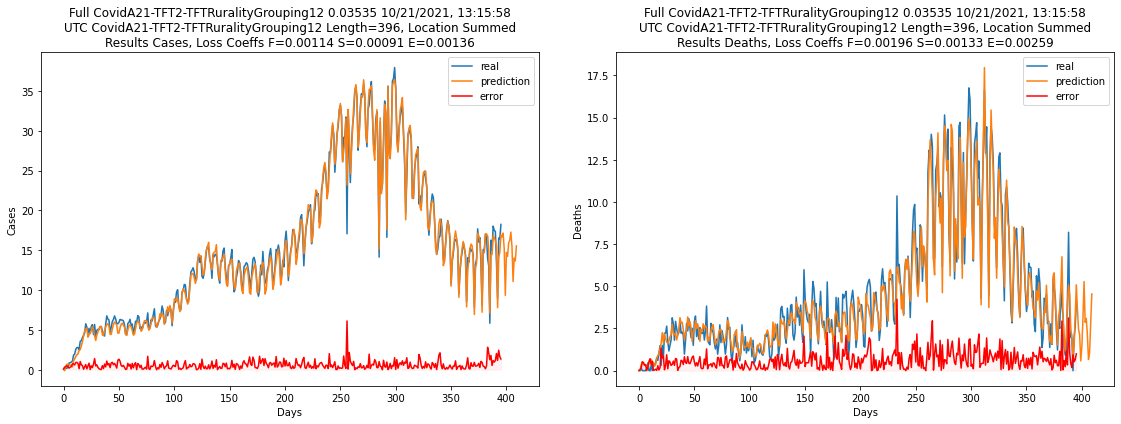

10/21/2021, 13:15:59 UTC Calculate NNSE  CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid
NNSE  0 Next Cases Averaged 0.795 Training 0.795 Validation 0.0 Summed 0.987 Training 0.987
Validation 0.0
NNSE  1 Next Deaths Averaged 0.647 Training 0.647 Validation 0.0 Summed 0.717 Training 0.717
Validation 0.0
10/21/2021, 13:16:03 UTC plot by Future Index 1 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


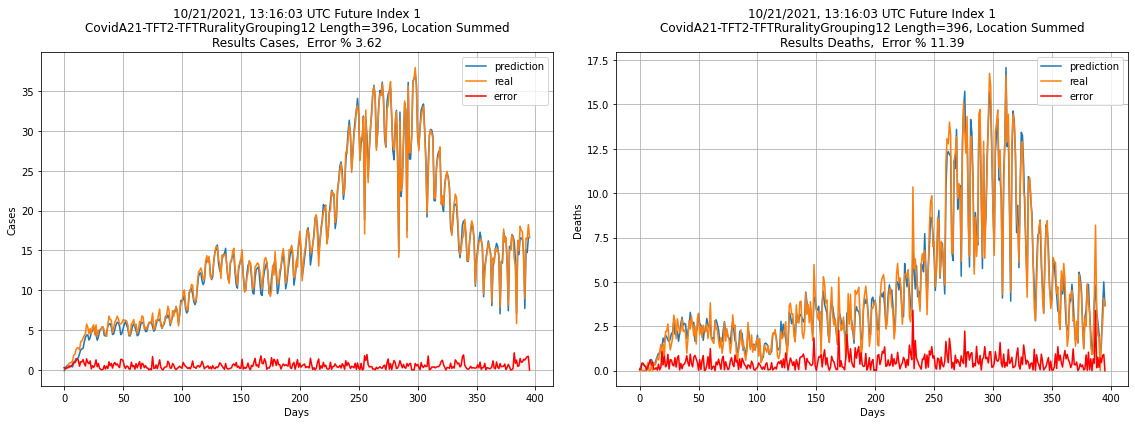

10/21/2021, 13:16:04 UTC plot by Future Index 2 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


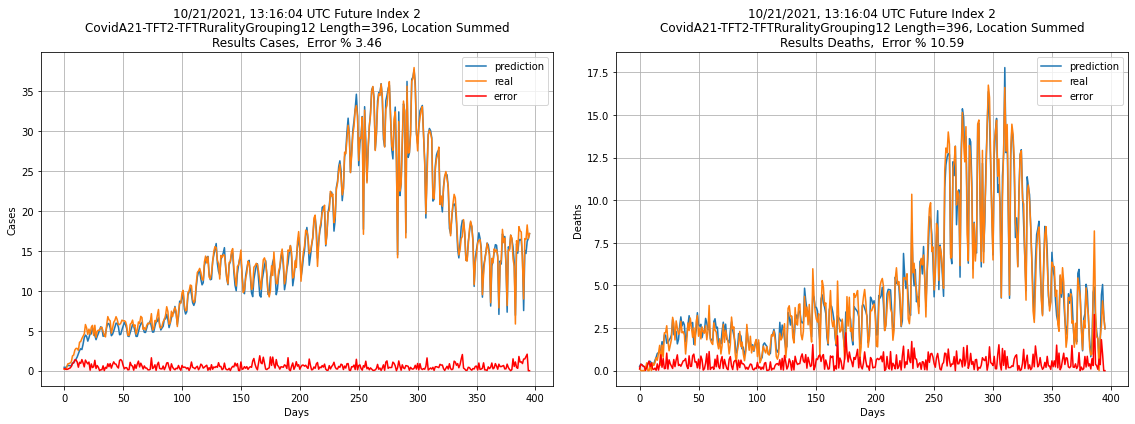

10/21/2021, 13:16:05 UTC plot by Future Index 3 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


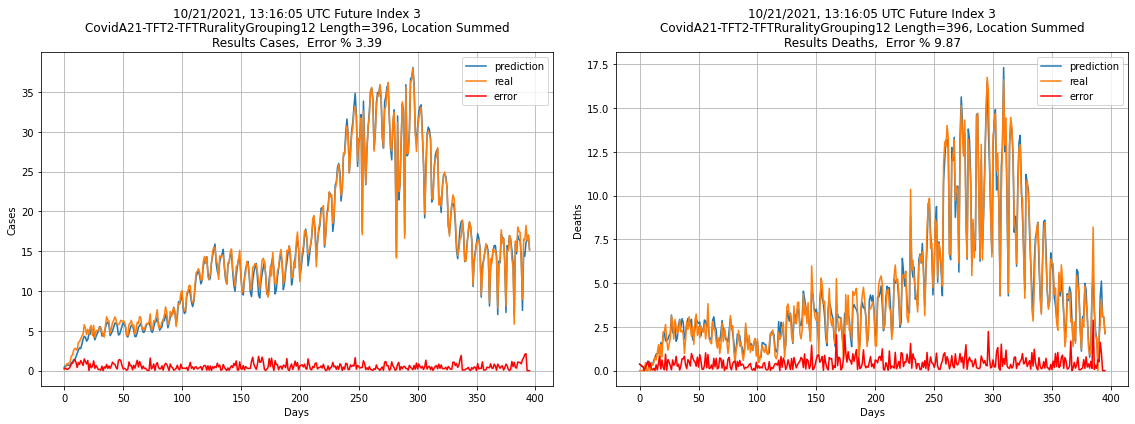

10/21/2021, 13:16:06 UTC plot by Future Index 4 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


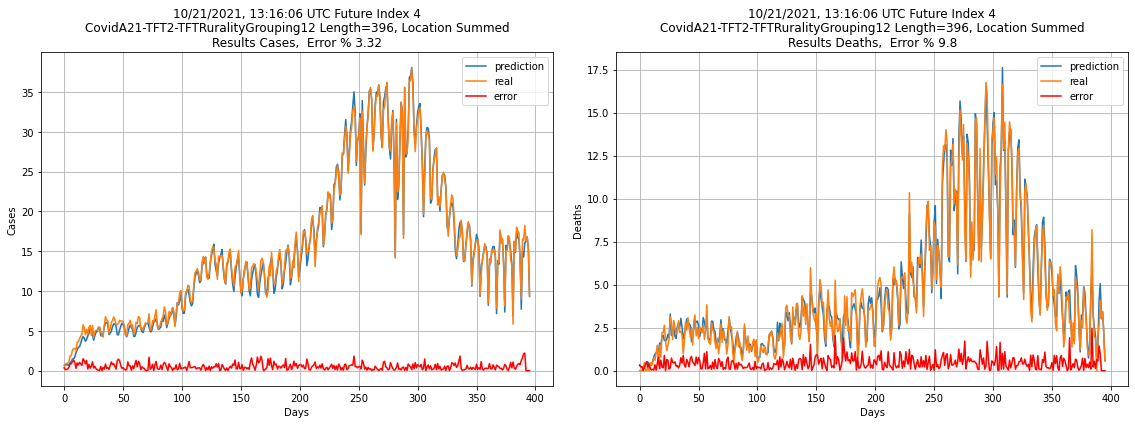

10/21/2021, 13:16:07 UTC plot by Future Index 5 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


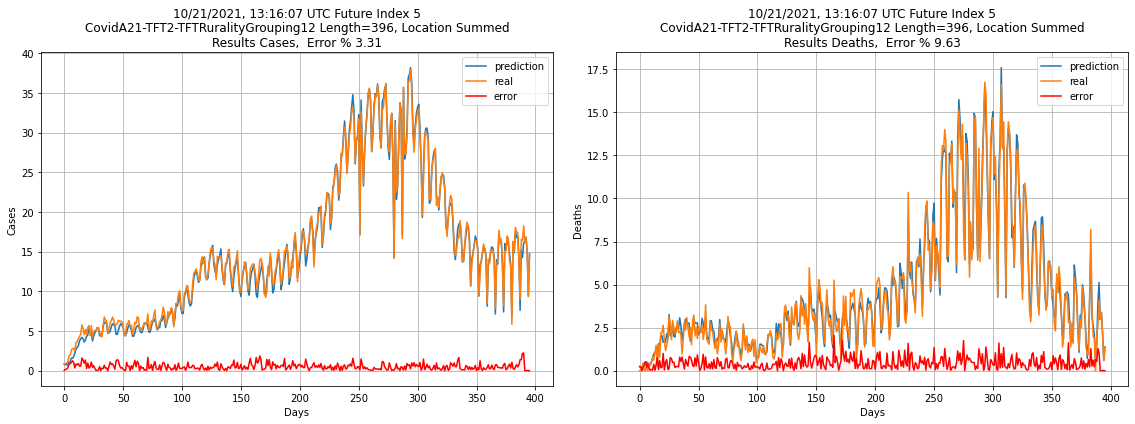

10/21/2021, 13:16:08 UTC plot by Future Index 6 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


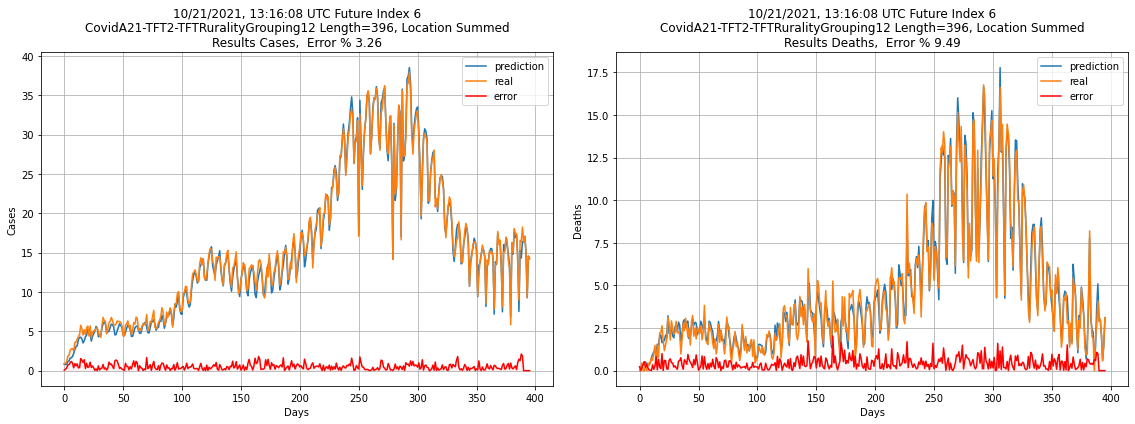

10/21/2021, 13:16:09 UTC plot by Future Index 7 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


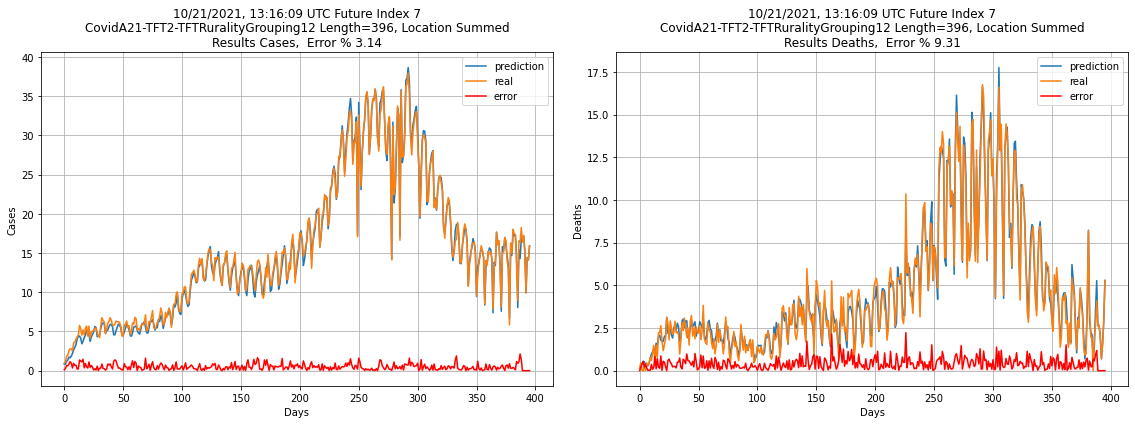

10/21/2021, 13:16:10 UTC plot by Future Index 8 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


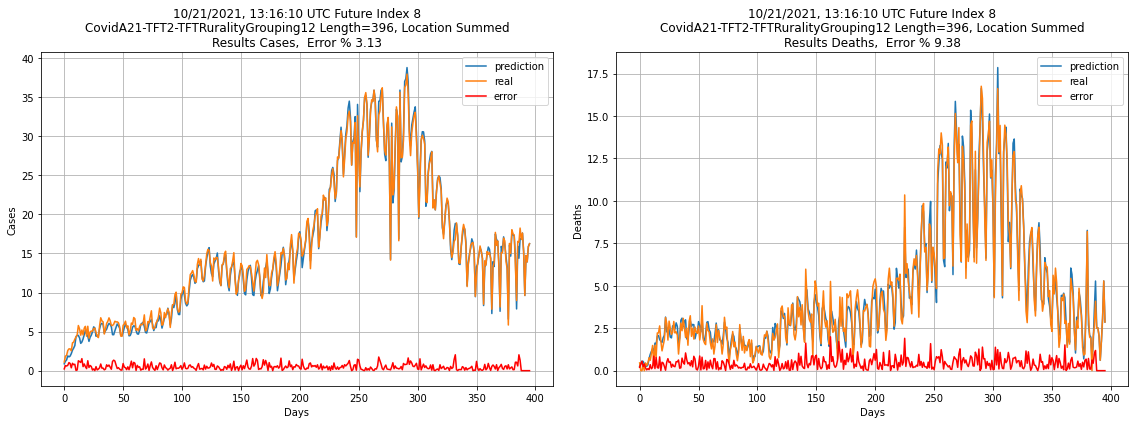

10/21/2021, 13:16:10 UTC plot by Future Index 9 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


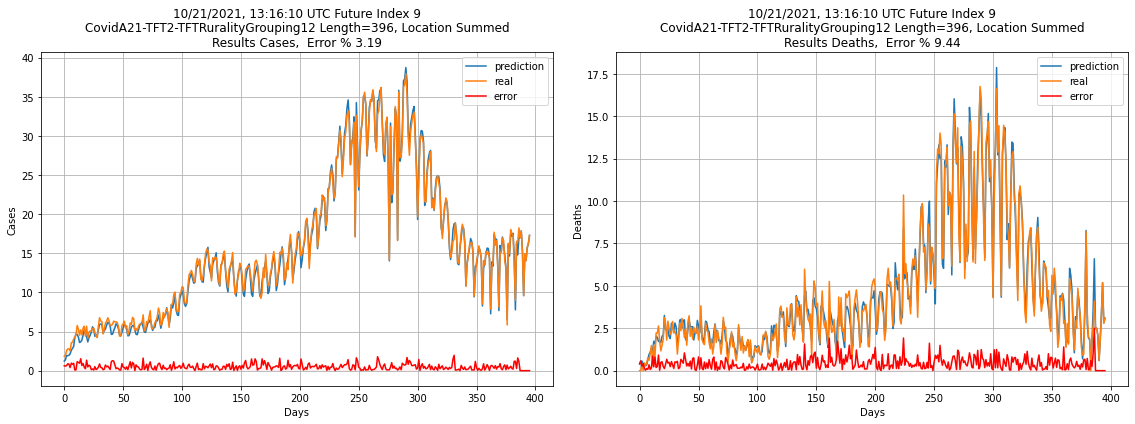

10/21/2021, 13:16:11 UTC plot by Future Index 10 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


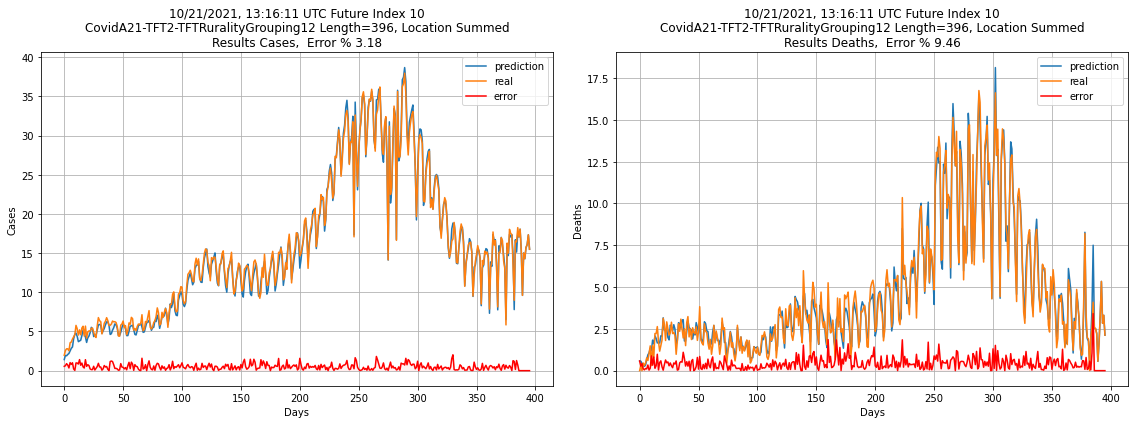

10/21/2021, 13:16:12 UTC plot by Future Index 11 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


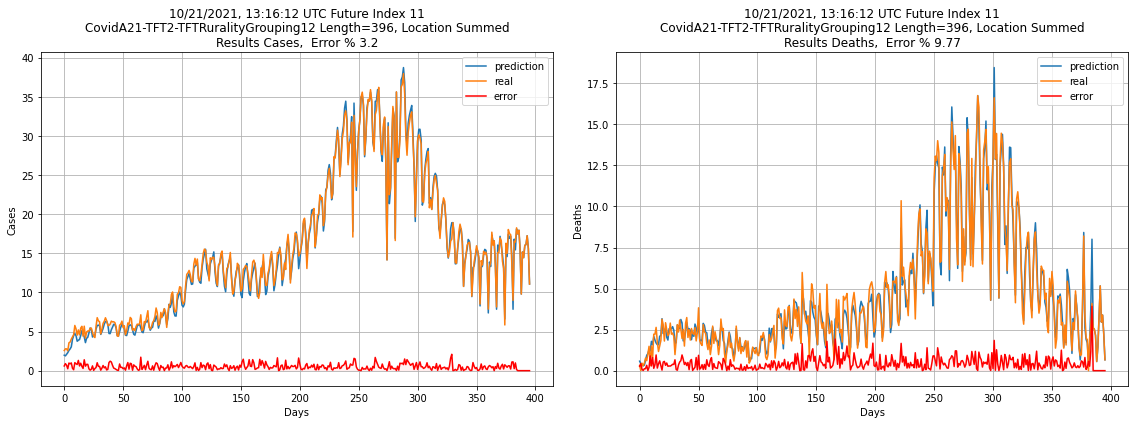

10/21/2021, 13:16:13 UTC plot by Future Index 12 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


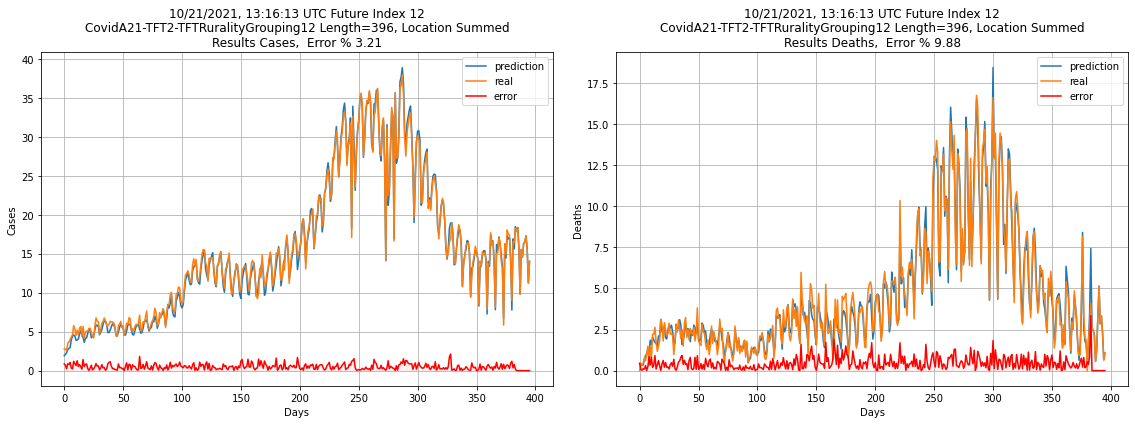

10/21/2021, 13:16:14 UTC plot by Future Index 13 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


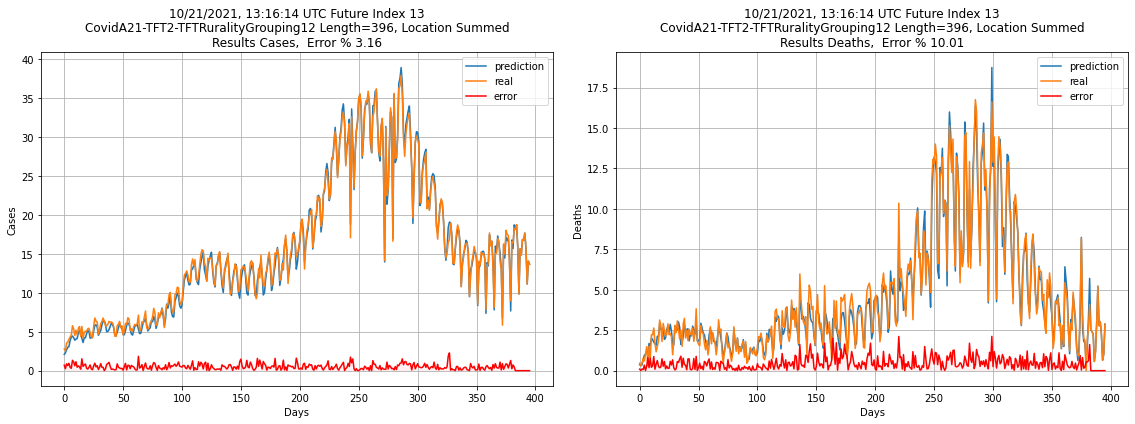

10/21/2021, 13:16:15 UTC plot by Future Index 14 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


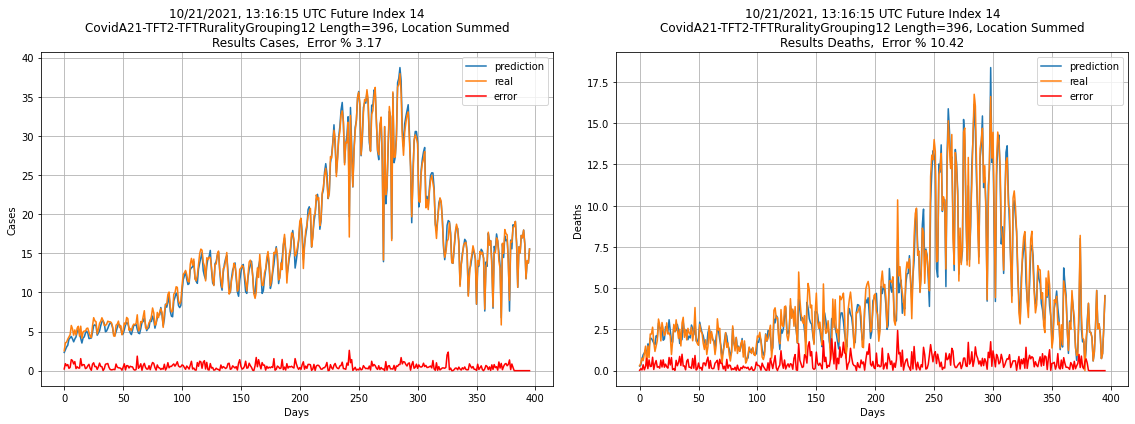

10/21/2021, 13:16:16 UTC Produce Individual Plots CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid
10/21/2021, 13:16:16 UTC CovidA21-TFT2-TFTRuralityGrouping12 Best and Worst  TFT Dev on Covid

10/21/2021, 13:16:17 UTC Best 35031 McKinley County New Mexico ABS(error) 63.34 RMSE 0.62
0) 35031 McKinley County ABS(error) Total 63.3378 Components  20.57 42.77
1) 42111 Somerset County ABS(error) Total 69.9071 Components  24.74 45.16
2) 42039 Crawford County ABS(error) Total 70.8382 Components  22.47 48.37
3) 39169 Wayne County ABS(error) Total 74.8008 Components  18.18 56.62
4) 39045 Fairfield County ABS(error) Total 76.864 Components  14.66 62.2
5) 42033 Clearfield County ABS(error) Total 79.3068 Components  19.92 59.38
6) 22097 St. Landry Parish ABS(error) Total 82.9499 Components  24.41 58.54
7) 42063 Indiana County ABS(error) Total 82.9609 Components  21.66 61.31
8) 36037 Genesee County ABS(error) Total 85.5032 Components  27.17 58.34
9) 45059 Laurens County ABS(error) Total 86.909

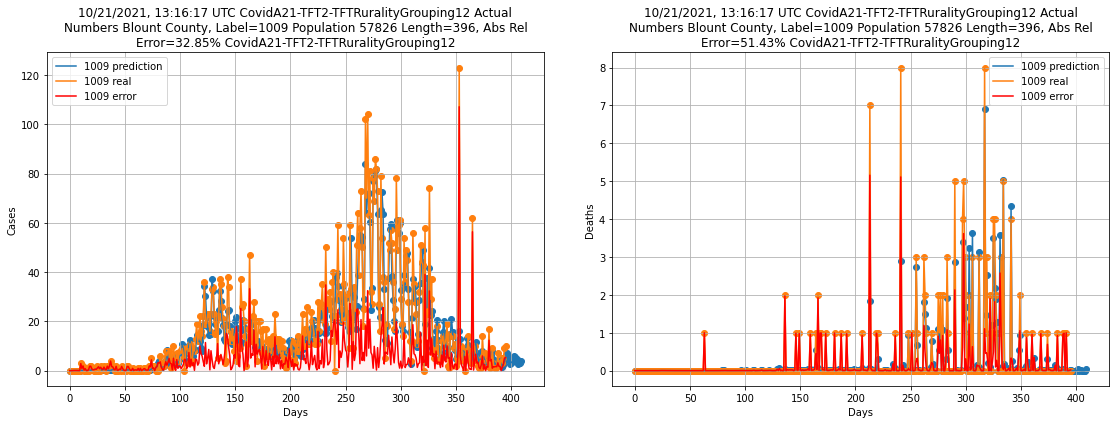

10/21/2021, 13:16:18 UTC plot by location 10 population 65084 6103 Tehama County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


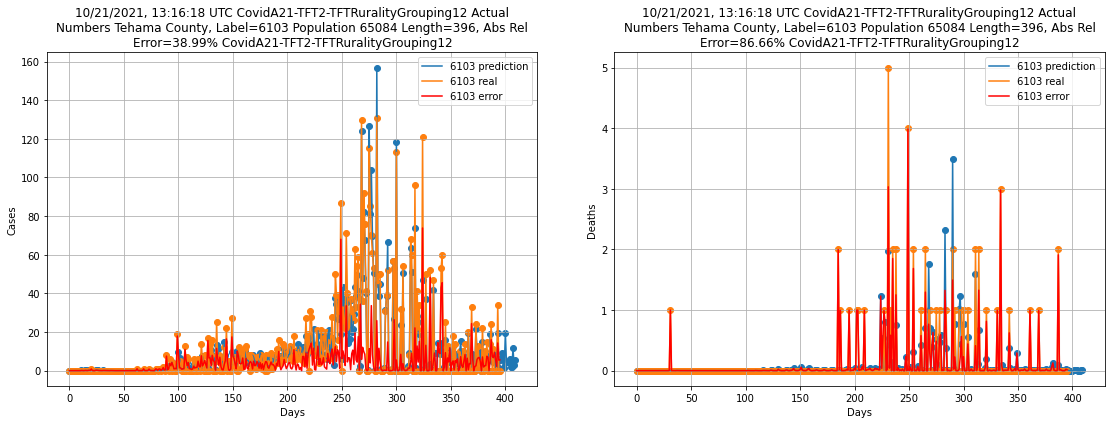

10/21/2021, 13:16:18 UTC plot by location 20 population 72977 13157 Jackson County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


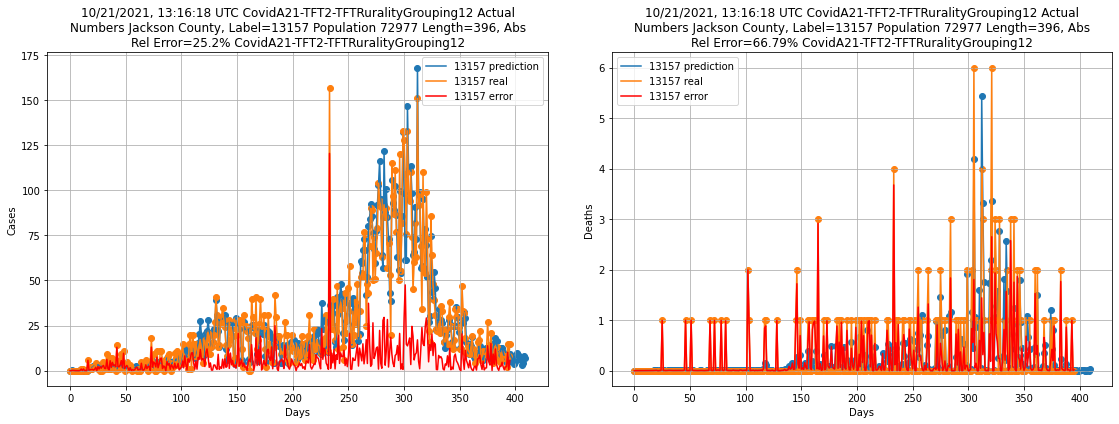

10/21/2021, 13:16:19 UTC plot by location 30 population 35777 18001 Adams County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


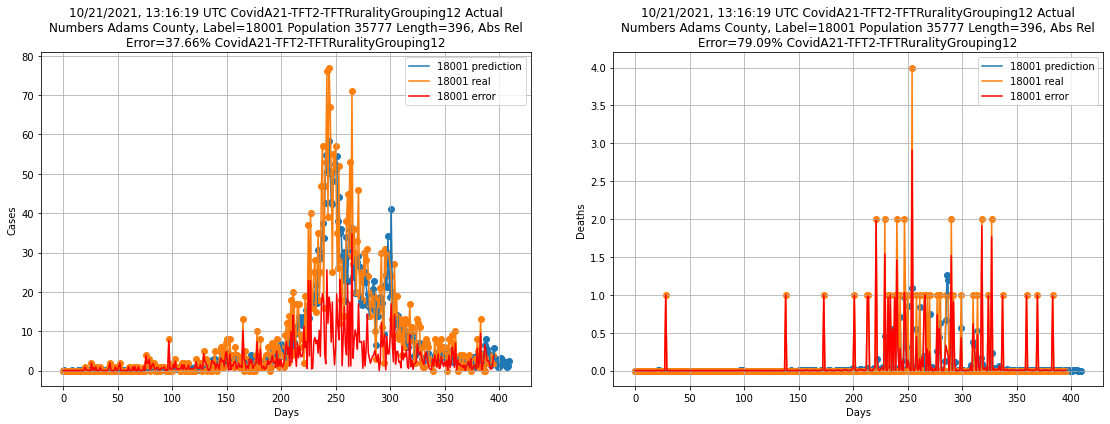

10/21/2021, 13:16:20 UTC plot by location 40 population 47744 18113 Noble County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


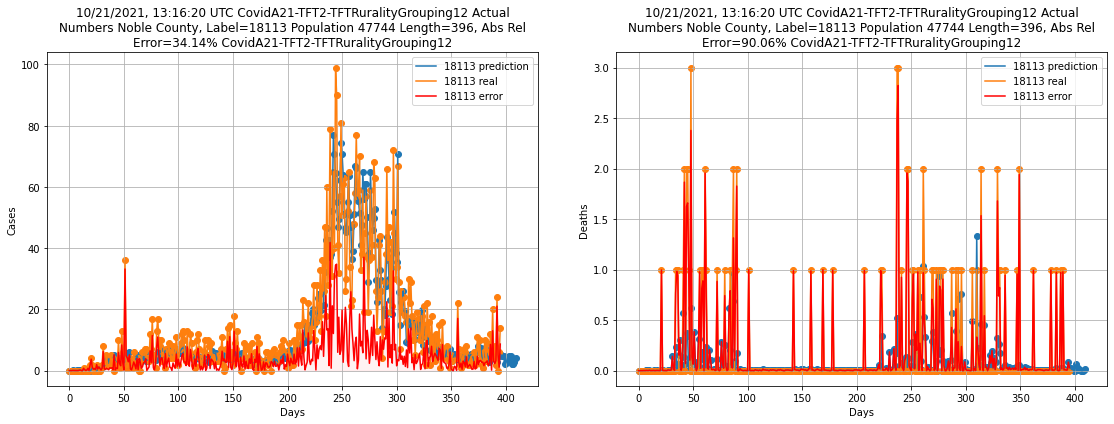

10/21/2021, 13:16:20 UTC plot by location 50 population 46233 21179 Nelson County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


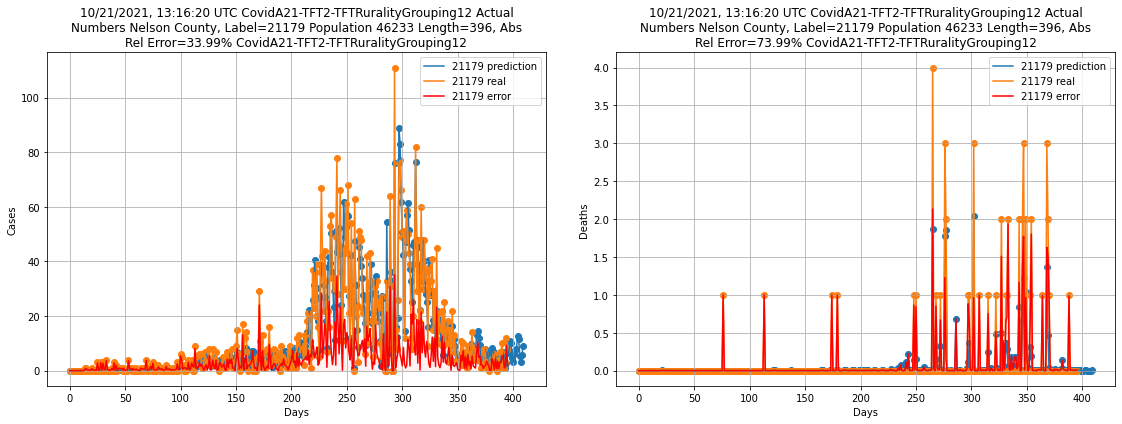

10/21/2021, 13:16:21 UTC plot by location 60 population 122302 23011 Kennebec County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


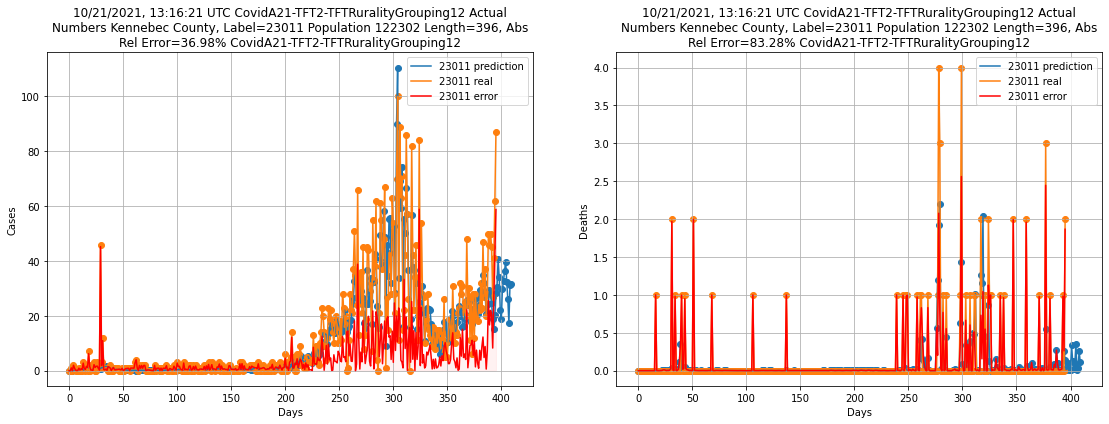

10/21/2021, 13:16:22 UTC plot by location 70 population 35684 26061 Houghton County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


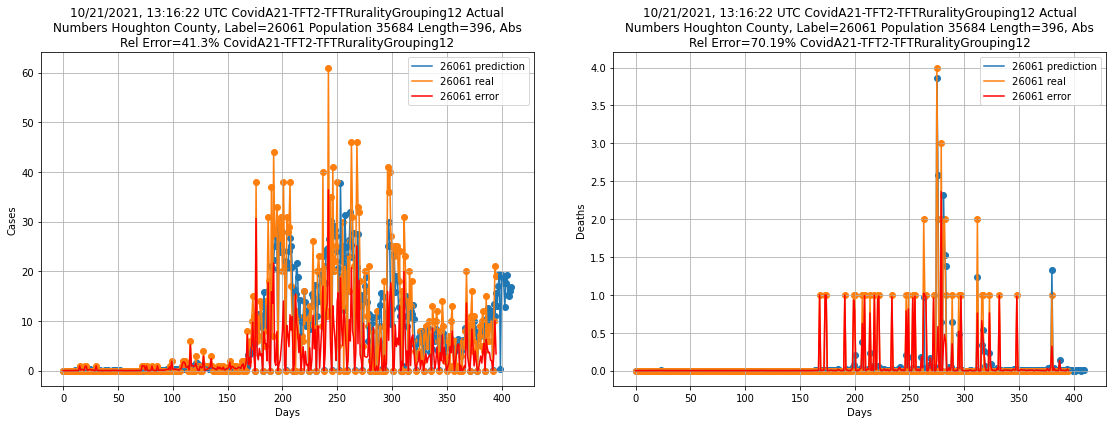

10/21/2021, 13:16:23 UTC plot by location 80 population 46340 27049 Goodhue County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


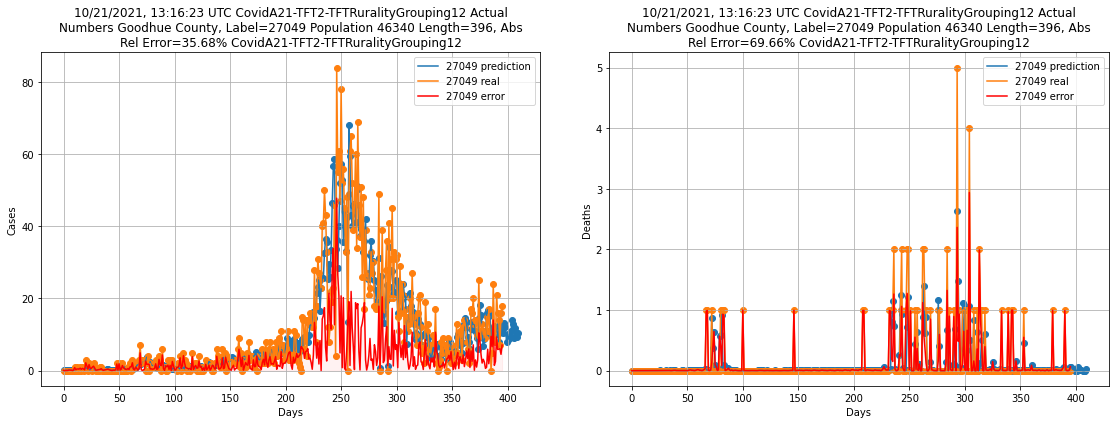

10/21/2021, 13:16:23 UTC plot by location 90 population 61303 33001 Belknap County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


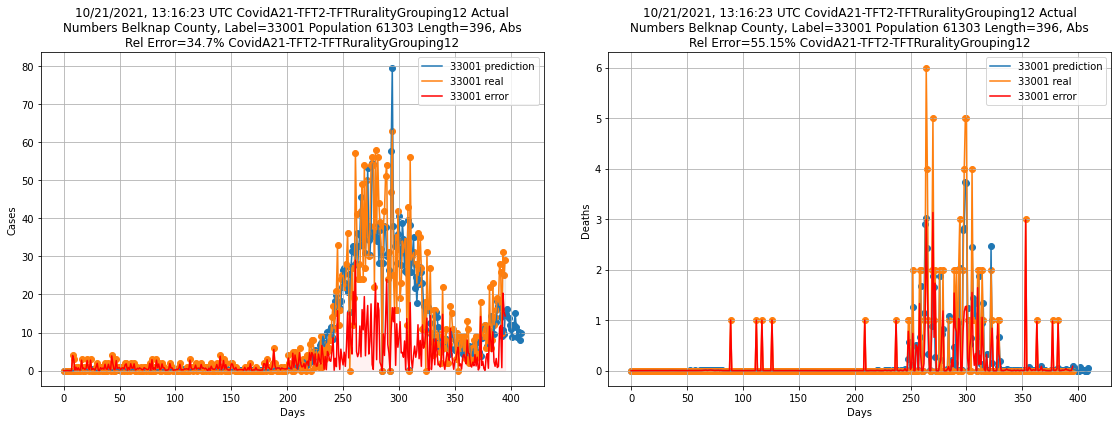

10/21/2021, 13:16:24 UTC plot by location 100 population 46994 37013 Beaufort County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


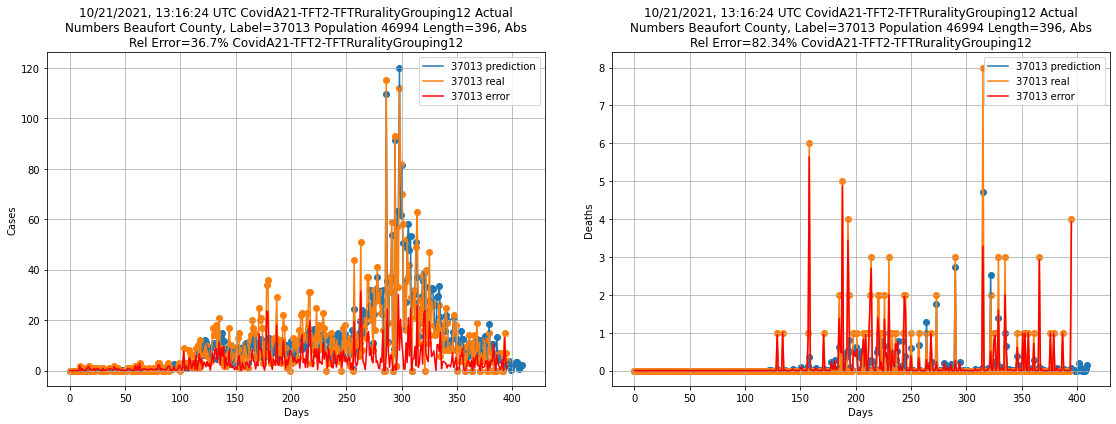

10/21/2021, 13:16:25 UTC plot by location 110 population 67029 37161 Rutherford County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


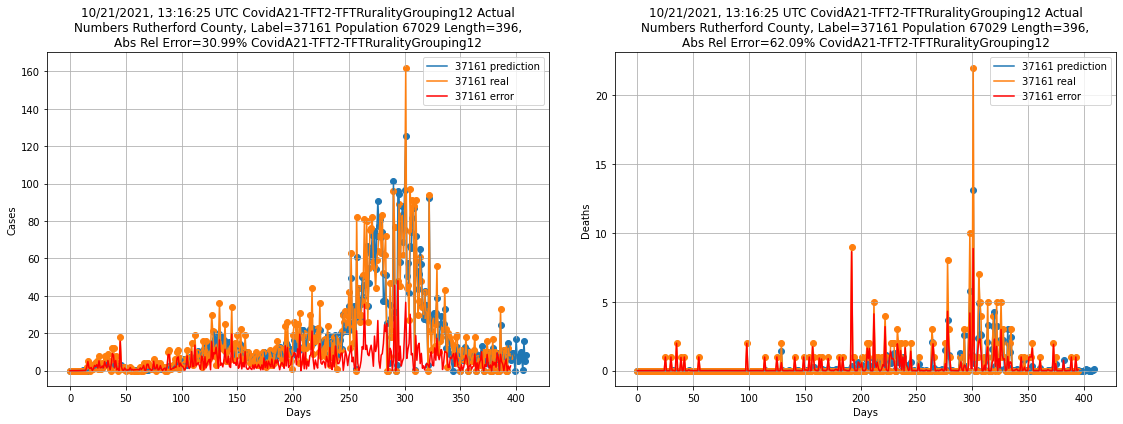

10/21/2021, 13:16:26 UTC plot by location 120 population 29898 39053 Gallia County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


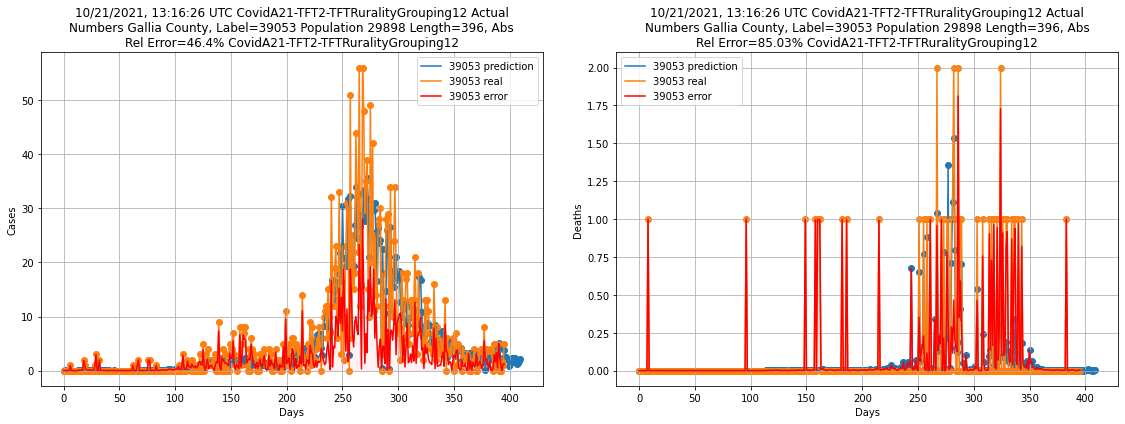

10/21/2021, 13:16:26 UTC plot by location 130 population 41100 40097 Mayes County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


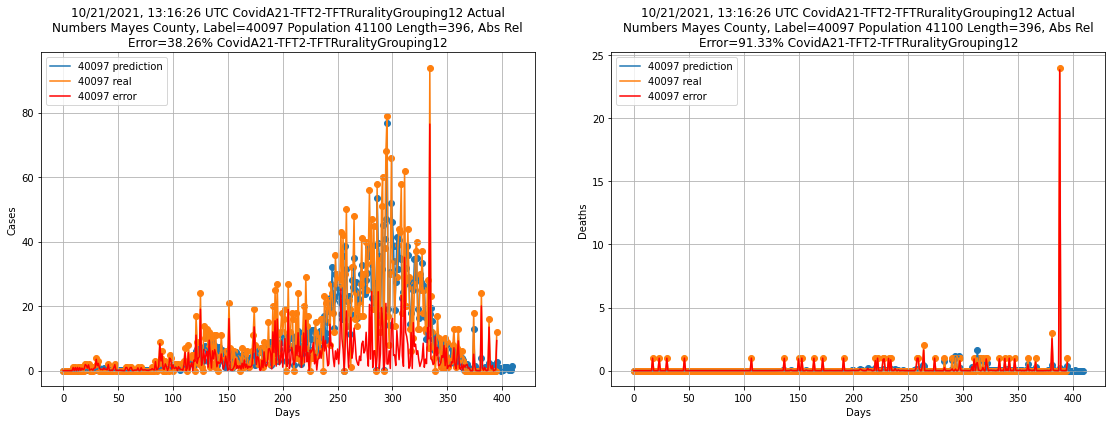

10/21/2021, 13:16:27 UTC plot by location 140 population 50668 42121 Venango County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


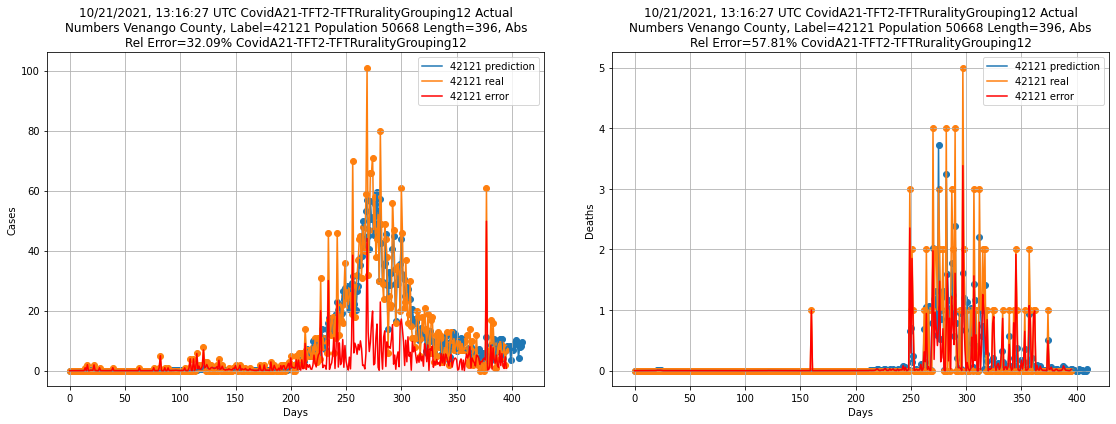

10/21/2021, 13:16:28 UTC plot by location 150 population 13715 47161 Stewart County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


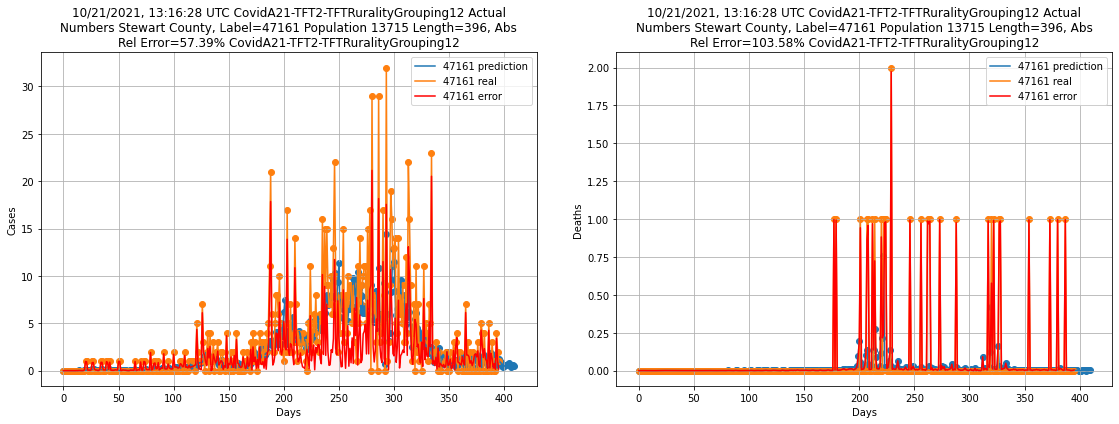

10/21/2021, 13:16:29 UTC plot by location 160 population 54406 48401 Rusk County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


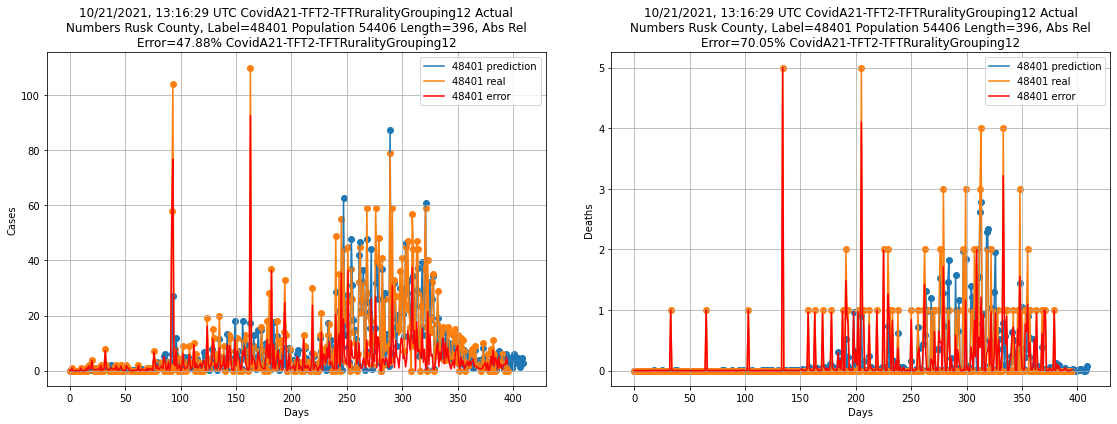

10/21/2021, 13:16:29 UTC plot by location 170 population 87839 55027 Dodge County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


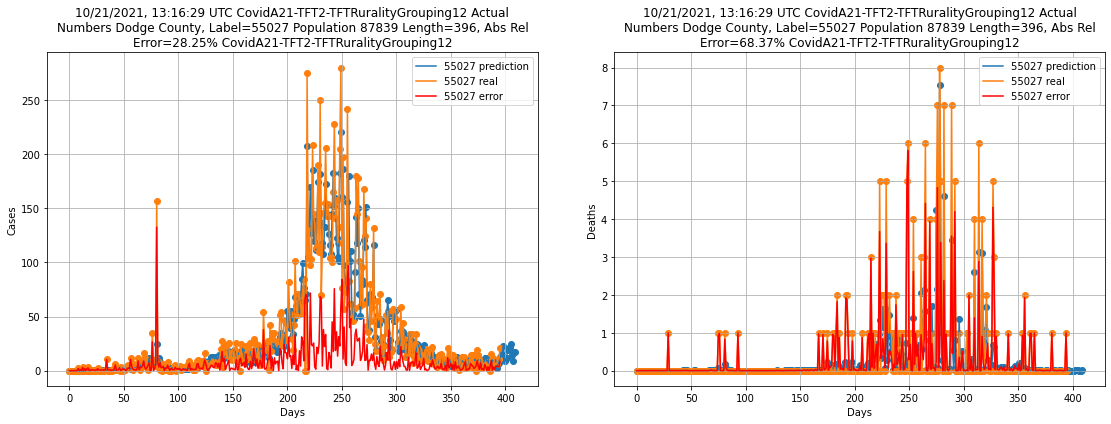

10/21/2021, 13:16:30 UTC plot by location 94 population 71367 35031 McKinley County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


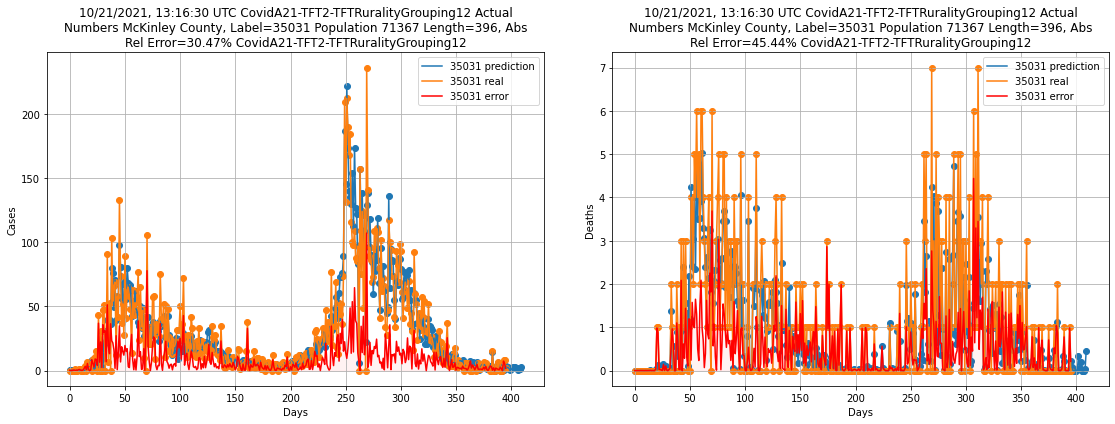

10/21/2021, 13:16:31 UTC plot by location 159 population 12023 48387 Red River County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


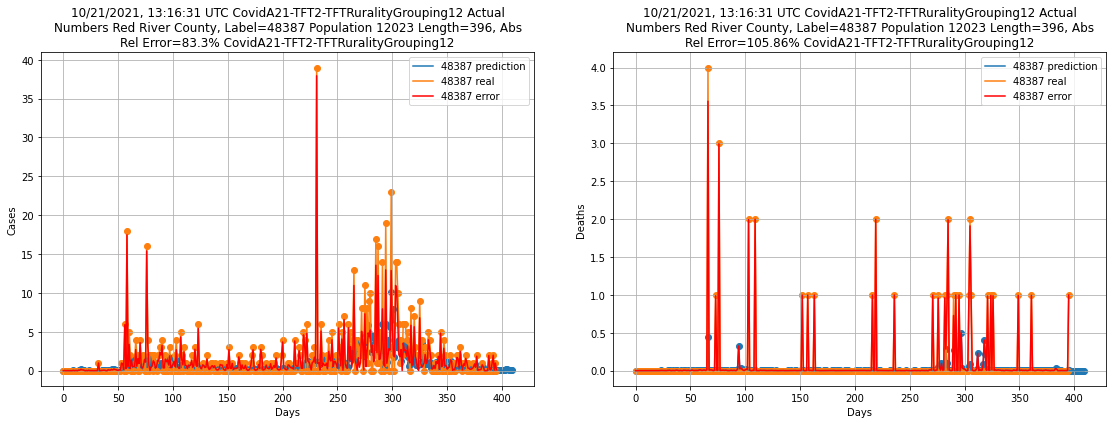

10/21/2021, 13:16:31 UTC plot by location 119 population 157574 39045 Fairfield County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


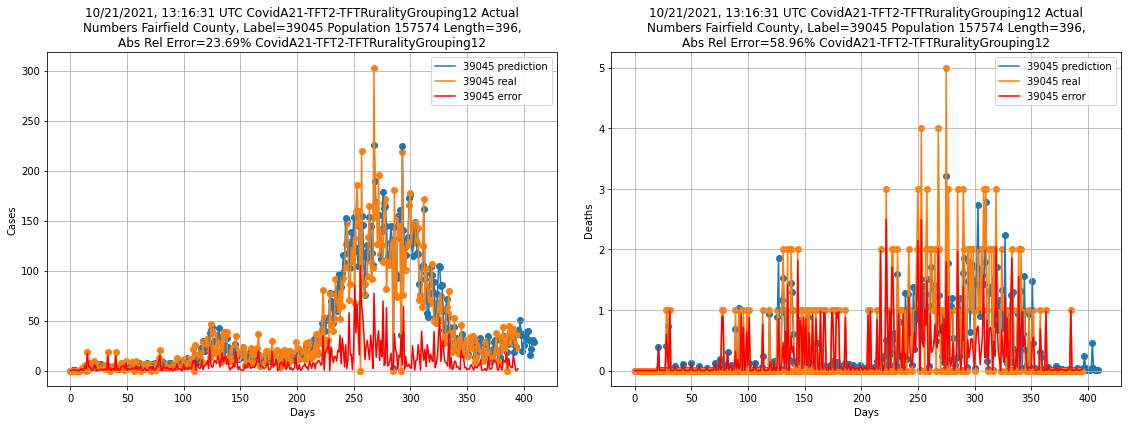

10/21/2021, 13:16:32 UTC plot by location 92 population 151391 33013 Merrimack County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


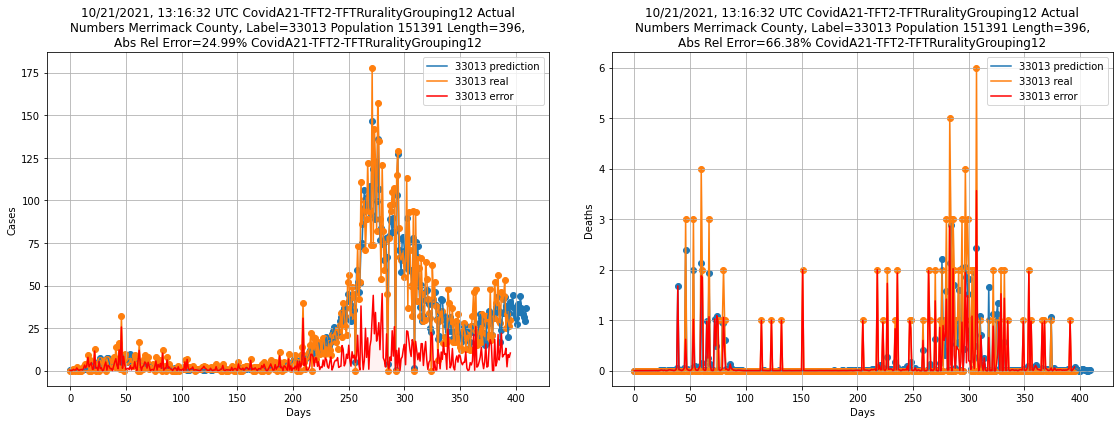

10/21/2021, 13:16:33 UTC plot by location 107 population 143667 37151 Randolph County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


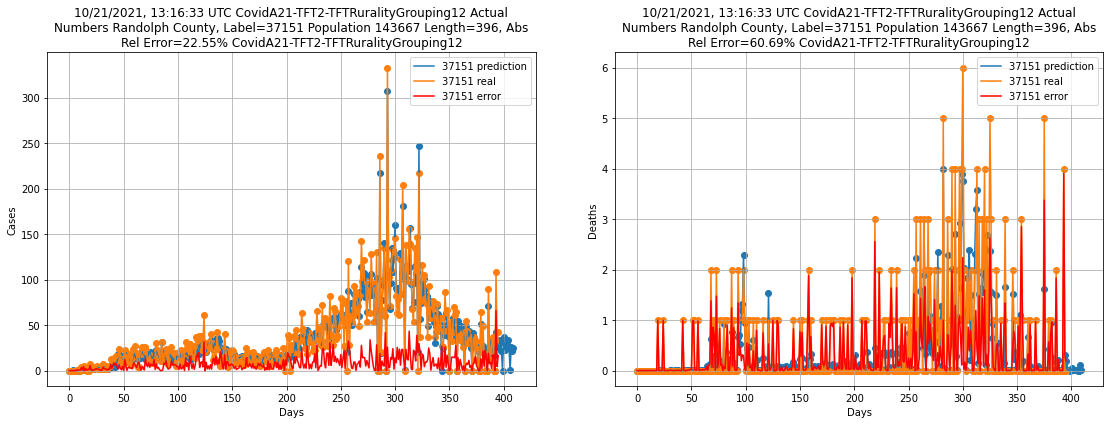

10/21/2021, 13:16:34 UTC plot by location 108 population 130625 37155 Robeson County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


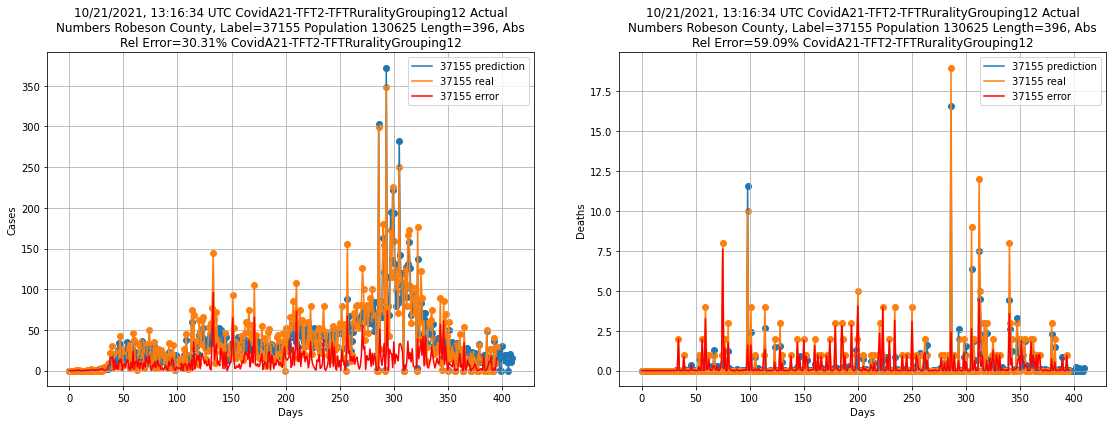

10/21/2021, 13:16:34 UTC plot by location 60 population 122302 23011 Kennebec County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


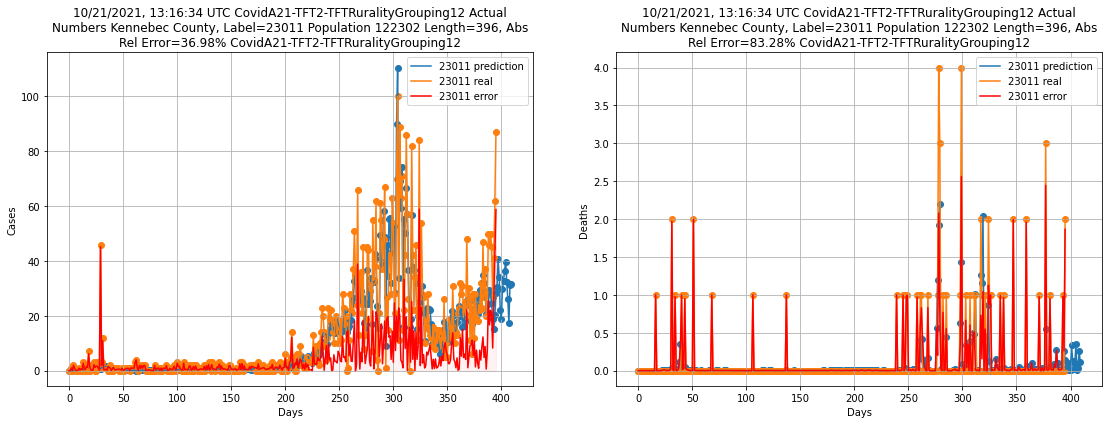

10/21/2021, 13:16:35 UTC plot by location 14 population 119992 13045 Carroll County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


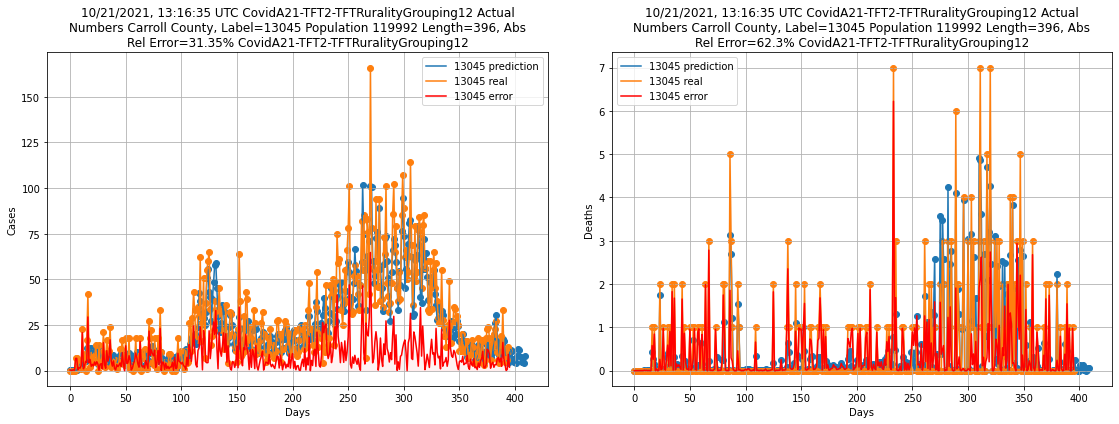

10/21/2021, 13:16:36 UTC plot by location 98 population 117124 36075 Oswego County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


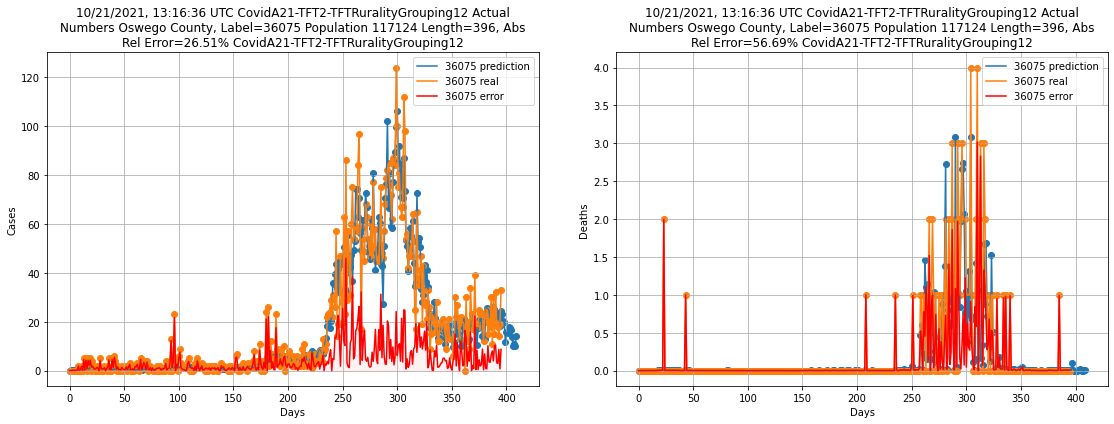

10/21/2021, 13:16:36 UTC plot by location 126 population 115710 39169 Wayne County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


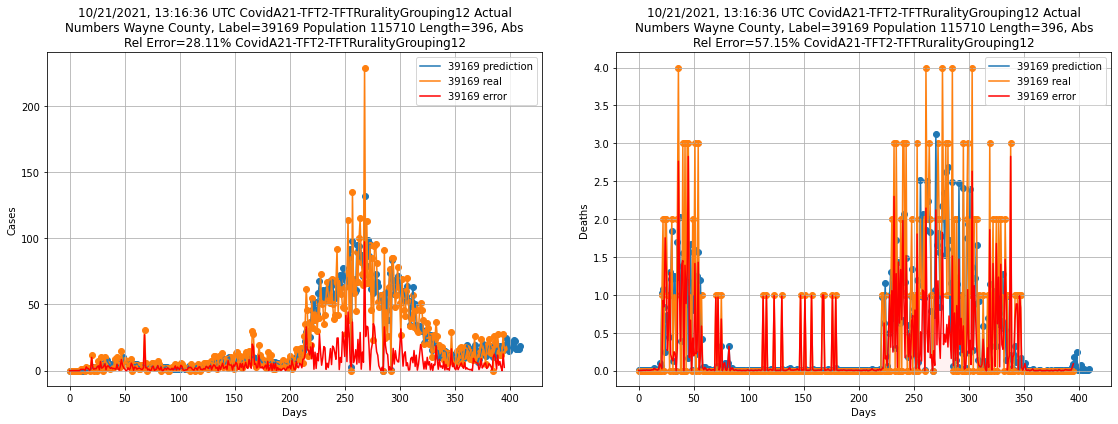

10/21/2021, 13:16:37 UTC plot by location 133 population 110980 41019 Douglas County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


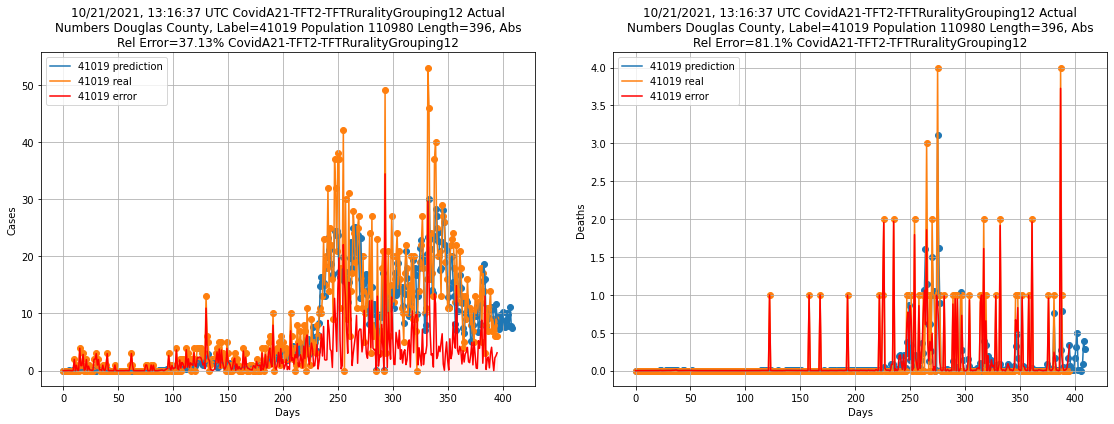

10/21/2021, 13:16:38 UTC plot by location 88 population 103806 30029 Flathead County CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


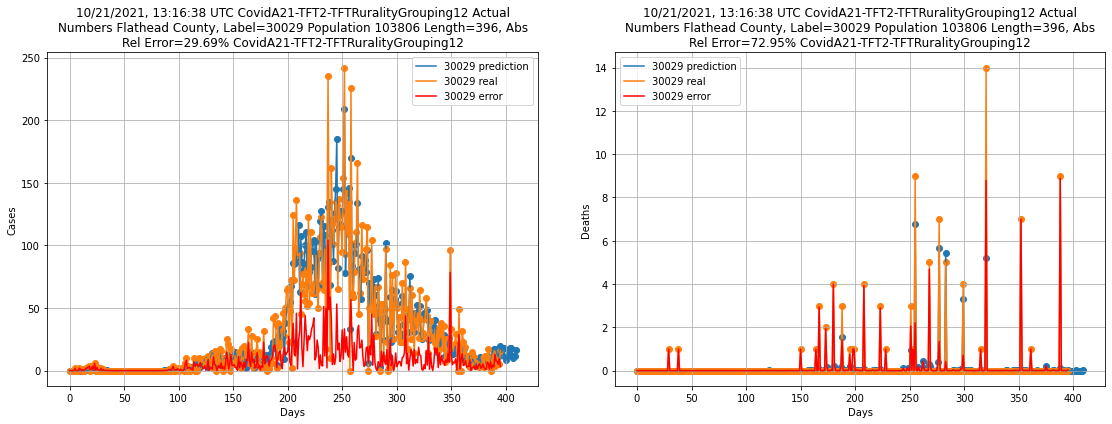

10/21/2021, 13:16:39 UTC plot by Future Index 2 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


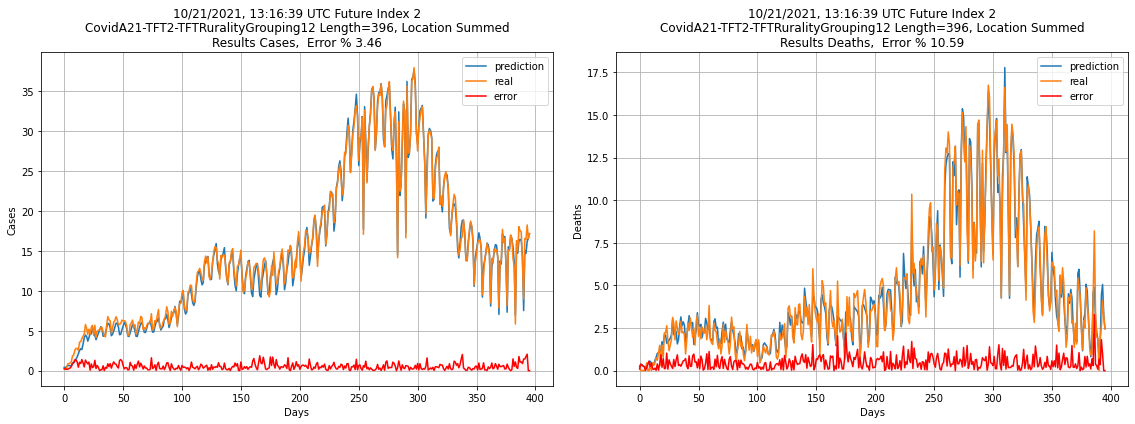

10/21/2021, 13:16:40 UTC plot by Future Index 7 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


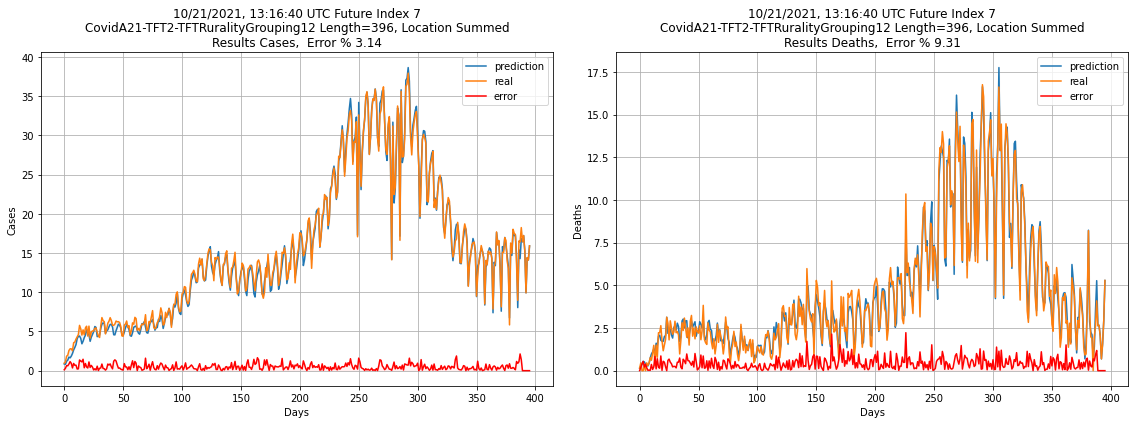

10/21/2021, 13:16:41 UTC plot by Future Index 12 CovidA21-TFT2-TFTRuralityGrouping12  TFT Dev on Covid


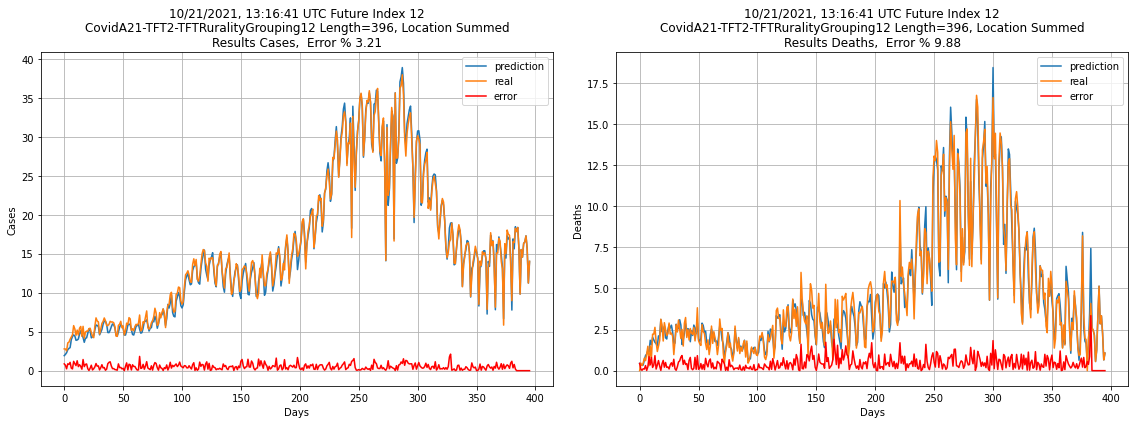

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
SkipDL2F = True
VisualizeTFT(output_map)
sys.exit(0)

### More TFT Parameters

In [ ]:

TFTnum_static = TFTScaledStaticInputs.shape[1]
if TFTCategoryCountsStaticInputs.shape[0] != TFTnum_static:
  printexit('Inconsistent static Shape)')
TFTNumDynamicVariables = TFTScaledDynamicInputs.shape[2]
if TFTCategoryCountsDynamicInputs.shape[0] != TFTNumDynamicVariables:
  printexit('Inconsistent static Shape)')
TFTNumDynamicHistoryVariables = 0
TFTNumDynamicFutureVariables = 0



TFTFutureInputLSTM = False
if TFTNumDynamicFutureVariables == 0:
  TFTFutureInputLSTM = False
else:
  TFTFutureInputLSTM = True

# Standalone LSTM Model

### LSTM Utilities

In [ ]:

def get_model_summary(model):  
  stream = io.StringIO()
  model.summary(print_fn=lambda x: stream.write(x + '\n'))
  summary_string = stream.getvalue()
  stream.close()
  return summary_string

def setDLinput(Spacetime = True):
  # Initial data is Flatten([Num_Seq][Nloc]) [Tseq] with values [Nprop-Sel + Nforcing + Add(ExPosEnc-Selin)] starting with   RawInputSequencesTOT
  # Predictions are Flatten([Num_Seq] [Nloc]) [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range] starting with RawInputPredictionsTOT
  # No assumptions as to type of variables here
  if SymbolicWindows:
    X_predict = SymbolicInputSequencesTOT.reshape(OuterBatchDimension,1,1)
  else:
    X_predict = RawInputSequencesTOT.reshape(OuterBatchDimension,Tseq,NpropperseqTOT)
  y_predict = RawInputPredictionsTOT.reshape(OuterBatchDimension,NpredperseqTOT)
  if Spacetime:
     SpacetimeforMask_predict =  SpacetimeforMask.reshape(OuterBatchDimension,1,1).copy()
     return X_predict, y_predict, SpacetimeforMask_predict
  return X_predict, y_predict

def setSeparateDLinput(model, Spacetime = False):
  # Initial data is Flatten([Num_Seq][Nloc]) [Tseq] with values [Nprop-Sel + Nforcing + Add(ExPosEnc-Selin)] starting with   RawInputSequencesTOT
  # Predictions are Flatten([Num_Seq] [Nloc]) [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range] starting with RawInputPredictionsTOT
  # No assumptions as to type of variables here
  # model = 0 LSTM =1 transformer
  if model == 0: 
    Spacetime = False
  X_val = None
  y_val = None
  Spacetime_val = None
  Spacetime_train = None
  if SymbolicWindows:
    InputSequences = np.empty([Num_Seq, TrainingNloc], dtype = np.int32)
    for iloc in range(0,TrainingNloc):   
      InputSequences[:,iloc] = SymbolicInputSequencesTOT[:,ListofTrainingLocs[iloc]]
    if model == 0:
      X_train = InputSequences.reshape(Num_Seq*TrainingNloc,1,1)
    else:
      X_train = InputSequences
    if Spacetime:
      Spacetime_train = X_train.copy()

    if LocationValidationFraction > 0.001:
      UsedValidationNloc = ValidationNloc
      if FullSetValidation:
        UsedValidationNloc = Nloc
      ValInputSequences = np.empty([Num_Seq, UsedValidationNloc], dtype = np.int32)
      if FullSetValidation:
        for iloc in range(0,Nloc):
          ValInputSequences[:,iloc] = SymbolicInputSequencesTOT[:,iloc]
      else:
        for iloc in range(0,ValidationNloc):
          ValInputSequences[:,iloc] = SymbolicInputSequencesTOT[:,ListofValidationLocs[iloc]]
      if model == 0:
        X_val = ValInputSequences.reshape(Num_Seq * UsedValidationNloc,1,1)
      else:
        X_val = ValInputSequences
      if Spacetime:
        Spacetime_val = X_val.copy()

  else: # Symbolic Windows false Calculate Training
    InputSequences = np.empty([Num_Seq, TrainingNloc,Tseq,NpropperseqTOT], dtype = np.float32)
    for iloc in range(0,TrainingNloc): 
      InputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,ListofTrainingLocs[iloc],:,:]
    if model == 0:
      X_train = InputSequences.reshape(Num_Seq*TrainingNloc,Tseq,NpropperseqTOT)
    else:
      X_train = InputSequences
    if Spacetime:
      Spacetime_train = np.empty([Num_Seq, TrainingNloc], dtype = np.int32)
      for iloc in range(0,TrainingNloc):   
        Spacetime_train[:,iloc] = SpacetimeforMask[:,ListofTrainingLocs[iloc]]

    if LocationValidationFraction > 0.001: # Symbolic Windows false Calculate Validation
      UsedValidationNloc = ValidationNloc
      if FullSetValidation:
        UsedValidationNloc = Nloc
      ValInputSequences = np.empty([Num_Seq, UsedValidationNloc,Tseq,NpropperseqTOT], dtype = np.float32)
      if FullSetValidation:
        for iloc in range(0,Nloc):
          ValInputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,iloc,:,:]
      else:
        for iloc in range(0,ValidationNloc):
          ValInputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,ListofValidationLocs[iloc],:,:]
      if model == 0:
        X_val = ValInputSequences.reshape(Num_Seq * UsedValidationNloc,Tseq,NpropperseqTOT)
      else:
        X_val = ValInputSequences
      if Spacetime:
        Spacetime_val = np.empty([Num_Seq, UsedValidationNloc], dtype = np.int32)
        if FullSetValidation:
          for iloc in range(0,Nloc):
            Spacetime_val[:,iloc] = SpacetimeforMask[:,iloc]
        else:
          for iloc in range(0,ValidationNloc):   
            Spacetime_val[:,iloc] = SpacetimeforMask[:,ListofValidationLocs[iloc]]
  
  # Calculate training predictions 
  InputPredictions = np.empty([Num_Seq, TrainingNloc,NpredperseqTOT], dtype = np.float32)
  for iloc in range(0,TrainingNloc):
    InputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,ListofTrainingLocs[iloc],:]
  if model == 0:
    y_train = InputPredictions.reshape(OuterBatchDimension,NpredperseqTOT)
  else:
    y_train = InputPredictions

  # Calculate validation predictions 
  if LocationValidationFraction > 0.001:
    ValInputPredictions = np.empty([Num_Seq, UsedValidationNloc,NpredperseqTOT], dtype = np.float32)
    if FullSetValidation:
      for iloc in range(0,Nloc):
        ValInputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,iloc,:]
    else:
      for iloc in range(0,ValidationNloc):
        ValInputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,ListofValidationLocs[iloc],:]
    if model == 0:
      y_val = ValInputPredictions.reshape(Num_Seq * ValidationNloc,NpredperseqTOT)
    else:
      y_val = ValInputPredictions

  if Spacetime:
    return X_train, y_train, Spacetime_train, X_val, y_val, Spacetime_val
  else:    
    return X_train, y_train,X_val,y_val

def InitializeDLforTimeSeries(message,processindex,y_predict):
  if( processindex == 0 ):
      current_time = timenow()
      line = (startbold + current_time + ' ' + message + resetfonts + " Window Size " + str(Tseq) + 
            " Number of samples over time that sequence starts at and location:" +str(OuterBatchDimension) + 
            " Number input features per sequence:" + str(NpropperseqTOT) +  
            " Number of predicted outputs per sequence:" + str(NpredperseqTOT) + 
            " Batch_size:" + str(LSTMbatch_size) + 
            " n_nodes:" + str(number_LSTMnodes) + 
            " epochs:" + str(LSTMepochs))
      print(wraptotext(line))
      checkNaN(y_predict)

<IPython.core.display.Javascript object>

##LSTM Models

### LSTM Model and Layer Class

In [ ]:
class MyLSTMmodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(MyLSTMmodel, self).__init__(**kwargs)
    self.fullLSTM = MyLSTMlayer()

  def call(self, inputs):  
    outputs = self.fullLSTM(inputs)
    return outputs

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])
    
class MyLSTMlayer(tf.keras.Model):
# Class for a simple multiple layer LSTM with FCN at start and end
# All parameters defined externally
# structured so MyLSTMlayer can be used standalone or in part of a transformer

  def __init__(self, **kwargs):
    super(MyLSTMlayer, self).__init__(**kwargs)
    self.return_state = True
      #  if self.return_state:
    if (LSTMInitialMLP > 0) and (not LSTMSkipInitial):
      self.dense_1 = tf.keras.layers.Dense(LSTMInitialMLP, activation=LSTMactivationvalue)
    self.LSTM_1 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation,
                  return_state=self.return_state, stateful=False,)
    self.LSTM_2 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
        activation= LSTMactivationvalue , return_sequences=LSTMThirdLayer, recurrent_activation= LSTMrecurrent_activation)
    if(LSTMThirdLayer):
      self.LSTM_3 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                    activation= LSTMactivationvalue , return_sequences=False, recurrent_activation= LSTMrecurrent_activation)
    self.dense_2 = tf.keras.layers.Dense(LSTMFinalMLP, activation=LSTMactivationvalue)
    self.dense_f = tf.keras.layers.Dense(NpredperseqTOT)

  def call(self, inputs, training=None):
    if (LSTMInitialMLP > 0) and (not LSTMSkipInitial):
      Runningdata = self.dense_1(inputs)
      if self.return_state:
        Runningdata, state_h, state_c = self.LSTM_1(Runningdata, training=training)
      else:
          Runningdata, state_h, state_c  = self.LSTM_1(Runningdata, training=training)
        # else:
        #   Runningdata = self.LSTM_1(Runningdata, training=training)
    else:
      Runningdata, state_h, state_c = self.LSTM_1(inputs, training=training)
    if self.return_state:  
      Runningdata = self.LSTM_2(Runningdata, training=training, initial_state=[state_h, state_c])
    else:
      Runningdata = self.LSTM_2(Runningdata, training=training)
    if(LSTMThirdLayer):
      Runningdata = self.LSTM_3(Runningdata, training=training)
    if(LSTMFinalMLP > 0):
      Runningdata = self.dense_2(Runningdata)
    Outputdata = self.dense_f(Runningdata)
    return Outputdata

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

<IPython.core.display.Javascript object>

###Run LSTM Class with Keras Model

In [ ]:
def RunLSTMClassVersion():
  # Run the LSTM model defined by Model and Layer class


  X_predict, y_predict = setDLinput(Spacetime = False)
  InitializeDLforTimeSeries('Class Version ',processindex,y_predict)

  X_train, y_train = shuffleDLinput(X_predict, y_predict)
 
  myLSTMmodel = MyLSTMmodel(name ='myLSTMmodel')
  if CustomLoss == 0:
      myLSTMmodel.compile(loss='mse', optimizer= LSTMoptimizer)
  if CustomLoss == 1:
      myLSTMmodel.compile(loss= custom_lossGCF1, optimizer= LSTMoptimizer)
  if CustomLoss == 4:    
      myLSTMmodel.compile(loss= custom_lossGCF4, optimizer= LSTMoptimizer)

  the_callbacks = [TqdmCallback(),]

  if UseClassweights:   
      cw = {}
      for i in range(0,NpredperseqTOT):
        cw[i] = Predictionwgt[i]     
      sw = np.empty_like(y_train, dtype=np.float32)
      for j in range(0,sw.shape[0]):
        for i in range(0,NpredperseqTOT):
          sw[j,i] = Predictionwgt[i]  
      modelresult = myLSTMmodel.fit(X_train, y_train,
            sample_weight = sw,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
#           class_weight = cw,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            )
  else:
      modelresult = myLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            ) 
  myLSTMmodel.summary()

  recordtrainloss = modelresult.history['loss']
  recordvalloss = modelresult.history['val_loss']
  finalizeDL(myLSTMmodel,recordtrainloss, recordvalloss,UsedLSTMvalidationfrac,RawInputSequencesTOT, RawInputPredictionsTOT,0)
  return


<IPython.core.display.Javascript object>

### LSTM + Transformer TF  Monitor

In [ ]:
class TFTrainingMonitor():
  def __init__(self):

    # These OPERATIONAL variables control saving of best fits
    self.lastsavedepoch = -1 # Epoch number where last saved fit done
    self.BestLossValueSaved = NaN # Training Loss value of last saved fit
    self.BestValLossValueSaved = NaN # Validation Loss value of last saved fit
    self.Numsuccess = 0 # count little successes up to SuccessLimit
    self.Numfailed = 0
    self.LastLossValue = NaN # Loss on previous epoch
    self.MinLossValue = NaN # Saved minimum loss value
    self.LastValLossValue = NaN # Validation Loss on previous epoch
    self.MinValLossValue = NaN # validation loss value at last save
    self.BestLossSaved = False # Boolean to indicate that best Loss value saved
    self.saveMinLosspath = '' # Checkpoint path for saved network 
    self.epochcount = 0
    self.NumberTimesSaved = 0 # Number of Checkpointing steps for Best Loss
    self.NumberTimesRestored = 0 # Number of Checkpointing Restores
    self.LittleJumpdifference = NaN
    self.LittleValJumpdifference = NaN
    self.AccumulateSuccesses = 0
    self.AccumulateFailures = np.zeros(5, dtype=np.int)
    self.RestoreReasons = np.zeros(8, dtype = np.int)
    self.NameofFailures = ['Success','Train Only Failed','Val Only Failed','Both Failed', 'NaN']
    self.NameofRestoreReasons = ['Both Big Jump', 'Both Little Jump','Train Big Jump', 'Train Little Jump','Val Big Jump','Val Little Jump',' Failure Limit', ' NaN']
# End OPERATIONAL Control set up for best fit checkpointing

# These are parameters use can set
    self.UseBestAvailableLoss = True
    self.LittleJump = 2.0 # Multiplier for checking jump compared to recent changes
    self.ValLittleJump = 2.0 # Multiplier for checking jump compared to recent changes
    self.startepochs = -1 # Ignore this number of epochs to let system get started
    self.SuccessLimit = 20 # Don't keep saving. Wait for this number of (little) successes
    self.FailureLimit = 10 # Number of failures before restore
    self.BadJumpfraction = 0.2 # This fractional jump will trigger attempt to go back to saved value
    self.ValBadJumpfraction = 0.2 # This fractional jump will trigger attempt to go back to saved value
    self.ValidationFraction = 0.0 # Must be used validation fraction
    DownplayValidationIncrease = True

# End parameters user can set

    self.checkpoint = None
    self.CHECKPOINTDIR = ''
    self.RunName = ''

    self.train_epoch = 0.0
    self.val_epoch = 0.0
    tfepochstep = None
    recordtrainloss =[]
    recordvalloss = []

  def SetControlParms(self, UseBestAvailableLoss = None, LittleJump = None, startepochs = None, ValLittleJump = None,
       ValBadJumpfraction = None, SuccessLimit = None, FailureLimit = None, BadJumpfraction = None, DownplayValidationIncrease=True):
    if UseBestAvailableLoss is not None:
      self.UseBestAvailableLoss = UseBestAvailableLoss
    if LittleJump is not None:
      self.LittleJump = LittleJump
    if ValLittleJump is not None:
      self.ValLittleJump = ValLittleJump
    if startepochs is not None:
      self.startepochs = startepochs
    if SuccessLimit is not None:
      self.SuccessLimit = SuccessLimit
    if FailureLimit is not None:
      self.FailureLimit = FailureLimit
    if BadJumpfraction is not None:
      self.BadJumpfraction = BadJumpfraction
    if ValBadJumpfraction is not None:
      self.ValBadJumpfraction = ValBadJumpfraction
    if DownplayValidationIncrease:
      self.ValBadJumpfraction = 200.0
      self.ValLittleJump = 2000.0 
    elif ValLittleJump is None:
      self.ValLittleJump = 2.0
    elif ValBadJumpfraction is None:
      self.ValBadJumpfraction = 0.2
      
  def SetCheckpointParms(self,checkpointObject,CHECKPOINTDIR,RunName = '',Restoredcheckpoint= False, Restored_path = '',  
                         ValidationFraction = 0.0, SavedTrainLoss = NaN, SavedValLoss = NaN):
    self.ValidationFraction = ValidationFraction
    self.checkpoint = checkpointObject
    self.CHECKPOINTDIR = CHECKPOINTDIR
    self.RunName = RunName
    if Restoredcheckpoint:
      self.BestLossSaved = True
      self.saveMinLosspath = Restored_path # Checkpoint path for saved network 
      self.LastLossValue = SavedTrainLoss
      self.LastValLossValue = SavedValLoss
      self.BestLossValueSaved = SavedTrainLoss
      self.BestValLossValueSaved = SavedValLoss
      self.lastsavedepoch =  self.epochcount
      self.MinLossValue = SavedTrainLoss
      self.MinValLossValue = SavedValLoss

  def EpochEvaluate(self, epochcount,train_epoch, val_epoch, tfepochstep, recordtrainloss, recordvalloss):
    FalseReturn = 0
    TrueReturn = 1
    self.epochcount = epochcount
    self.train_epoch = train_epoch
    self.val_epoch = val_epoch
    self.tfepochstep = tfepochstep
    self.recordtrainloss = recordtrainloss
    self.recordvalloss = recordvalloss

    Needtorestore = False 
    Failreason = 5 # nonsense
    LossChange = 0.0
    ValLossChange = 0.0
    if np.math.isnan(self.train_epoch) or np.math.isnan(self.val_epoch):
      Restoreflag = 7
      self.RestoreReasons[Restoreflag] += 1
      Needtorestore = True
      Failreason = 4
      self.AccumulateFailures[Failreason] += 1
      print(str(self.epochcount) + ' NAN Seen Reason ' + str(Failreason) + ' #succ ' + str(self.Numsuccess) + ' #fail ' + str(self.Numfailed) + ' ' + str(round(self.train_epoch,6)) + ' ' + str(round(self.val_epoch,6)), flush=True)
      return TrueReturn, self.train_epoch, self.val_epoch

    if self.epochcount  <= self.startepochs:
      return FalseReturn, self.train_epoch, self.val_epoch

    if not np.math.isnan(self.LastLossValue):
      LossChange = self.train_epoch - self.LastLossValue
      if self.ValidationFraction > 0.001:
        ValLossChange = self.val_epoch - self.LastValLossValue
    if LossChange <= 0:
      if self.ValidationFraction > 0.001:
# Quick Fix
        self.Numsuccess +=1
        self.AccumulateSuccesses += 1
        if ValLossChange <= 0:
          Failreason = 0
        else:
          Failreason = 2
      else:
        self.Numsuccess +=1
        self.AccumulateSuccesses += 1
        Failreason = 0
    else:
      Failreason = 1
      if self.ValidationFraction > 0.001:
        if ValLossChange > 0:
          Failreason = 3          
    if Failreason > 0:
        self.Numfailed += 1
    self.AccumulateFailures[Failreason] += 1

    if (not np.math.isnan(self.LastLossValue)) and (Failreason > 0):
      print(str(self.epochcount) + ' Reason ' + str(Failreason) + ' #succ ' + str(self.Numsuccess) + ' #fail ' + str(self.Numfailed) + ' ' + str(round(self.train_epoch,6)) 
        + ' ' + str(round(self.LastLossValue,6)) + ' '+ str(round(self.val_epoch,6))+ ' ' + str(round(self.LastValLossValue,6)), flush=True)
    self.LastLossValue = self.train_epoch
    self.LastValLossValue = self.val_epoch
    
    StoreMinLoss = False
    if not np.math.isnan(self.MinLossValue):
#      if (self.train_epoch < self.MinLossValue) and (self.val_epoch <= self.MinValLossValue):
      if (self.train_epoch < self.MinLossValue):
        if self.Numsuccess >= self.SuccessLimit:
          StoreMinLoss = True
    else:
      StoreMinLoss = True
    if StoreMinLoss:
      self.Numsuccess = 0
      extrastuff = ''
      extrastuff_val = ' '
      if not np.math.isnan(self.MinLossValue):
        extrastuff = ' Previous ' + str(round(self.MinLossValue,7))
        self.LittleJumpdifference  = self.MinLossValue - self.train_epoch
        if self.ValidationFraction > 0.001:
          if not np.math.isnan(self.MinValLossValue):
            extrastuff_val = ' Previous ' + str(round(self.MinValLossValue,7))
            LittleValJumpdifference = max(self.MinValLossValue - self.val_epoch, self.LittleJumpdifference)    
      self.saveMinLosspath = self.checkpoint.save(file_prefix=self.CHECKPOINTDIR + self.RunName +'MinLoss')
      if not self.BestLossSaved:
        print('\nInitial Checkpoint at ' + self.saveMinLosspath + ' from ' + self.CHECKPOINTDIR)
      self.MinLossValue = self.train_epoch
      self.MinValLossValue = self.val_epoch
      if self.ValidationFraction > 0.001:
        extrastuff_val = ' Val Loss ' + str(round(self.val_epoch,7)) + extrastuff_val
      print(' Epoch ' + str(self.epochcount) + ' Loss ' + str(round(self.train_epoch,7)) + extrastuff + extrastuff_val+ ' Failed ' + str(self.Numfailed), flush = True)
      self.Numfailed = 0
      self.BestLossSaved = True
      self.BestLossValueSaved = self.train_epoch
      self.BestValLossValueSaved = self.val_epoch
      self.lastsavedepoch = self.epochcount
      self.NumberTimesSaved += 1
      return FalseReturn, self.train_epoch, self.val_epoch
  
    RestoreTrainflag = -1
    Trainrestore = False
    if LossChange > 0.0:
      if LossChange > self.BadJumpfraction * self.train_epoch:
        Trainrestore = True
        RestoreTrainflag = 0
      if not np.math.isnan(self.LittleJumpdifference):
        if LossChange > self.LittleJumpdifference * self.LittleJump:
          Trainrestore = True
          if RestoreTrainflag < 0:
            RestoreTrainflag = 1
      if self.BestLossSaved:  
        if self.train_epoch < self.MinLossValue:
          Trainrestore = False
          RestoreTrainflag = -1
    
    RestoreValflag = -1
    Valrestore = False
    if ValLossChange > 0.0:
      if ValLossChange > self.ValBadJumpfraction * self.val_epoch:
        Valrestore = True
        RestoreValflag = 0
      if not np.math.isnan(self.LittleValJumpdifference):
        if ValLossChange > self.LittleValJumpdifference * self.ValLittleJump:
          Valrestore = True
          if RestoreValflag < 0:
            RestoreValflag = 1
      if self.BestLossSaved:  
        if self.val_epoch < self.MinValLossValue:
          Valrestore = False
          RestoreValflag = -1
    Restoreflag = -1
    if Trainrestore and Valrestore:
      Needtorestore = True
      if RestoreTrainflag == 0:
        Restoreflag = 0
      else:
        Restoreflag = 1
    elif Trainrestore:
      Needtorestore = True
      Restoreflag = RestoreTrainflag + 2
    elif Valrestore:
      Needtorestore = True
      Restoreflag = RestoreValflag + 4
    if (self.Numfailed >= self.FailureLimit) and (Restoreflag == -1):
      Restoreflag = 6
      Needtorestore = True
    if Restoreflag >= 0:
      self.RestoreReasons[Restoreflag] += 1
    if Needtorestore and (not self.BestLossSaved):
      print('bad Jump ' + str(round(LossChange,7)) + ' Epoch ' + str(self.epochcount) + ' But nothing saved')
      return FalseReturn, self.train_epoch, self.val_epoch
    if Needtorestore:
      return TrueReturn, self.train_epoch, self.val_epoch
    else:
      return FalseReturn, self.train_epoch, self.val_epoch

  def RestoreBestFit(self):
    if self.BestLossSaved:
      self.checkpoint.tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
      self.checkpoint.tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
      self.checkpoint.restore(save_path=self.saveMinLosspath).expect_partial()
      self.tfepochstep  = self.checkpoint.tfepochstep 
      self.recordvalloss = self.checkpoint.tfrecordvalloss.numpy().tolist()
      self.recordtrainloss = self.checkpoint.tfrecordtrainloss.numpy().tolist()
      trainlen = len(self.recordtrainloss)
      self.Numsuccess = 0
      extrastuff = ''
      if self.ValidationFraction > 0.001:
        vallen =len(self.recordvalloss)
        if vallen > 0:
          extrastuff = ' Replaced Val Loss ' + str(round(self.recordvalloss[vallen-1],7))+ ' bad val ' + str(round(self.val_epoch,7))
        else:
          extrastuff = ' No previous Validation Loss'
      print(str(self.epochcount) + ' Failed ' + str(self.Numfailed) + ' Restored Epoch ' + str(trainlen-1) + ' Replaced Loss ' + str(round(self.recordtrainloss[trainlen-1],7))
        + ' bad ' + str(round(self.train_epoch,7)) + extrastuff + ' Checkpoint at ' + self.saveMinLosspath)
      self.train_epoch = self.recordtrainloss[trainlen-1]
      self.Numfailed = 0
      self.LastLossValue = self.train_epoch
      self.NumberTimesRestored += 1
      if self.ValidationFraction > 0.001:
        vallen = len(self.recordvalloss)
        if vallen > 0:
          self.val_epoch = self.recordvalloss[vallen-1]
        else:
          self.val_epoch =  0.0
      return self.tfepochstep, self.recordtrainloss, self.recordvalloss, self.train_epoch, self.val_epoch

  def PrintEndofFit(self, Numberofepochs):
      print(startbold + 'Number of Saves ' +  str(self.NumberTimesSaved) + ' Number of Restores ' + str(self.NumberTimesRestored))
      print('Epochs Requested ' + str(Numberofepochs) + ' Actually Stored ' + str(len(self.recordtrainloss)) + ' ' + str(self.tfepochstep.numpy()) 
      + ' Successes ' +str(self.AccumulateSuccesses) + resetfonts)
      trainlen = len(self.recordtrainloss)
      train_epoch1 = self.recordtrainloss[trainlen-1]
      lineforval = ''
      if self.ValidationFraction > 0.001:
        lineforval = ' Last val '+ str(round(self.val_epoch,7))
      print(startbold + 'Last loss '+ str(round(self.train_epoch,7)) + ' Last loss in History ' + str(round(train_epoch1,7))+ ' Best Saved Loss '
      + str(round(self.BestLossValueSaved,7)) + lineforval + resetfonts)
      print(startbold + startred +"\nFailure Reasons" + resetfonts)
      for ireason in range(0,len(self.AccumulateFailures)):
        print('Optimization Failure ' + str(ireason) + ' ' + self.NameofFailures[ireason] + ' ' + str(self.AccumulateFailures[ireason]))
      print(startbold + startred +"\nRestore Reasons" + resetfonts)
      for ireason in range(0,len(self.RestoreReasons)):
        print('Backup to earlier fit ' + str(ireason) + ' ' + self.NameofRestoreReasons[ireason] + ' ' + str(self.RestoreReasons[ireason]))

  def BestPossibleFit(self): # Use Best Saved if appropriate
    if self.UseBestAvailableLoss:
      if self.BestLossSaved:
        if self.BestLossValueSaved < self.train_epoch:
          self.checkpoint.tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
          self.checkpoint.tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
          self.checkpoint.restore(save_path=self.saveMinLosspath).expect_partial()
          self.tfepochstep  = self.checkpoint.tfepochstep 
          self.recordvalloss = self.checkpoint.tfrecordvalloss.numpy().tolist()
          self.recordtrainloss = self.checkpoint.tfrecordtrainloss.numpy().tolist()
          trainlen = len(self.recordtrainloss)
          Oldtraining = self.train_epoch
          self.train_epoch = self.recordtrainloss[trainlen-1]
          extrainfo = ''
          if self.ValidationFraction > 0.001:
            vallen = len(self.recordvalloss)
            if vallen > 0:
              extrainfo = '\nVal Loss ' + str(round(self.recordvalloss[vallen-1],7)) + ' old Val ' + str(round(self.val_epoch,7))
              self.val_epoch = self.recordvalloss[vallen-1] 
            else:
              self.val_epoch = 0.0
              extrainfo = '\n no previous validation loss'
          print(startpurple+ startbold + 'Switch to Best Saved Value. Restored Epoch ' + str(trainlen-1)
          + '\nNew Loss ' + str(round(self.recordtrainloss[trainlen-1],7)) + ' old ' + str(round(Oldtraining,7))
          + extrainfo + '\nCheckpoint at ' + self.saveMinLosspath + resetfonts)

        else:
          print(startpurple+ startbold + '\nFinal fit is best: train ' + str(round(self.train_epoch,7)) + ' Val Loss ' + str(round(self.val_epoch,7)) + resetfonts)
    return self.tfepochstep, self.recordtrainloss, self.recordvalloss, self.train_epoch, self.val_epoch   

<IPython.core.display.Javascript object>

### LSTM Class + Custom Training

In [ ]:
class MyLSTMcustommodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(MyLSTMcustommodel, self).__init__(**kwargs)
    self.fullLSTM = MyLSTMlayer()

  def compile(self, optimizer,  loss):
      super(MyLSTMcustommodel, self).compile()
      self.optimizer = tf.keras.optimizers.get(optimizer)
      self.loss_object = loss
      self.loss_tracker = tf.keras.metrics.Mean(name="loss")
      self.loss_tracker.reset_states()
      self.val_tracker = tf.keras.metrics.Mean(name="val")
      self.val_tracker.reset_states()
      return

  def resetmetrics(self):
      self.loss_tracker.reset_states()
      self.val_tracker.reset_states()
      return

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

  @tf.function
  def train_step(self, data, Time=None):
    if len(data) == 3:
      X_train, y_train, sw_train = data
    else:
      X_train, y_train = data
      sw_train = []

    with tf.GradientTape() as tape:
      predictions = self(X_train, training=True)
      loss = self.loss_object(y_train, predictions, sw_train)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  @tf.function
  def test_step(self, data, Time=None):
    if len(data) == 3:
      X_val, y_val, sw_val = data
    else:
      X_val, y_val = data
      sw_val = []

    predictions = self(X_val, training=False)
    loss = self.loss_object(y_val, predictions, sw_val)

    self.val_tracker.update_state(loss)
    return {"val_loss": self.val_tracker.result()}

  def call(self, inputs, training=None, Time=None):  
    outputs = self.fullLSTM(inputs, training=training)
    return outputs

        
def RunLSTMCustomVersion():
  # Run the LSTM model defined by Model and Layer class with custom training
  # Use Tensorflow datasets

  garbagecollectcall = 0
  global LSTMvalidationfrac
  global UsedLSTMvalidationfrac

  if LocationBasedValidation:
    UsedLSTMvalidationfrac = LocationValidationFraction
    X_predict, y_predict, X_val, y_val = setSeparateDLinput(0)
    InitializeDLforTimeSeries('Class custom  Version with location-based validation ',processindex,y_predict)
    epochsize = X_predict.shape[0]
    if UsedLSTMvalidationfrac > 0.001:
      epochsize = X_predict.shape[0] + X_val.shape[0]
    if UseClassweights:     
      sw = np.empty_like(y_predict, dtype=np.float32)
      for j in range(0,sw.shape[0]):
        for i in range(0,NpredperseqTOT):
          sw[j,i] = Predictionwgt[i] 
      X_train, y_train, sw_train = shuffleDLinput(X_predict, y_predict, sw)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sw_train))
    else:
      X_train, y_train = shuffleDLinput(X_predict, y_predict)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
      sw_train =[]
    
    if UsedLSTMvalidationfrac > 0.001:
      if UseClassweights:     
        sw_val = np.empty_like(y_val, dtype=np.float32)
        for j in range(0,sw_val.shape[0]):
          for i in range(0,NpredperseqTOT):
            sw_val[j,i] = Predictionwgt[i] 
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val, sw_val))
      else:
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        sw_val =[]

# Dimensions are X_predict: OuterBatchDimension,Tseq,NpropperseqTOT
# OR if SymbolicWindows OuterBatchDimension,1,1
# y_predict OuterBatchDimension,NpredperseqTOT
  else:
    X_predict, y_predict = setDLinput(Spacetime = False)
    InitializeDLforTimeSeries('Class custom  Version ',processindex,y_predict)
    epochsize = X_predict.shape[0]

    if UseClassweights:     
      sw = np.empty_like(y_predict, dtype=np.float32)
      for j in range(0,sw.shape[0]):
        for i in range(0,NpredperseqTOT):
          sw[j,i] = Predictionwgt[i] 
      X_train, y_train, sw_train = shuffleDLinput(X_predict, y_predict, sw)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sw_train))
    else:
      X_train, y_train = shuffleDLinput(X_predict, y_predict)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
      sw_train =[]

    val_dataset =[]
    if UsedLSTMvalidationfrac > 0.001:
      total = X_train.shape[0]
      totval = int(UsedLSTMvalidationfrac*total)
      print(" Validation samples ", totval, " Training samples ", total-totval)
      if totval > 0:
        val_dataset = train_dataset.take(totval)
        train_dataset = train_dataset.skip(totval)
      else:
        UsedLSTMvalidationfrac = 0.0

  train_dataset = train_dataset.shuffle(buffer_size = OuterBatchDimension, reshuffle_each_iteration=True)
  train_dataset = train_dataset.batch(LSTMbatch_size)
  if UsedLSTMvalidationfrac > 0.001:
    val_dataset = val_dataset.batch(LSTMbatch_size)


  myLSTMcustommodel = MyLSTMcustommodel(name ='myLSTMcustommodel')

  myLSTMcustommodel.compile(loss= weightedcustom_lossGCF1, optimizer= LSTMoptimizer)

  recordtrainloss = []
  recordvalloss = []
  tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfepochstep = tf.Variable(0, trainable = False)

  usecustomfit = True
  if usecustomfit and UseClassweights:

# Set up checkpoints to read or write
    mycheckpoint = tf.train.Checkpoint(optimizer=myLSTMcustommodel.optimizer, 
                                     model=myLSTMcustommodel, tfepochstep=tf.Variable(0),
                                     tfrecordtrainloss=tfrecordtrainloss,tfrecordvalloss=tfrecordvalloss)
    
# This restores back up
    if Restorefromcheckpoint:
      save_path = inputCHECKPOINTDIR + inputRunName + inputCheckpointpostfix
      mycheckpoint.restore(save_path=save_path).expect_partial()
      tfepochstep  = mycheckpoint.tfepochstep 
      recordvalloss = mycheckpoint.tfrecordvalloss.numpy().tolist()
      recordtrainloss = mycheckpoint.tfrecordtrainloss.numpy().tolist()
      trainlen = len(recordtrainloss)
      extrainfo = ''
      vallen = len(recordvalloss)
      SavedTrainLoss = recordtrainloss[trainlen-1]
      SavedValLoss = 0.0
      if vallen > 0:
        extrainfo = ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
        SavedValLoss = recordvalloss[vallen-1]
      print(startbold + 'Network restored from ' + save_path + '\nLoss ' + str(round(recordtrainloss[trainlen-1],7)) 
       + extrainfo + ' Epochs ' + str(tfepochstep.numpy()) + resetfonts )
      LSTMTFMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= True, 
              Restored_path = save_path,  ValidationFraction = UsedLSTMvalidationfrac, SavedTrainLoss = SavedTrainLoss, 
              SavedValLoss =SavedValLoss)
    else:
      LSTMTFMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= False, 
                                       ValidationFraction = UsedLSTMvalidationfrac)

# This just does analysis      
    if AnalysisOnly:
      if OutputNetworkPictures:
        outputpicture1 = APPLDIR +'/Outputs/Model_' +RunName + '1.png'
        outputpicture2 = APPLDIR +'/Outputs/Model_' +RunName + '2.png'
        tf.keras.utils.plot_model(myLSTMcustommodel.build_graph([Tseq,NpropperseqTOT]), 
                            show_shapes=True, to_file = outputpicture1,
                            show_dtype=True, 
                            expand_nested=True)
        tf.keras.utils.plot_model(myLSTMcustommodel.fullLSTM.build_graph([Tseq,NpropperseqTOT]), 
                            show_shapes=True, to_file = outputpicture2,
                            show_dtype=True, 
                            expand_nested=True)
      if SymbolicWindows:
        finalizeDL(myLSTMcustommodel,recordtrainloss, recordvalloss,UsedLSTMvalidationfrac,
              ReshapedSequencesTOT, RawInputPredictionsTOT,0,LabelFit = 'Non-sampled LSTM Fit')
      else:
        finalizeDL(myLSTMcustommodel,recordtrainloss, recordvalloss,UsedLSTMvalidationfrac,
              RawInputSequencesTOT, RawInputPredictionsTOT,0,LabelFit = 'Non-sampled LSTM Fit')
      return

# Initialize progress bars
    pbar = notebook.trange(LSTMepochs, desc='Training loop', unit ='epoch')
    bbar = notebook.trange(epochsize,  desc='Batch    loop', unit  = 'sample')

    train_epoch = 0.0 # Training Loss this epoch
    val_epoch = 0.0 # Validation Loss this epoch

    Ctime1 = 0.0
    Ctime2 = 0.0
    Ctime3 = 0.0
    GarbageCollect = True

    for e in pbar:
      myLSTMcustommodel.resetmetrics()
      train_lossoverbatch=[]
      val_lossoverbatch=[]
      
      if batchperepoch:
        qbar = notebook.trange(epochsize, desc='Batch loop epoch ' +str(e))

      for batch, (X_train, y_train, sw_train) in enumerate(train_dataset.take(-1)):
        Numinbatch = X_train.shape[0]
        # SymbolicWindows X_train is indexed by Batch index, 1(replace by Window), 1 (replace by properties)
        if SymbolicWindows:
          StopWatch.start('label1')
          X_train = X_train.numpy()          
          X_train = np.reshape(X_train,Numinbatch)
          iseqarray = np.right_shift(X_train,16)
          ilocarray = np.bitwise_and(X_train, 0b1111111111111111)
          StopWatch.stop('label1')
          Ctime1 += StopWatch.get('label1', digits=4)
          StopWatch.start('label3')
          X_train_withSeq = list()
          for iloc in range(0,Numinbatch):
            X_train_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
#         X_train_withSeq=[ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq] for iloc in range(0,Numinbatch)]
          StopWatch.stop('label3')
          Ctime3 += StopWatch.get('label3', digits=5)
          StopWatch.start('label2')
          loss = myLSTMcustommodel.train_step((np.array(X_train_withSeq), y_train, sw_train))
          StopWatch.stop('label2')
          Ctime2 += StopWatch.get('label2', digits=4)

        else:
          loss = myLSTMcustommodel.train_step((X_train, y_train, sw_train))

        if GarbageCollect:
          if SymbolicWindows:
            X_train_withSeq = None
          X_train = None
          y_train = None
          sw_train = None
          if garbagecollectcall > GarbageCollectionLimit:
            garbagecollectcall = 0
            gc.collect()
          garbagecollectcall += 1

        localloss = loss["loss"].numpy()
        train_lossoverbatch.append(localloss)

        if batchperepoch:
          qbar.update(LSTMbatch_size)
          qbar.set_postfix(Loss = localloss, Epoch = e)
        bbar.update(Numinbatch)
        bbar.set_postfix(Loss = localloss, Epoch = e)
# End Training step for one batch

# Start Validation 
      if UsedLSTMvalidationfrac > 0.001:
        for batch, (X_val, y_val, sw_val) in enumerate(val_dataset.take(-1)):
          Numinbatch = X_val.shape[0]
          # SymbolicWindows X_val is indexed by Batch index, 1(replace by Window), 1 (replace by properties)
          if SymbolicWindows:
            StopWatch.start('label1')
            X_val = X_val.numpy()          
            X_val = np.reshape(X_val,Numinbatch)
            iseqarray = np.right_shift(X_val,16)
            ilocarray = np.bitwise_and(X_val, 0b1111111111111111)
            StopWatch.stop('label1')
            Ctime1 += StopWatch.get('label1', digits=4)
            StopWatch.start('label3')
            X_valFull = list()
            for iloc in range(0,Numinbatch):
              X_valFull.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
            StopWatch.stop('label3')
            Ctime3 += StopWatch.get('label3', digits=5)
            StopWatch.start('label2')
            loss = myLSTMcustommodel.test_step((np.array(X_valFull), y_val, sw_val))
            StopWatch.stop('label2')
            Ctime2 += StopWatch.get('label2', digits=4)

          else:
            loss = myLSTMcustommodel.test_step((X_val, y_val, sw_val))

          localval = loss["val_loss"].numpy()
          val_lossoverbatch.append(localval)
          
          bbar.update(X_val.shape[0])
          bbar.set_postfix(Val_loss = localval, Epoch = e)
# End Batch

      train_epoch = train_lossoverbatch[-1]
      recordtrainloss.append(train_epoch)
      mycheckpoint.tfrecordtrainloss = tf.Variable(recordtrainloss)

      val_epoch = 0.0
      if UsedLSTMvalidationfrac > 0.001:
        val_epoch = val_lossoverbatch[-1]
        recordvalloss.append(val_epoch)
        mycheckpoint.tfrecordvalloss = tf.Variable(recordvalloss)

      pbar.set_postfix(Loss = train_epoch, Val = val_epoch)
      bbar.reset()
      tfepochstep = tfepochstep + 1
      mycheckpoint.tfepochstep.assign(tfepochstep)

# Decide on best fit
      MonitorResult, train_epoch, val_epoch = LSTMTFMonitor.EpochEvaluate(e,train_epoch, val_epoch, 
          tfepochstep, recordtrainloss, recordvalloss)
      if MonitorResult==1:
        tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = LSTMTFMonitor.RestoreBestFit() # Restore Best Fit
      else:
        continue
# *********************** End of Epoch Loop

# Print Fit details
    print(startbold + 'Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)) + resetfonts)
    LSTMTFMonitor.PrintEndofFit(LSTMepochs)

# Set Best Possible Fit
    tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = LSTMTFMonitor.BestPossibleFit()

    if Checkpointfinalstate:
      savepath = mycheckpoint.save(file_prefix=CHECKPOINTDIR + RunName)
      print('Checkpoint at ' + savepath + ' from ' + CHECKPOINTDIR)
    trainlen = len(recordtrainloss)
    extrainfo = ''
    if UsedLSTMvalidationfrac > 0.001:
      vallen = len(recordvalloss)
      extrainfo = ' Val Epoch ' + str(vallen-1) + ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
    print('Train Epoch ' + str(trainlen-1) + ' Train Loss ' + str(round(recordtrainloss[trainlen-1],7)) + extrainfo)


  else:
    the_callbacks = [TqdmCallback()]
    modelresult = myLSTMcustommodel.fit(train_dataset,
          validation_data = val_dataset,
          epochs=LSTMepochs,
          batch_size=None,
          verbose = LSTMverbose,
          callbacks=the_callbacks
          )
    recordtrainloss = modelresult.history['loss']
    recordvalloss = modelresult.history['val_loss']

  myLSTMcustommodel.fullLSTM.summary()
  myLSTMcustommodel.summary()
  if OutputNetworkPictures:
    outputpicture1 = APPLDIR +'/Outputs/Model_' +RunName + '1.png'
    outputpicture2 = APPLDIR +'/Outputs/Model_' +RunName + '2.png'
    tf.keras.utils.plot_model(myLSTMcustommodel.build_graph([Tseq,NpropperseqTOT]), 
                        show_shapes=True, to_file = outputpicture1,
                        show_dtype=True, 
                        expand_nested=True)
    tf.keras.utils.plot_model(myLSTMcustommodel.fullLSTM.build_graph([Tseq,NpropperseqTOT]), 
                        show_shapes=True, to_file = outputpicture2,
                        show_dtype=True, 
                        expand_nested=True)
  if SymbolicWindows:
    finalizeDL(myLSTMcustommodel,recordtrainloss,recordvalloss,UsedLSTMvalidationfrac,ReshapedSequencesTOT, RawInputPredictionsTOT,0)
  else:
    finalizeDL(myLSTMcustommodel,recordtrainloss,recordvalloss,UsedLSTMvalidationfrac,RawInputSequencesTOT, RawInputPredictionsTOT,0)
  return

<IPython.core.display.Javascript object>

### Standalone LSTM

In [ ]:
def StandaloneLSTM():
# run pure LSTM with no attention (transformer) with simple Keras sequential model

  X_predict, y_predict = setDLinput(Spacetime = False)
  X_train, y_train = shuffleDLinput(X_predict, y_predict)

  # n_timesteps=n_steps_in=Tseq, 
  # n_features= NpropperseqTOT,  
  # n_outputs = NpredperseqTOT       
  InitializeDLforTimeSeries('Keras Sequential Version ',processindex,y_predict)

  # define model
  StandaloneLSTMmodel = Sequential()
  
  if(LSTMInitialMLP > 0):
      StandaloneLSTMmodel.add(Dense(LSTMInitialMLP, activation=LSTMactivationvalue, input_shape=(Tseq,NpropperseqTOT)))
      nextround = LSTMInitialMLP
  else:
      nextround = NpropperseqTOT

  StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation,
                  input_shape=(Tseq, nextround)))

  if(LSTMThirdLayer):
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation,
                  input_shape=(Tseq, number_LSTMnodes)))
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
                      activation= LSTMactivationvalue , recurrent_activation=LSTMrecurrent_activation,
                      input_shape=(Tseq, number_LSTMnodes)))
  else:
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
              activation= LSTMactivationvalue, recurrent_activation=LSTMrecurrent_activation,
              input_shape=(Tseq, number_LSTMnodes)))
      
  if(LSTMFinalMLP > 0):
      StandaloneLSTMmodel.add(Dense(LSTMFinalMLP, activation=LSTMactivationvalue))
  StandaloneLSTMmodel.add(Dense(NpredperseqTOT))
  
  if CustomLoss == 0:
      StandaloneLSTMmodel.compile(loss='mse', optimizer= LSTMoptimizer)
  if CustomLoss == 1:
      StandaloneLSTMmodel.compile(loss= custom_lossGCF1, optimizer= LSTMoptimizer)
  if CustomLoss == 4:    
      StandaloneLSTMmodel.compile(loss= custom_lossGCF4, optimizer= LSTMoptimizer)

  modelsummarystring = get_model_summary(StandaloneLSTMmodel)
  if( processindex == 0 ):
      print(modelsummarystring)

  the_callbacks = [TqdmCallback(),]
  if UseClassweights:   
      cw = {}
      for i in range(0,NpredperseqTOT):
        cw[i] = Predictionwgt[i]     
      modelresult = StandaloneLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            class_weight = cw,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            )
  else:
      modelresult = StandaloneLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            )  
  
  recordtrainloss = modelresult.history['loss']
  recordvalloss = modelresult.history['val_loss']
  finalizeDL(StandaloneLSTMmodel, recordtrainloss, recordvalloss, UsedLSTMvalidationfrac,
             RawInputSequencesTOT, RawInputPredictionsTOT,0, LabelFit = 'Best LSTM Fit')
  return


<IPython.core.display.Javascript object>

### Prepare LSTM

In [ ]:
# Run LSTM Only
AnalysisOnly = True
Dumpoutkeyplotsaspics = True
Restorefromcheckpoint = False
Checkpointfinalstate = True
if AnalysisOnly:
  Restorefromcheckpoint = True
  Checkpointfinalstate = False
if Restorefromcheckpoint:
  inputRunName = RunName
  inputCHECKPOINTDIR = CHECKPOINTDIR
  inputRunName = 'CovidA21-LSTM4CleanedRMSE'
  inputCheckpointpostfix = '-45'
  inputCHECKPOINTDIR = APPLDIR + "/checkpoints/" + inputRunName + "dir/"

batchperepoch = False # if True output a batch bar for each epoch
GlobalSpacetime = False
IncreaseNloc_sample = 1
DecreaseNloc_sample = 1
SkipDL2F = True

# Run Pure LSTM
LSTMepochs = 150
number_LSTMnodes= 48
LSTMFinalMLP = 128
LSTMInitialMLP = 128
LSTMThirdLayer = False
processindex = 0
standaloneLSTMrun = False
ClassLSTMrun = True
CustomTraining = True

if ClassLSTMrun and CustomTraining:
  FullSetValidation = False
  LSTMTFMonitor = TFTrainingMonitor()
  if Hydrology:
    LSTMTFMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)
  if Earthquake:
    LSTMTFMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)
  if ReadJan2021Covid or ReadApril2021Covid:
    LSTMTFMonitor.SetControlParms(SuccessLimit = 3,FailureLimit = 2)


<IPython.core.display.Javascript object>

##LSTM Run & Output

In [ ]:
def PrintLSTMandBasicStuff(model):
  if SymbolicWindows:
    print(startbold  + startred + 'Symbolic Windows used to save space'+resetfonts)
  else:
    print(startbold  + startred + 'Symbolic Windows NOT used'+resetfonts)
  print('Training Locations ' + str(TrainingNloc) + ' Validation Locations ' + str(ValidationNloc) +
        ' Sequences ' + str(Num_Seq))
  if LocationBasedValidation:
    print(startbold  + startred + " Location Based Validation with fraction " + str(LocationValidationFraction)+resetfonts)
    if RestartLocationBasedValidation:
      print(startbold  + startred + " Using Validation set saved in " + RestartRunName+resetfonts)
  print('\nAre futures predicted ' + str(UseFutures) + ' Custom Loss Pointer ' + str(CustomLoss) + ' Class weights used ' + str(UseClassweights))
  
  print('\nProperties per sequence ' + str(NpropperseqTOT))
  print('\n' + startbold +startpurple + 'Properties ' + resetfonts)
  labelline = 'Name   '
  for propval in range (0,7):
    labelline += QuantityStatisticsNames[propval] + '    '
  print('\n' + startbold + labelline + resetfonts)
  for iprop in range(0,NpropperseqTOT):
    line = startbold + startpurple + str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]] + resetfonts  
    jprop = PropertyAverageValuesPointer[iprop]
    line += ' Root ' + str(QuantityTakeroot[jprop])
    for proppredval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[jprop,proppredval],3))
    print(line)

  print('\nPredictions per sequence ' + str(NpredperseqTOT))
  print('\n' + startbold +startpurple + 'Predictions ' + resetfonts)
  print('\n' + startbold + labelline + resetfonts)
  for ipred in range(0,NpredperseqTOT):
    line = startbold + startpurple + str(ipred) + ' ' + Predictionname[ipred] + ' wgt ' + str(round(Predictionwgt[ipred],3)) + resetfonts + ' '
    jpred = PredictionAverageValuesPointer[ipred]
    line += ' Root ' + str(QuantityTakeroot[jpred])
    for proppredval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[jpred,proppredval],3))
    print(line)
  print('\n')

  if model == 0:
    print('Number of LSTMworkers ' + str(number_of_LSTMworkers))
    print('Number of epochs for each LSTMworker ' + str(LSTMepochs))
    print('LSTM Validation Fraction ' +str(LSTMvalidationfrac) + ' Method to chose best solution '+ str(bestmethod))
    print('Batch size for LSTM ' + str(LSTMbatch_size))
    print('LSTM Optimizer ' + str(LSTMoptimizer))
  else:
    print('Number of epochs for Transformer ' + str(Transformerepochs))
  
  print('LSTM Activation Method ' + str(LSTMactivationvalue))
  print('LSTM recurrent Activation method ' + str(LSTMrecurrent_activation)) 
  print('LSTM Dropout Layer 1 ' +str(LSTMdropout1) + 'LSTM Recurrent Dropout Layer 1 ' +str(LSTMrecurrent_dropout1) + ' LSTM Dropout Layer >= 2 ' +str(LSTMdropout2) + 'LSTM Recurrent Dropout Layer >=2 ' +str(LSTMrecurrent_dropout2))
  print('Number of hidden LSTM nodes ' + str(number_LSTMnodes) + ' Is there a third LSTM layer? ' + str(LSTMThirdLayer))
  print('LSTM Initial Embedding layer ' + str(LSTMInitialMLP) + ' Final LSTM Layer ' + str(LSTMFinalMLP))
  print('LSTM Verbose Option ' + str(LSTMverbose))


<IPython.core.display.Javascript object>

In [ ]:
current_time = timenow()
runtype = ''
if Restorefromcheckpoint:
  runtype = 'Restarted '
if standaloneLSTMrun or ClassLSTMrun:
  print(wraptotext(startbold + startred +  current_time + ' '  + runtype + RunName + ' ' + RunComment + resetfonts))
  PrintLSTMandBasicStuff(0)
if standaloneLSTMrun:
  StandaloneLSTM()
if ClassLSTMrun:
  if SymbolicWindows:
    CustomTraining = True
  if CustomTraining:
    RunLSTMCustomVersion()
  else:
    RunLSTMClassVersion()
if standaloneLSTMrun or ClassLSTMrun:
  print(startbold + startpurple +  'LSTM run completed ' + runtype + RunName + ' ' + RunComment + resetfonts)
  sys.exit(0)
print(startbold + startpurple +  current_time + ' UTC Start Hybrid Transformer run ' + RunName + ' ' + RunComment + resetfonts)

<IPython.core.display.Javascript object>

10/12/2021, 02:52:21 UTC Restarted CovidA21-TFT2-TFTTestC  TFT Dev on Covid
Symbolic Windows NOT used
Training Locations 500 Validation Locations 0 Sequences 396

Are futures predicted True Custom Loss Pointer 1 Class weights used True

Properties per sequence 23

Properties 

Name   Min    Max    Norm    Mean    Std    Normed Mean    Normed Std    
0 Cases Root 2 0.0 149.897 0.007 7.738 7.374 0.052 0.049
1 Deaths Root 2 0.0 17.833 0.056 0.784 1.173 0.044 0.066
2 Age Distribution Root 1 0.248 1.0 1.33 0.507 0.091 0.345 0.121
3 Air Pollution Root 1 0.0 1.0 1.0 0.413 0.115 0.413 0.115
4 Co-morbidities Root 1 0.029 0.581 1.813 0.285 0.099 0.463 0.179
5 Demographics Root 1 0.189 1.0 1.233 0.503 0.112 0.388 0.139
6 Disease Spread Root 1 0.0 1.0 1.0 0.234 0.243 0.234 0.243
7 Health Disparities Root 1 0.004 0.848 1.184 0.264 0.158 0.308 0.187
8 Hospital Beds Root 1 0.0 1.0 1.0 0.456 0.086 0.456 0.086
9 Mobility Root 1 0.499 1.0 1.996 0.683 0.07 0.367 0.14
10 Residential Density Root 1 0.016 0

IndexError: ignored